# Music Genre Classification

** Learning Objectives:**

* Train both a linear model and a neural network to classify 100778 music tracks from the Free Music Archive (fma)[https://freemusicarchive.org/] data set into up to 16 genres: old-time/historic, country, pop, rock, easy listening, soul, rnb, electronic, folk, spoken, hip-hop, experimental and instrumental.
* Compare the performance of the linear and neural network classification models

Our goal is to map each input track to the correct genre. We will create a NN with a few hidden layers and a Softmax layer at the top to select the winning class.

**(1) Read features and labels**
**(2) Shuffle data set**
**(3) Normalize features**

In [26]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow.google as tf
from IPython import display
from google3.pyglib import gfile
from sklearn import metrics

from google3.engedu.ml.mlwtf_self_study.colab.util import config as mlcc_config
from google3.engedu.ml.mlwtf_self_study.colab.util import hooks as mlcc_hooks
from google3.engedu.ml.mlwtf_self_study.colab.util import plots as mlcc_plots

from sklearn import preprocessing

# Full fma data set has 100778 tracks that have genre labels. 
# fma_raw_features = pd.read_csv(
#   gfile.Open("/placer/test/home/chunya/play/fma/shuffled_features.csv"),
#   sep=",",
#   header=None)
# fma_raw_labels = pd.read_csv(
#   gfile.Open("/placer/test/home/chunya/play/fma_label/shuffled_valid_labels.csv"),
#   sep=",",
#   header=None)

# Inside fma_five_genres, we selected 4700 tracks for jazz, classical, hip-hop,
# rock, country genres.
# genre:      jazz, classical, hip-hop, rock, country
# genre_id:    0,     1,        2,       3,    4  
# num_tracks: 1000,  1000,     1000,    1000, 700
fma_raw_features = pd.read_csv(
  gfile.Open("/placer/test/home/chunya/play/fma_five_genres/filtered_features.csv"),
  sep=",",
  header=None)
fma_raw_labels = pd.read_csv(
  gfile.Open("/placer/test/home/chunya/play/fma_five_genres/filtered_labels.csv"),
  sep=",",
  header=None)

# Inside fma_two, we selected 2000 tracks for jazz and classical
# fma_raw_features = pd.read_csv(
#   gfile.Open("/placer/test/home/chunya/play/fma_two/two_features.csv"),
#   sep=",",
#   header=None)
# fma_raw_labels = pd.read_csv(
#   gfile.Open("/placer/test/home/chunya/play/fma_two/two_labels.csv"),
#   sep=",",
#   header=None)


# Echonest features
# fma_raw_features = pd.read_csv(
#   gfile.Open("/placer/test/home/chunya/play/fma_echonest/shuffled_echonest_temporal.csv"),
#   sep=",",
#   header=None)
# fma_raw_labels = pd.read_csv(
#   gfile.Open("/placer/test/home/chunya/play/fma_echonest/shuffled_echonest_label.csv"),
#   sep=",",
#   header=None)

# Shuffle the data sets.
randindex = np.random.permutation(fma_raw_features.shape[0])
fma_raw_features = fma_raw_features.reindex_axis(randindex, axis=0)
fma_raw_labels= fma_raw_labels.reindex_axis(randindex, axis=0)

def create_training_input_fn(features, labels, batch_size):
  """A custom input_fn for sending fma data to the estimator for training.

  Args:
    features: The training features.
    labels: The training labels.
    batch_size: Batch size to use during training.

  Returns:
    A function that emits batches of training features and labels during
    training.
  """
  def _input_fn():
    raw_features = tf.constant(features.values)
    raw_targets = tf.constant(labels.values)
    dataset_size = len(training_features)

    return tf.shuffle_batch(
        [raw_features, raw_targets],
        batch_size=batch_size,
        enqueue_many=True,
        capacity=2 * dataset_size,  # Must be greater than min_after_dequeue.
        min_after_dequeue=dataset_size)  # Important to ensure uniform randomness.

  return _input_fn

def create_predict_input_fn(features, labels):
  """A custom input_fn for sending fma data to the estimator for predictions.

  Args:
    features: The features to base predictions on.
    labels: The labels of the prediction examples.

  Returns:
    A function that emits features and labels for predictions.
  """
  def _input_fn():
    raw_features = tf.constant(features.values)
    raw_targets = tf.constant(labels.values)
    return tf.limit_epochs(raw_features, 1), raw_targets

  return _input_fn

print "fma_raw data loaded!"

fma_raw data loaded!


Let's have a look at a few examples.

In [27]:
#@test {"output": "ignore"}
fma_raw_features.tail()

0         1         2         3         4         5         6    \
1130 -0.560765 -0.250127 -0.653067  0.266765  0.181368  0.356992  1.885042   
1073 -0.936707 -1.102265 -0.912355 -0.546886  0.052805 -0.779669 -0.872905   
4691  1.310611  1.947338  0.327874 -0.822183 -1.261555 -1.128744  0.087279   
2736 -1.382387  0.149876 -1.372752 -0.873994  2.426959  1.385388  0.291154   
3109  1.927364  2.158563  2.026838  2.142011  0.023315  0.706838 -0.006983   

           7         8         9      ...          508       509       510  \
1130 -0.134409 -0.288267 -0.480847    ...     0.078615  0.016956  0.020329   
1073 -0.200765 -0.207801 -0.699110    ...     0.077162  0.026339  0.018607   
4691  0.867753  0.945997  0.082406    ...     0.105153  0.016167  0.018252   
2736 -0.079169 -0.580480  0.277427    ...     0.187963  0.020874  0.016879   
3109  1.726587  1.456632  0.062553    ...     0.047716  0.018196  0.016113   

            511       512       513       514       515       516       517  
1130   2.881589  0.388672  0.052381  0.047363  0.001953  1.027946  0.023356  
1073  19.687147  0.357422  0.029100  0.019531  0.000000  3.857873  0.034005  
4691  53.759487  0.708008  0.072385  0.065430  0.005371  7.067393  0.069960  
2736  84.569931  0.457520  0.031417  0.029297  0.000000  5.266675  0.020567  
3109  14.751353  0.239258  0.019655  0.012695  0.001465  3.149030  0.021179  

[5 rows x 518 columns]

In [28]:
fma_raw_labels.tail()

0
1130  3
1073  2
4691  4
2736  2
3109  2

**Select features and split data sets into training, validation and test data sets.**

Full feature data set format:

feauture_dim:   12,            12,          12,      20,   1,        1,                      1,                 7,              1,            6,      1          
features:   chroma_cens,  chroma_cqt,  chroma_stft, mfcc, rmse, spectral_bandwidth, spectral_centroid, spectral_contrast, spectral_rolloff, tonnetz, zcr

statistics: kurtosis, max, mean, median, min, skew, std

Input features are in this order: chroma_cens_kurtosis, chroma_cens_max, chroma_cens_mean, ..... zcr_skew, zcr_std

In [0]:
def parse_labels_and_select_features(l_dataset, f_dataset):
  n = np.shape(f_dataset)[1];
  labels = l_dataset
  full_features = f_dataset.loc[:, 1:n]
  #chroma_features = full_features.loc[:, 84:167]
  #mfcc_features = full_features.loc[:, 252:391]
  ch_mfcc = np.concatenate((chroma_features, mfcc_features), axis=1)

  # Scale Features. 
  # The normalization precedure imporves ~10% test accuracy of the following NN.
  min_max_scaler = preprocessing.MinMaxScaler()
  np_features_scaled = min_max_scaler.fit_transform(ch_mfcc)
  ch_mfcc = pd.DataFrame(np_features_scaled)

  #return labels, full_features
  return labels, ch_mfcc
  #return labels, chroma_features
  #return labels, mfcc_features

# Note that this data is given to us in random order, so we can just take head
# and tail to create training and validation splits. 70% for training 15% for
# validation and 15% for testing
#70544 70544:85662 15117
training_m = (int) (np.shape(fma_raw_features)[0] * 0.7)
dev_size = (int) (np.shape(fma_raw_features)[0] * 0.15)
test_size = dev_size
training_labels, training_features = parse_labels_and_select_features(
    fma_raw_labels.head(training_m), fma_raw_features.head(training_m))
validation_labels, validation_features = parse_labels_and_select_features(
    fma_raw_labels[training_m : training_m + dev_size],
    fma_raw_features[training_m : training_m + dev_size])
test_labels, test_features = parse_labels_and_select_features(
    fma_raw_labels.tail(test_size), fma_raw_features.tail(test_size))

In [33]:
training_features.tail()

0         1         2         3         4         5         6    \
3320  0.026441  0.010331  0.109085  0.239744  0.185322  0.127265  0.111359   
3321  0.057702  0.010310  0.057884  0.088975  0.145903  0.111657  0.067386   
3322  0.007823  0.010174  0.044124  0.095344  0.128955  0.138177  0.069202   
3323  0.010401  0.014211  0.041988  0.061986  0.102968  0.101997  0.075426   
3324  0.008654  0.036041  0.052492  0.101909  0.068124  0.139683  0.039697   

           7         8         9      ...          130       131       132  \
3320  0.123367  0.121874  0.136161    ...     0.343607  0.298800  0.321505   
3321  0.081658  0.110121  0.180671    ...     0.328864  0.326216  0.358719   
3322  0.093528  0.102244  0.150270    ...     0.276229  0.328355  0.429913   
3323  0.069378  0.126802  0.182509    ...     0.285463  0.273989  0.460823   
3324  0.112096  0.101612  0.189703    ...     0.204274  0.165852  0.195332   

           133       134       135       136       137       138       139  
3320  0.333584  0.295711  0.263915  0.242668  0.238690  0.237583  0.199226  
3321  0.314884  0.340299  0.337047  0.301477  0.262641  0.303905  0.284402  
3322  0.507223  0.672577  0.631511  0.533351  0.509695  0.547754  0.627718  
3323  0.332039  0.324960  0.292929  0.314161  0.220969  0.259647  0.218472  
3324  0.170250  0.184374  0.199401  0.153463  0.144445  0.227901  0.193373  

[5 rows x 140 columns]

## Linear model for fma.

First, we create a linear model as a baseline model to compare against. The `LinearClassifier` provides a set of *k* one-vs-all classifiers, one for each of the *k* classes.

In addition to reporting accuracy, and plotting log-loss over time, we also show a [**confusion matrix**]. The confusion matrix shows which classes were mis-classified as other classes. 

### 16-Genres, full feature set

Training model...
Log Loss (on training data):
  step  601 : 2.13
  step 1201 : 2.12
  step 1801 : 2.12
  step 2401 : 2.11
  step 3001 : 2.11
  step 3601 : 2.11
  step 4201 : 2.11
  step 4801 : 2.11
  step 5401 : 2.11
  step 6000 : 2.11
Final Log Loss (on training data): 2.11
Final Log Loss (on validation data): 2.11
Final accuracy (on validation data): 0.24


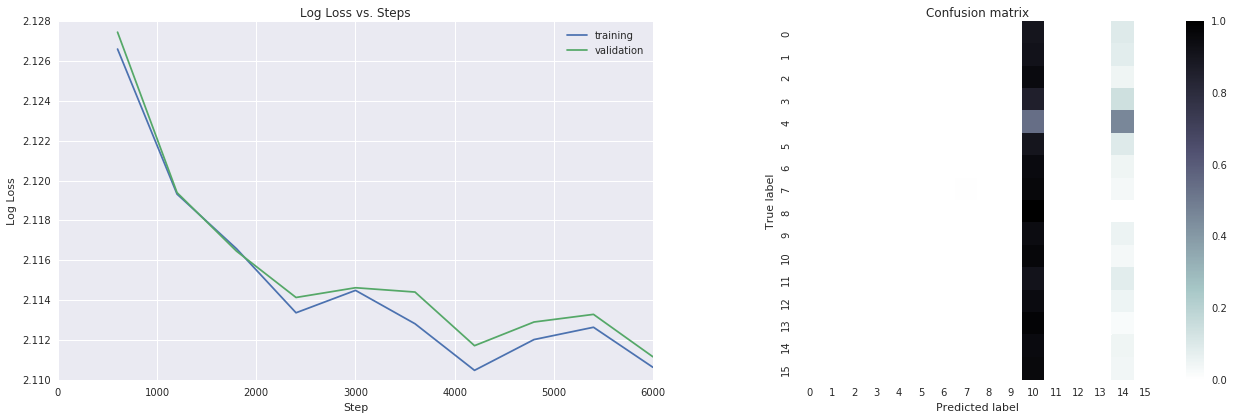

In [20]:
N_CLASSES = 16
BATCH_SIZE = 10  #@param
LEARNING_RATE = 0.005  #@param
STEPS = 6000  #@param

# Create the input functions.
predict_training_input_fn = create_predict_input_fn(
    training_features, training_labels)
predict_validation_input_fn = create_predict_input_fn(
    validation_features, validation_labels)
training_input_fn = create_training_input_fn(
    training_features, training_labels, BATCH_SIZE)

# Create the classifier.
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input_fn(
    training_input_fn)
classifier = tf.contrib.learn.LinearClassifier(
    feature_columns=feature_columns,
    n_classes=N_CLASSES,
    #optimizer=tf.AdagradOptimizer(learning_rate=LEARNING_RATE),
    optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=LEARNING_RATE,l2_regularization_strength=0.019),
    #optimizer=tf.train.AdamOptimizer(learning_rate=LEARNING_RATE),
    gradient_clip_norm=5.0,
    config=mlcc_config.create_config(STEPS),
)

def train_model(classifier):
  """Trains the given classifier.

  Defined as a method for reusability in following tasks.
  """
  # Create the hooks that periodically trigger during model training.
  log_loss_train_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_training_input_fn,
      targets=training_labels,
      input_type="training",
      steps=STEPS)
  log_loss_validation_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_validation_input_fn,
      targets=validation_labels,
      input_type="validation",
      steps=STEPS,
      print_intermediate_results=False)

  print "Training model..."
  classifier.fit(
      input_fn=training_input_fn,
      steps=STEPS,
      monitors=[log_loss_train_hook, log_loss_validation_hook],
  )

  eval_metrics = classifier.evaluate(input_fn=predict_validation_input_fn)
  print "Final accuracy (on validation data): %0.2f" % eval_metrics["accuracy"]

  final_predictions = list(classifier.predict_classes(
    input_fn=predict_validation_input_fn))

  mlcc_plots.plot_loss_confusion_matrix(
      [log_loss_train_hook, log_loss_validation_hook],
      validation_labels,
      final_predictions)

train_model(classifier)

### 5-Genres, full feature set

Training model...
Log Loss (on training data):
  step  601 : 1.58
  step 1201 : 1.58
  step 1801 : 1.57
  step 2401 : 1.56
  step 3001 : 1.56
  step 3601 : 1.55
  step 4201 : 1.55
  step 4801 : 1.55
  step 5401 : 1.55
  step 6000 : 1.55
Final Log Loss (on training data): 1.55
Final Log Loss (on validation data): 1.56
Final accuracy (on validation data): 0.30


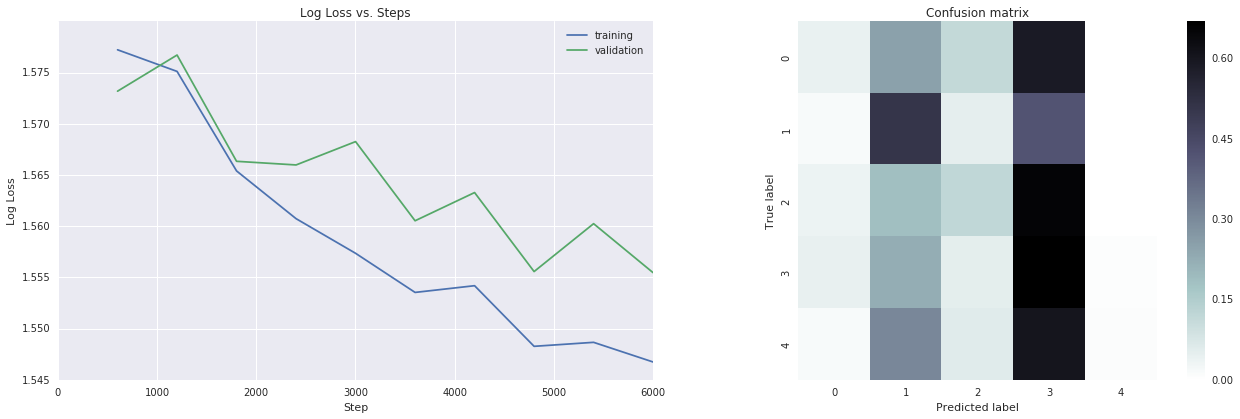

In [17]:
BATCH_SIZE = 10  #@param
LEARNING_RATE = 0.005  #@param
STEPS = 6000  #@param
N_CLASSES = 5

# Create the input functions.
predict_training_input_fn = create_predict_input_fn(
    training_features, training_labels)
predict_validation_input_fn = create_predict_input_fn(
    validation_features, validation_labels)
training_input_fn = create_training_input_fn(
    training_features, training_labels, BATCH_SIZE)

# Create the classifier.
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input_fn(
    training_input_fn)
classifier = tf.contrib.learn.LinearClassifier(
    feature_columns=feature_columns,
    n_classes=N_CLASSES,
    #optimizer=tf.AdagradOptimizer(learning_rate=LEARNING_RATE),
    optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=LEARNING_RATE,l2_regularization_strength=0.019),
    #optimizer=tf.train.AdamOptimizer(learning_rate=LEARNING_RATE),
    gradient_clip_norm=5.0,
    config=mlcc_config.create_config(STEPS),
)

def train_model(classifier):
  """Trains the given classifier.

  Defined as a method for reusability in following tasks.
  """
  # Create the hooks that periodically trigger during model training.
  log_loss_train_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_training_input_fn,
      targets=training_labels,
      input_type="training",
      steps=STEPS)
  log_loss_validation_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_validation_input_fn,
      targets=validation_labels,
      input_type="validation",
      steps=STEPS,
      print_intermediate_results=False)

  print "Training model..."
  classifier.fit(
      input_fn=training_input_fn,
      steps=STEPS,
      monitors=[log_loss_train_hook, log_loss_validation_hook],
  )

  eval_metrics = classifier.evaluate(input_fn=predict_validation_input_fn)
  print "Final accuracy (on validation data): %0.2f" % eval_metrics["accuracy"]

  final_predictions = list(classifier.predict_classes(
    input_fn=predict_validation_input_fn))

  mlcc_plots.plot_loss_confusion_matrix(
      [log_loss_train_hook, log_loss_validation_hook],
      validation_labels,
      final_predictions)

train_model(classifier)

### 16-Genres, chroma only

Training model...
Log Loss (on training data):
  step 1001 : 2.17
  step 2001 : 2.14
  step 3001 : 2.13
  step 4001 : 2.13
  step 5001 : 2.13
  step 6001 : 2.12
  step 7001 : 2.12
  step 8001 : 2.12
  step 9001 : 2.12
  step 10000 : 2.12
Final Log Loss (on training data): 2.12
Final Log Loss (on validation data): 2.13
Final accuracy (on validation data): 0.24


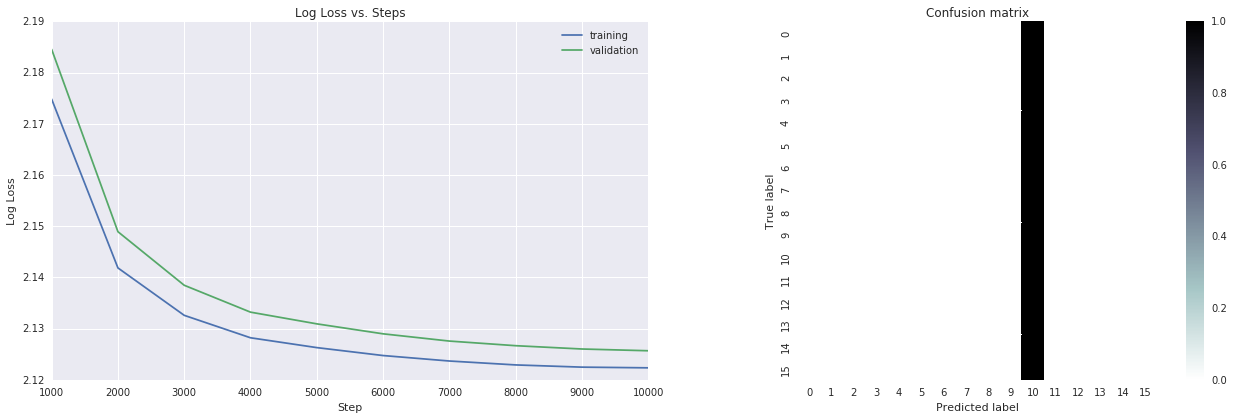

In [36]:
N_CLASSES = 16
BATCH_SIZE = 10  #@param
LEARNING_RATE = 0.001  #@param
STEPS = 10000  #@param

# Create the input functions.
predict_training_input_fn = create_predict_input_fn(
    training_features, training_labels)
predict_validation_input_fn = create_predict_input_fn(
    validation_features, validation_labels)
training_input_fn = create_training_input_fn(
    training_features, training_labels, BATCH_SIZE)

# Create the classifier.
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input_fn(
    training_input_fn)
classifier = tf.contrib.learn.LinearClassifier(
    feature_columns=feature_columns,
    n_classes=N_CLASSES,
    #optimizer=tf.AdagradOptimizer(learning_rate=LEARNING_RATE),
    optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=LEARNING_RATE,l2_regularization_strength=0.019),
    #optimizer=tf.train.AdamOptimizer(learning_rate=LEARNING_RATE),
    gradient_clip_norm=5.0,
    config=mlcc_config.create_config(STEPS),
)

def train_model(classifier):
  """Trains the given classifier.

  Defined as a method for reusability in following tasks.
  """
  # Create the hooks that periodically trigger during model training.
  log_loss_train_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_training_input_fn,
      targets=training_labels,
      input_type="training",
      steps=STEPS)
  log_loss_validation_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_validation_input_fn,
      targets=validation_labels,
      input_type="validation",
      steps=STEPS,
      print_intermediate_results=False)

  print "Training model..."
  classifier.fit(
      input_fn=training_input_fn,
      steps=STEPS,
      monitors=[log_loss_train_hook, log_loss_validation_hook],
  )

  eval_metrics = classifier.evaluate(input_fn=predict_validation_input_fn)
  print "Final accuracy (on validation data): %0.2f" % eval_metrics["accuracy"]

  final_predictions = list(classifier.predict_classes(
    input_fn=predict_validation_input_fn))

  mlcc_plots.plot_loss_confusion_matrix(
      [log_loss_train_hook, log_loss_validation_hook],
      validation_labels,
      final_predictions)

train_model(classifier)

### 16-Genres, mfcc only
not good at learning

Training model...
Log Loss (on training data):
  step 1001 : 2.14
  step 2001 : 2.13
  step 3001 : 2.12
  step 4001 : 2.12
  step 5001 : 2.12
  step 6001 : 2.12
  step 7001 : 2.12
  step 8001 : 2.12
  step 9001 : 2.12
  step 10000 : 2.12
Final Log Loss (on training data): 2.12
Final Log Loss (on validation data): 2.12
Final accuracy (on validation data): 0.24


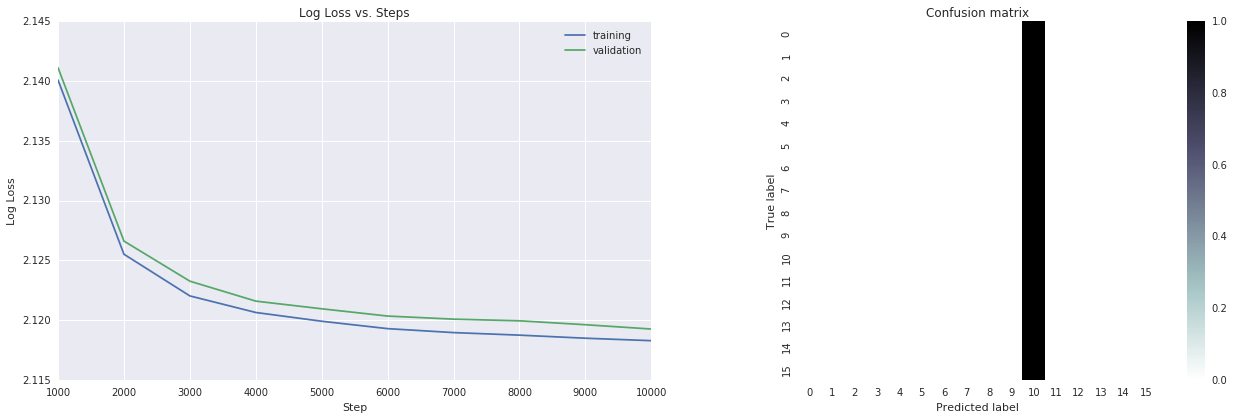

In [44]:
N_CLASSES = 16
BATCH_SIZE = 10  #@param
LEARNING_RATE = 0.001  #@param
STEPS = 10000  #@param

# Create the input functions.
predict_training_input_fn = create_predict_input_fn(
    training_features, training_labels)
predict_validation_input_fn = create_predict_input_fn(
    validation_features, validation_labels)
training_input_fn = create_training_input_fn(
    training_features, training_labels, BATCH_SIZE)

# Create the classifier.
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input_fn(
    training_input_fn)
classifier = tf.contrib.learn.LinearClassifier(
    feature_columns=feature_columns,
    n_classes=N_CLASSES,
    #optimizer=tf.AdagradOptimizer(learning_rate=LEARNING_RATE),
    optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=LEARNING_RATE,l2_regularization_strength=0.019),
    #optimizer=tf.train.AdamOptimizer(learning_rate=LEARNING_RATE),
    gradient_clip_norm=5.0,
    config=mlcc_config.create_config(STEPS),
)

def train_model(classifier):
  """Trains the given classifier.

  Defined as a method for reusability in following tasks.
  """
  # Create the hooks that periodically trigger during model training.
  log_loss_train_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_training_input_fn,
      targets=training_labels,
      input_type="training",
      steps=STEPS)
  log_loss_validation_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_validation_input_fn,
      targets=validation_labels,
      input_type="validation",
      steps=STEPS,
      print_intermediate_results=False)

  print "Training model..."
  classifier.fit(
      input_fn=training_input_fn,
      steps=STEPS,
      monitors=[log_loss_train_hook, log_loss_validation_hook],
  )

  eval_metrics = classifier.evaluate(input_fn=predict_validation_input_fn)
  print "Final accuracy (on validation data): %0.2f" % eval_metrics["accuracy"]

  final_predictions = list(classifier.predict_classes(
    input_fn=predict_validation_input_fn))

  mlcc_plots.plot_loss_confusion_matrix(
      [log_loss_train_hook, log_loss_validation_hook],
      validation_labels,
      final_predictions)

train_model(classifier)

### 16-Genres, mfcc+chroma

Training model...
Log Loss (on training data):
  step 1001 : 2.13
  step 2001 : 2.12
  step 3001 : 2.12
  step 4001 : 2.12
  step 5001 : 2.12
  step 6001 : 2.12
  step 7001 : 2.12
  step 8001 : 2.12
  step 9001 : 2.12
  step 10000 : 2.12
Final Log Loss (on training data): 2.12
Final Log Loss (on validation data): 2.12
Final accuracy (on validation data): 0.24


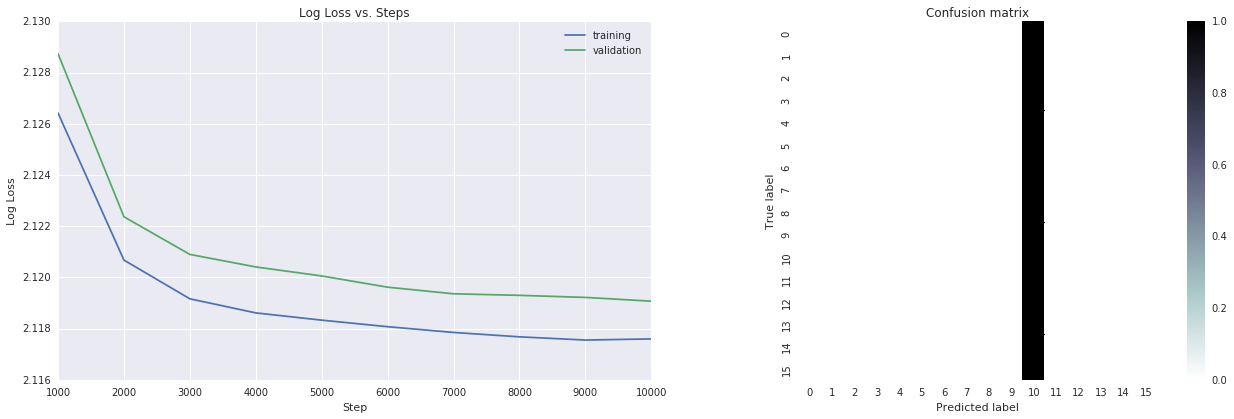

In [55]:
N_CLASSES = 16
BATCH_SIZE = 10  #@param
LEARNING_RATE = 0.001  #@param
STEPS = 10000  #@param

# Create the input functions.
predict_training_input_fn = create_predict_input_fn(
    training_features, training_labels)
predict_validation_input_fn = create_predict_input_fn(
    validation_features, validation_labels)
training_input_fn = create_training_input_fn(
    training_features, training_labels, BATCH_SIZE)

# Create the classifier.
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input_fn(
    training_input_fn)
classifier = tf.contrib.learn.LinearClassifier(
    feature_columns=feature_columns,
    n_classes=N_CLASSES,
    #optimizer=tf.AdagradOptimizer(learning_rate=LEARNING_RATE),
    optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=LEARNING_RATE,l2_regularization_strength=0.019),
    #optimizer=tf.train.AdamOptimizer(learning_rate=LEARNING_RATE),
    gradient_clip_norm=5.0,
    config=mlcc_config.create_config(STEPS),
)

def train_model(classifier):
  """Trains the given classifier.

  Defined as a method for reusability in following tasks.
  """
  # Create the hooks that periodically trigger during model training.
  log_loss_train_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_training_input_fn,
      targets=training_labels,
      input_type="training",
      steps=STEPS)
  log_loss_validation_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_validation_input_fn,
      targets=validation_labels,
      input_type="validation",
      steps=STEPS,
      print_intermediate_results=False)

  print "Training model..."
  classifier.fit(
      input_fn=training_input_fn,
      steps=STEPS,
      monitors=[log_loss_train_hook, log_loss_validation_hook],
  )

  eval_metrics = classifier.evaluate(input_fn=predict_validation_input_fn)
  print "Final accuracy (on validation data): %0.2f" % eval_metrics["accuracy"]

  final_predictions = list(classifier.predict_classes(
    input_fn=predict_validation_input_fn))

  mlcc_plots.plot_loss_confusion_matrix(
      [log_loss_train_hook, log_loss_validation_hook],
      validation_labels,
      final_predictions)

train_model(classifier)

### 2-Generes, full feature set

Training model...
Log Loss (on training data):
  step 1001 : 0.68
  step 2001 : 0.68
  step 3001 : 0.67
  step 4001 : 0.67
  step 5001 : 0.67
  step 6001 : 0.67
  step 7001 : 0.67
  step 8001 : 0.66
  step 9001 : 0.66
  step 10000 : 0.66
Final Log Loss (on training data): 0.66
Final Log Loss (on validation data): 0.65
Final accuracy (on validation data): 0.59


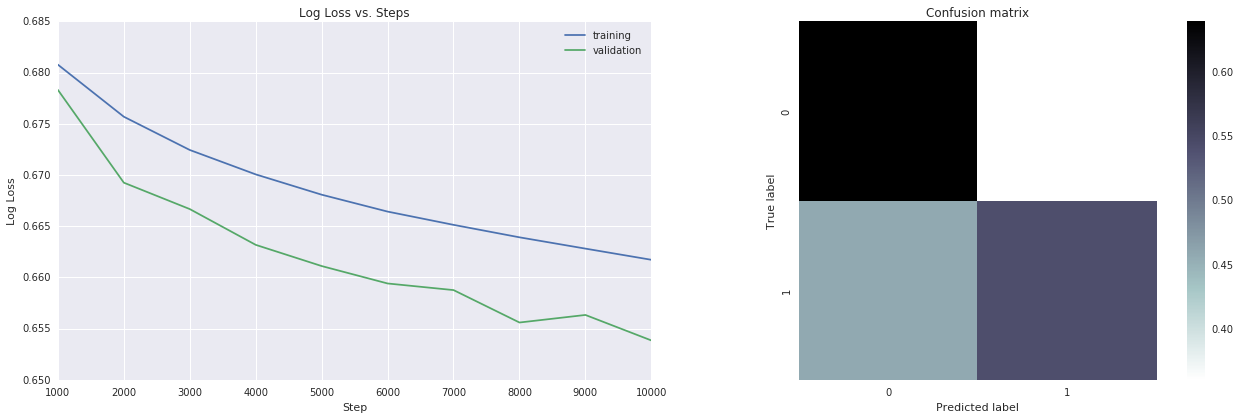

In [15]:
N_CLASSES = 2
BATCH_SIZE = 10  #@param
LEARNING_RATE = 0.001  #@param
STEPS = 10000  #@param

# Create the input functions.
predict_training_input_fn = create_predict_input_fn(
    training_features, training_labels)
predict_validation_input_fn = create_predict_input_fn(
    validation_features, validation_labels)
training_input_fn = create_training_input_fn(
    training_features, training_labels, BATCH_SIZE)

# Create the classifier.
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input_fn(
    training_input_fn)
classifier = tf.contrib.learn.LinearClassifier(
    feature_columns=feature_columns,
    n_classes=N_CLASSES,
    #optimizer=tf.AdagradOptimizer(learning_rate=LEARNING_RATE),
    optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=LEARNING_RATE,l2_regularization_strength=0.019),
    #optimizer=tf.train.AdamOptimizer(learning_rate=LEARNING_RATE),
    gradient_clip_norm=5.0,
    config=mlcc_config.create_config(STEPS),
)

def train_model(classifier):
  """Trains the given classifier.

  Defined as a method for reusability in following tasks.
  """
  # Create the hooks that periodically trigger during model training.
  log_loss_train_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_training_input_fn,
      targets=training_labels,
      input_type="training",
      steps=STEPS)
  log_loss_validation_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_validation_input_fn,
      targets=validation_labels,
      input_type="validation",
      steps=STEPS,
      print_intermediate_results=False)

  print "Training model..."
  classifier.fit(
      input_fn=training_input_fn,
      steps=STEPS,
      monitors=[log_loss_train_hook, log_loss_validation_hook],
  )

  eval_metrics = classifier.evaluate(input_fn=predict_validation_input_fn)
  print "Final accuracy (on validation data): %0.2f" % eval_metrics["accuracy"]

  final_predictions = list(classifier.predict_classes(
    input_fn=predict_validation_input_fn))

  mlcc_plots.plot_loss_confusion_matrix(
      [log_loss_train_hook, log_loss_validation_hook],
      validation_labels,
      final_predictions)

train_model(classifier)

## Neural Network model for fma.

We experimented with various batch size, learning rate, hidden units architechure and regularization methods.
Note that the `DNNClassifier` uses Softmax by default.


### 16-Genres, full feature set

Training model...
Log Loss (on training data):
  step 2501 : 2.12
  step 5001 : 2.11
  step 7501 : 2.11
  step 10001 : 2.11
  step 12501 : 2.11
  step 15001 : 2.11
  step 17501 : 2.10
  step 20001 : 2.10
  step 22501 : 2.10
  step 25000 : 2.10
Final Log Loss (on training data): 2.10
Final Log Loss (on validation data): 2.10
Final accuracy (on validation data): 0.27


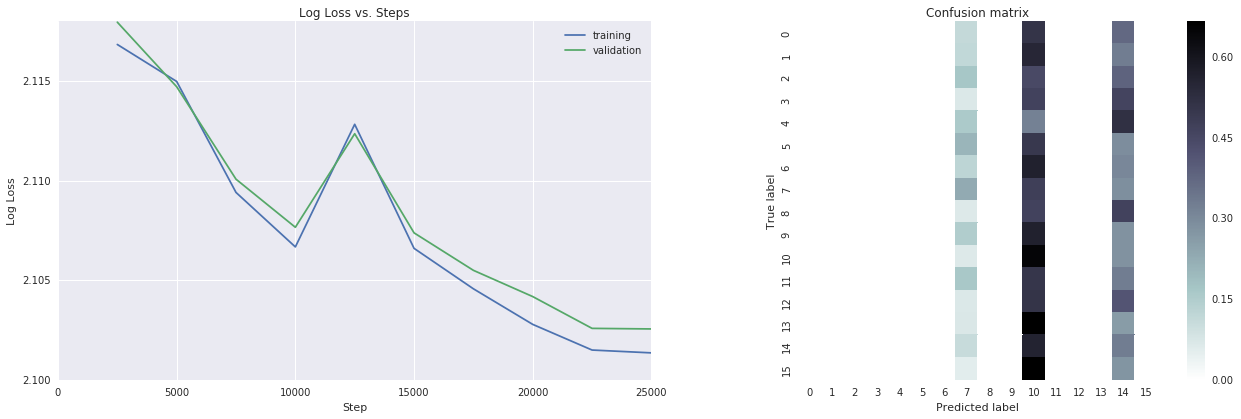

In [0]:
N_CLASSES = 16
BATCH_SIZE = 10
HIDDEN_UNITS = [50, 20]
LEARNING_RATE = 0.01
STEPS = 25000
gradient_clip_norm = 2.0

#optimizer = tf.AdagradOptimizer(learning_rate=LEARNING_RATE)
#optimizer=tf.train.AdamOptimizer(learning_rate=LEARNING_RATE),
optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=LEARNING_RATE, initial_accumulator_value=0.01, l2_regularization_strength=0.002)
#optimizer=tf.train.ProximalGradientDescentOptimizer(learning_rate=LEARNING_RATE, l1_regularization_strength=0.0, l2_regularization_strength=0.001)
#optimizer = tf.train.RMSPropOptimizer(learning_rate=0.003, decay=0.1, momentum=0.9, epsilon=1e-10, centered=False)

# Create the input functions.
predict_training_input_fn = create_predict_input_fn(
    training_features, training_labels)
predict_validation_input_fn = create_predict_input_fn(
    validation_features, validation_labels)
training_input_fn = create_training_input_fn(
    training_features, training_labels, BATCH_SIZE)

feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input_fn(
    training_input_fn)

# Create DNN classifier.
classifier = tf.contrib.learn.DNNClassifier(
  feature_columns=feature_columns,
  n_classes=N_CLASSES,
  hidden_units=HIDDEN_UNITS,
  optimizer=optimizer,
  gradient_clip_norm=gradient_clip_norm,
  config=mlcc_config.create_config(STEPS),
)

def train_model_solution(classifier):
  """Trains the given classifier."""
  # Create the hooks that periodically trigger during model training.
  log_loss_train_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_training_input_fn,
      targets=training_labels,
      input_type="training",
      steps=STEPS)
  log_loss_validation_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_validation_input_fn,
      targets=validation_labels,
      input_type="validation",
      steps=STEPS,
      print_intermediate_results=False)

  print "Training model..."
  classifier.fit(
      input_fn=training_input_fn,
      steps=STEPS,
      monitors=[log_loss_train_hook, log_loss_validation_hook],
  )
  
  eval_metrics = classifier.evaluate(input_fn=predict_validation_input_fn)
  print "Final accuracy (on validation data): %0.2f" % eval_metrics["accuracy"]

  final_predictions = list(classifier.predict_classes(
      input_fn=predict_validation_input_fn))

  mlcc_plots.plot_loss_confusion_matrix(
      [log_loss_train_hook, log_loss_validation_hook],
      validation_labels,
      final_predictions)
  
train_model_solution(classifier)

### 5-Genres, full feature set

Training model...
Log Loss (on training data):
  step 2501 : 1.54
  step 5001 : 1.53
  step 7501 : 1.52
  step 10001 : 1.50
  step 12501 : 1.49
  step 15001 : 1.48
  step 17501 : 1.48
  step 20001 : 1.47
  step 22501 : 1.46
  step 25000 : 1.45
Final Log Loss (on training data): 1.45
Final Log Loss (on validation data): 1.50
Final accuracy (on validation data): 0.35


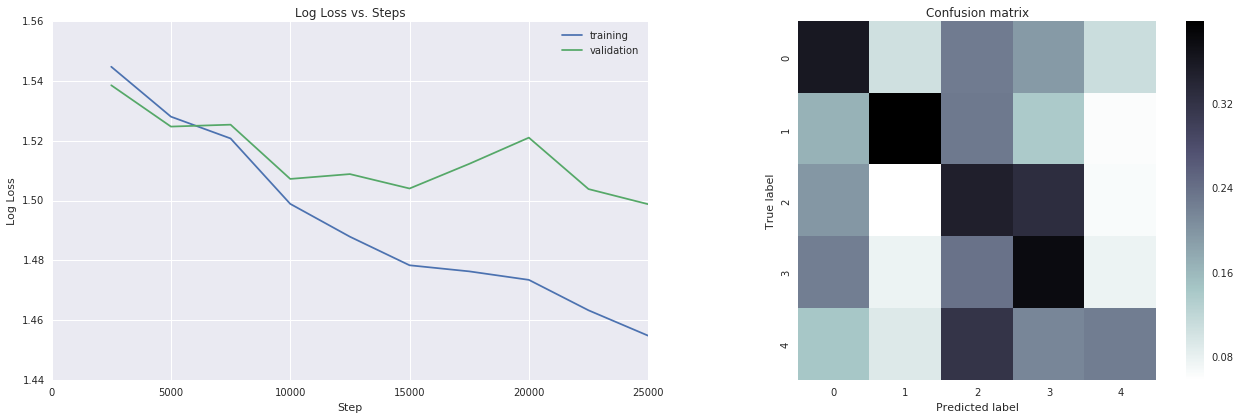

In [24]:
N_CLASSES = 5
BATCH_SIZE = 10
HIDDEN_UNITS = [50, 20]
LEARNING_RATE = 0.01
STEPS = 25000
gradient_clip_norm = 2.0

#optimizer = tf.AdagradOptimizer(learning_rate=LEARNING_RATE)
#optimizer=tf.train.AdamOptimizer(learning_rate=LEARNING_RATE),
optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=LEARNING_RATE, initial_accumulator_value=0.01, l2_regularization_strength=0.002)
#optimizer=tf.train.ProximalGradientDescentOptimizer(learning_rate=LEARNING_RATE, l1_regularization_strength=0.0, l2_regularization_strength=0.001)
#optimizer = tf.train.RMSPropOptimizer(learning_rate=0.003, decay=0.1, momentum=0.9, epsilon=1e-10, centered=False)

# Create the input functions.
predict_training_input_fn = create_predict_input_fn(
    training_features, training_labels)
predict_validation_input_fn = create_predict_input_fn(
    validation_features, validation_labels)
training_input_fn = create_training_input_fn(
    training_features, training_labels, BATCH_SIZE)

feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input_fn(
    training_input_fn)

# Create DNN classifier.
classifier = tf.contrib.learn.DNNClassifier(
  feature_columns=feature_columns,
  n_classes=N_CLASSES,
  hidden_units=HIDDEN_UNITS,
  optimizer=optimizer,
  gradient_clip_norm=gradient_clip_norm,
  config=mlcc_config.create_config(STEPS),
)

def train_model_solution(classifier):
  """Trains the given classifier."""
  # Create the hooks that periodically trigger during model training.
  log_loss_train_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_training_input_fn,
      targets=training_labels,
      input_type="training",
      steps=STEPS)
  log_loss_validation_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_validation_input_fn,
      targets=validation_labels,
      input_type="validation",
      steps=STEPS,
      print_intermediate_results=False)

  print "Training model..."
  classifier.fit(
      input_fn=training_input_fn,
      steps=STEPS,
      monitors=[log_loss_train_hook, log_loss_validation_hook],
  )
  
  eval_metrics = classifier.evaluate(input_fn=predict_validation_input_fn)
  print "Final accuracy (on validation data): %0.2f" % eval_metrics["accuracy"]

  final_predictions = list(classifier.predict_classes(
      input_fn=predict_validation_input_fn))

  mlcc_plots.plot_loss_confusion_matrix(
      [log_loss_train_hook, log_loss_validation_hook],
      validation_labels,
      final_predictions)
  
train_model_solution(classifier)

In [25]:
def evaluate_train_test():
  predict_test_input_fn = create_predict_input_fn(
      test_features, test_labels)

  eval_metrics = classifier.evaluate(input_fn=predict_test_input_fn)
  print "Final test accuracy (on test data): %0.2f" % eval_metrics["accuracy"]

  final_predictions = list(classifier.predict_classes(
      input_fn=predict_test_input_fn))
  
evaluate_train_test()

Final test accuracy (on test data): 0.32


In [0]:
#@test {"output": "ignore", "timeout": 720}
predict_training_input_fn = create_predict_input_fn(
    training_features, training_labels)
predict_validation_input_fn = create_predict_input_fn(
    validation_features, validation_labels)

def runLoop(batch_size, gradient_clip_norm, optimizer, units, steps):
  # Create the input functions.
  training_input_fn = create_training_input_fn(
      training_features, training_labels, batch_size)
  feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input_fn(
      training_input_fn)
  classifier = tf.contrib.learn.DNNClassifier(
    feature_columns=feature_columns,
    n_classes=N_CLASSES,
    hidden_units=units,
    optimizer=optimizer,
    gradient_clip_norm=gradient_clip_norm,
    config=mlcc_config.create_config(12000),
  )
  train_model_solution(classifier, steps)
  evaluate_train_test()

params: ProximalAdagradOptimizer batch_size= 1 gradient_clip_norm= 1.0 hidden_units= [50, 50] step_count= 12000
Training model...
Log Loss (on training data):
  step 1201 : 1.59
  step 2401 : 1.58
  step 3601 : 1.58
  step 4801 : 1.58
  step 6001 : 1.57
  step 7201 : 1.57
  step 8401 : 1.57
  step 9601 : 1.57
  step 10801 : 1.56
  step 12000 : 1.56
Final Log Loss (on training data): 1.56
Final Log Loss (on validation data): 1.57
Final accuracy (on validation data): 0.28


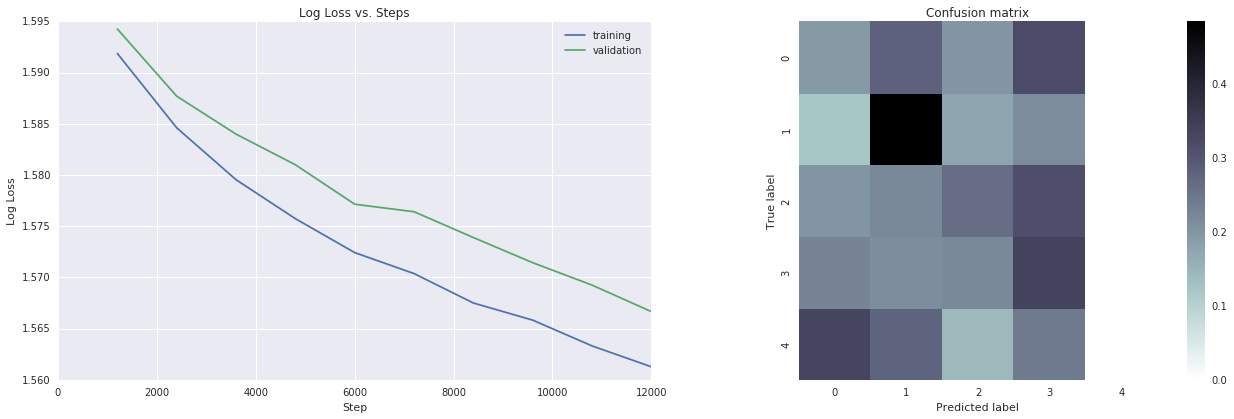

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.60
  step 2401 : 1.59
  step 3601 : 1.59
  step 4801 : 1.58
  step 6001 : 1.58
  step 7201 : 1.58
  step 8401 : 1.57
  step 9601 : 1.57
  step 10801 : 1.57
  step 12000 : 1.57
Final Log Loss (on training data): 1.57
Final Log Loss (on validation data): 1.58
Final accuracy (on validation data): 0.28


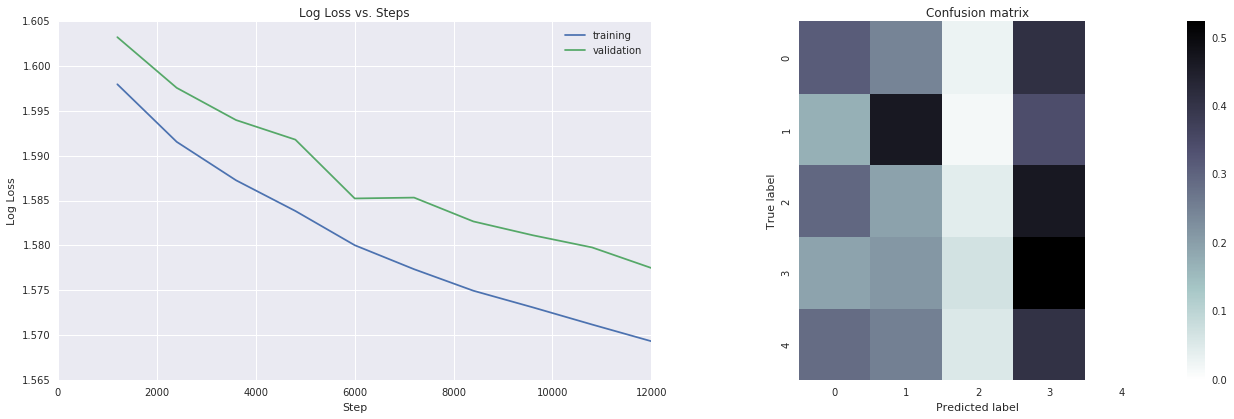

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.59
  step 2401 : 1.59
  step 3601 : 1.58
  step 4801 : 1.58
  step 6001 : 1.58
  step 7201 : 1.57
  step 8401 : 1.57
  step 9601 : 1.57
  step 10801 : 1.57
  step 12000 : 1.57
Final Log Loss (on training data): 1.57
Final Log Loss (on validation data): 1.57
Final accuracy (on validation data): 0.28


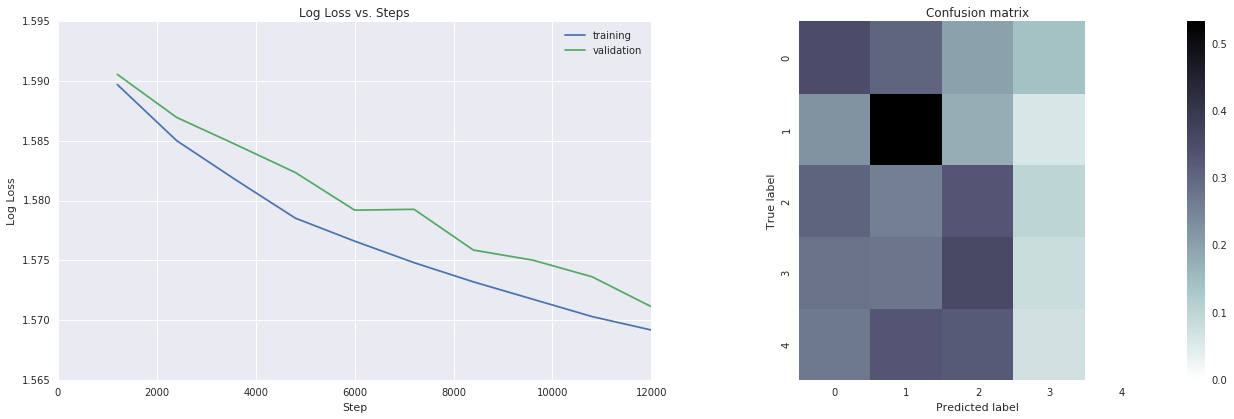

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.59
  step 2401 : 1.58
  step 3601 : 1.58
  step 4801 : 1.58
  step 6001 : 1.57
  step 7201 : 1.57
  step 8401 : 1.57
  step 9601 : 1.57
  step 10801 : 1.57
  step 12000 : 1.57
Final Log Loss (on training data): 1.57
Final Log Loss (on validation data): 1.57
Final accuracy (on validation data): 0.28


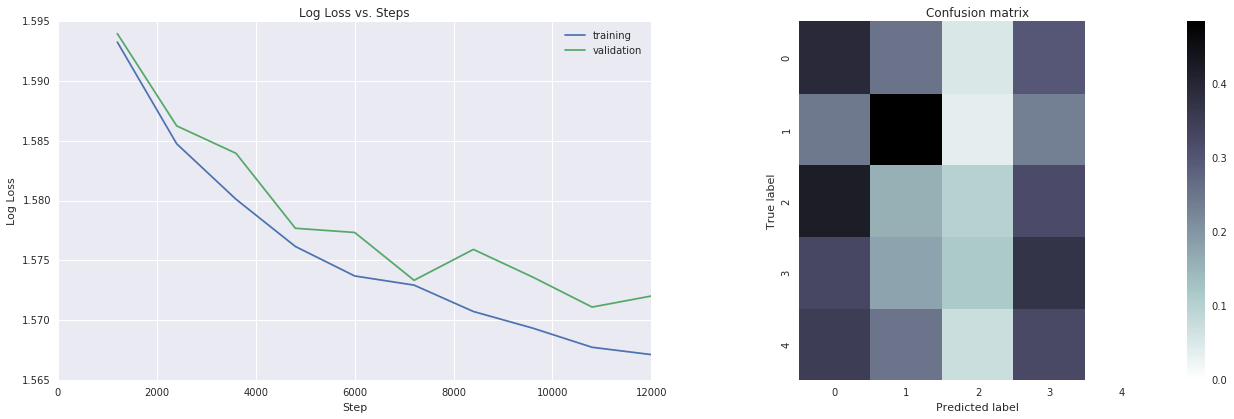

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
params: ProximalAdagradOptimizer batch_size= 1 gradient_clip_norm= 2.5 hidden_units= [50, 50] step_count= 12000
Training model...
Log Loss (on training data):
  step 1201 : 1.58
  step 2401 : 1.57
  step 3601 : 1.56
  step 4801 : 1.56
  step 6001 : 1.55
  step 7201 : 1.55
  step 8401 : 1.55
  step 9601 : 1.55
  step 10801 : 1.54
  step 12000 : 1.54
Final Log Loss (on training data): 1.54
Final Log Loss (on validation data): 1.55
Final accuracy (on validation data): 0.27


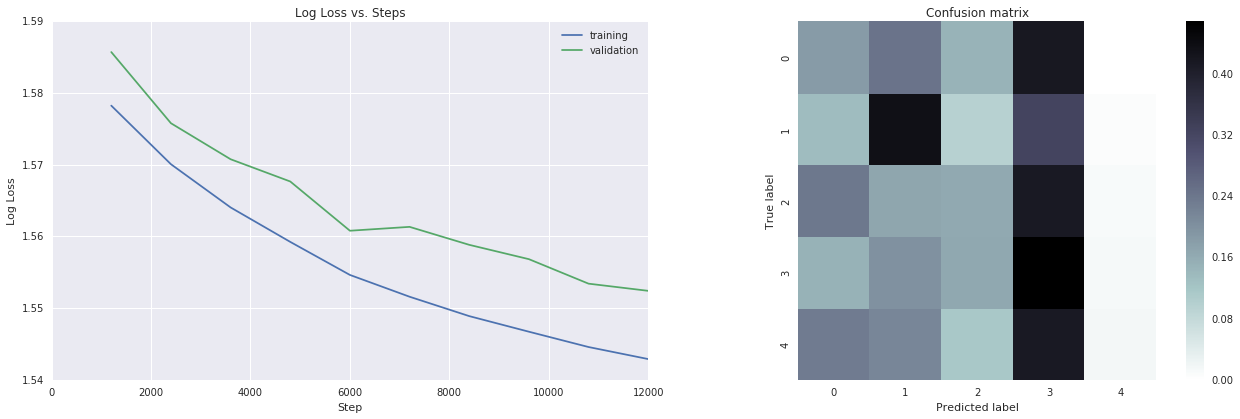

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.59
  step 2401 : 1.58
  step 3601 : 1.58
  step 4801 : 1.57
  step 6001 : 1.57
  step 7201 : 1.57
  step 8401 : 1.56
  step 9601 : 1.56
  step 10801 : 1.56
  step 12000 : 1.56
Final Log Loss (on training data): 1.56
Final Log Loss (on validation data): 1.57
Final accuracy (on validation data): 0.28


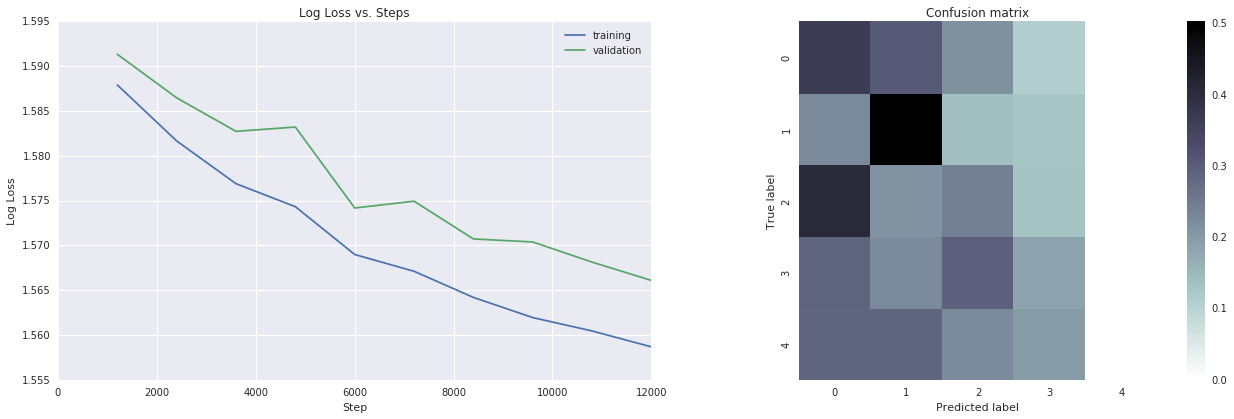

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.59
  step 2401 : 1.58
  step 3601 : 1.57
  step 4801 : 1.57
  step 6001 : 1.57
  step 7201 : 1.56
  step 8401 : 1.56
  step 9601 : 1.56
  step 10801 : 1.56
  step 12000 : 1.55
Final Log Loss (on training data): 1.55
Final Log Loss (on validation data): 1.57
Final accuracy (on validation data): 0.28


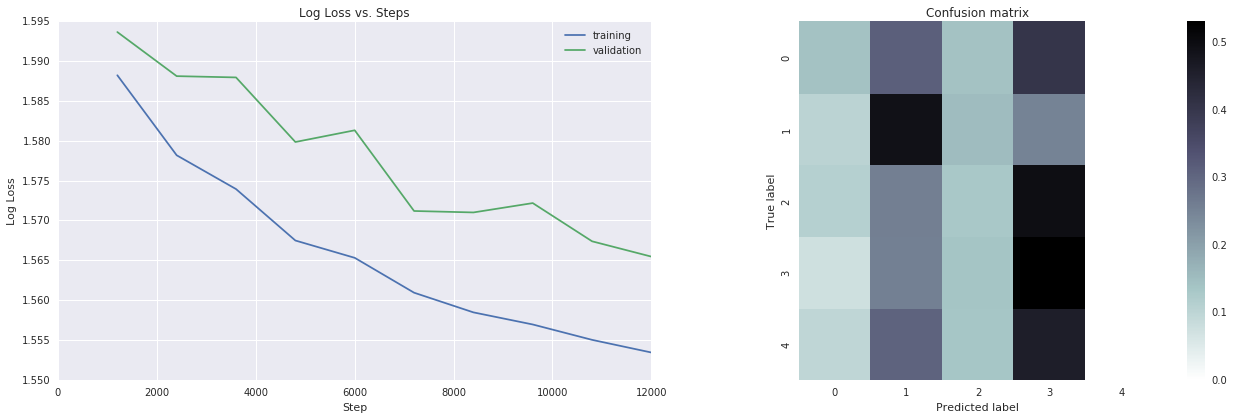

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.59
  step 2401 : 1.58
  step 3601 : 1.58
  step 4801 : 1.57
  step 6001 : 1.57
  step 7201 : 1.57
  step 8401 : 1.57
  step 9601 : 1.56
  step 10801 : 1.56
  step 12000 : 1.56
Final Log Loss (on training data): 1.56
Final Log Loss (on validation data): 1.57
Final accuracy (on validation data): 0.29


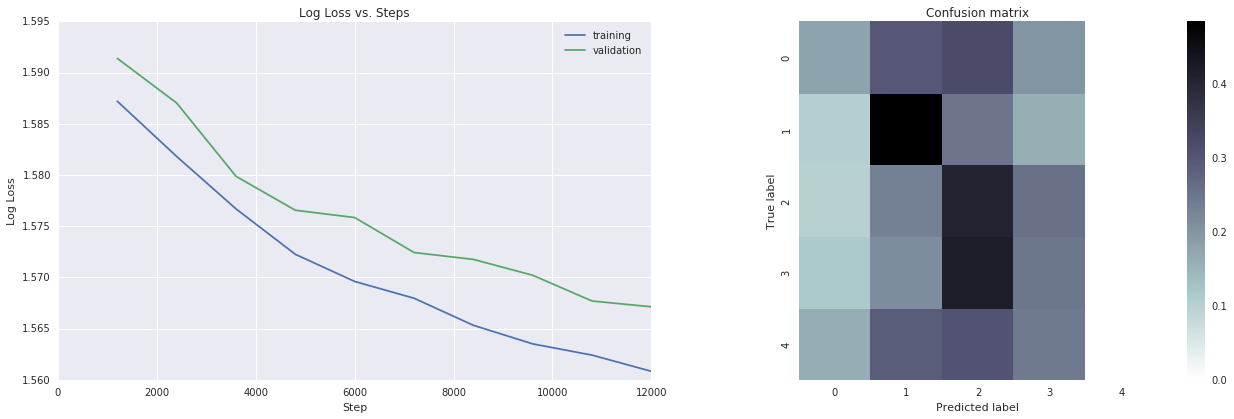

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
params: ProximalAdagradOptimizer batch_size= 1 gradient_clip_norm= 5.0 hidden_units= [50, 50] step_count= 12000
Training model...
Log Loss (on training data):
  step 1201 : 1.59
  step 2401 : 1.58
  step 3601 : 1.58
  step 4801 : 1.57
  step 6001 : 1.57
  step 7201 : 1.57
  step 8401 : 1.57
  step 9601 : 1.56
  step 10801 : 1.56
  step 12000 : 1.56
Final Log Loss (on training data): 1.56
Final Log Loss (on validation data): 1.57
Final accuracy (on validation data): 0.30


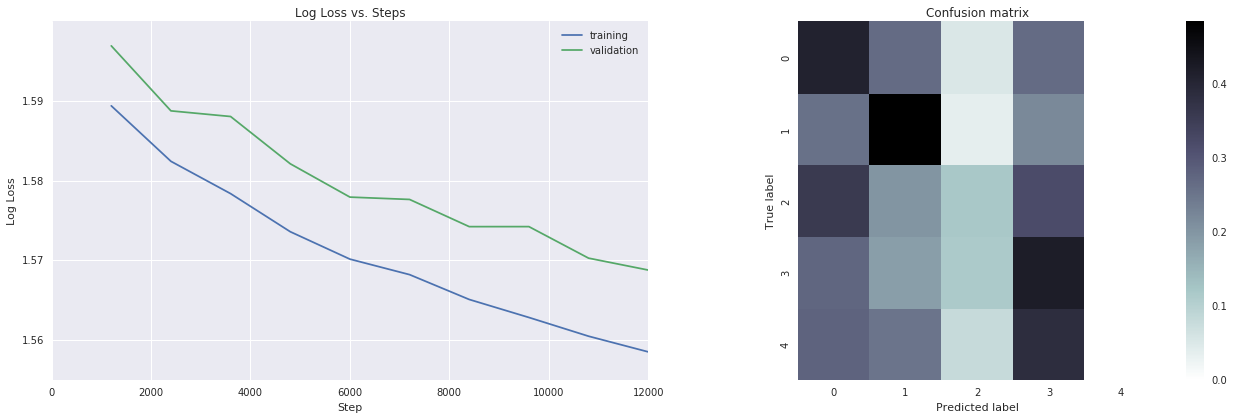

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.58
  step 2401 : 1.58
  step 3601 : 1.57
  step 4801 : 1.57
  step 6001 : 1.57
  step 7201 : 1.56
  step 8401 : 1.56
  step 9601 : 1.56
  step 10801 : 1.56
  step 12000 : 1.56
Final Log Loss (on training data): 1.56
Final Log Loss (on validation data): 1.56
Final accuracy (on validation data): 0.27


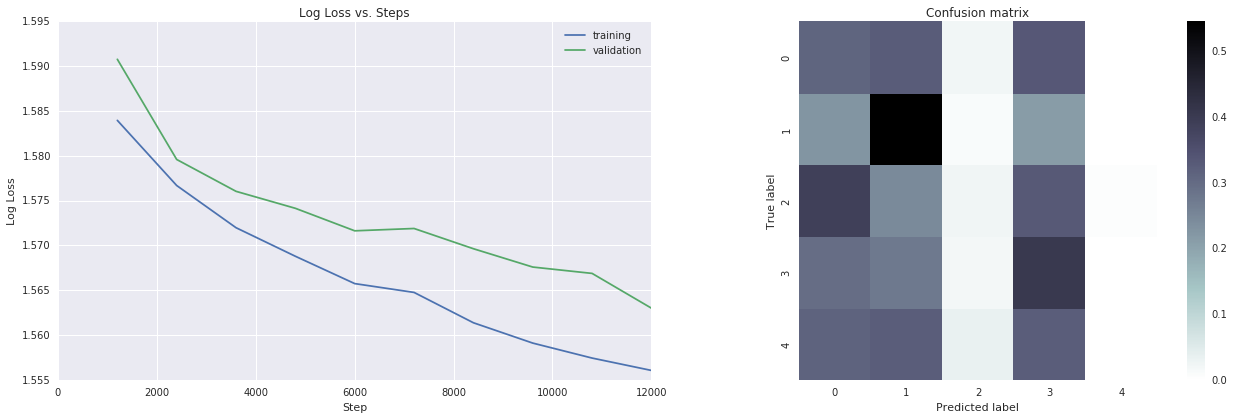

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.58
  step 2401 : 1.57
  step 3601 : 1.57
  step 4801 : 1.57
  step 6001 : 1.56
  step 7201 : 1.56
  step 8401 : 1.56
  step 9601 : 1.56
  step 10801 : 1.55
  step 12000 : 1.55
Final Log Loss (on training data): 1.55
Final Log Loss (on validation data): 1.56
Final accuracy (on validation data): 0.29


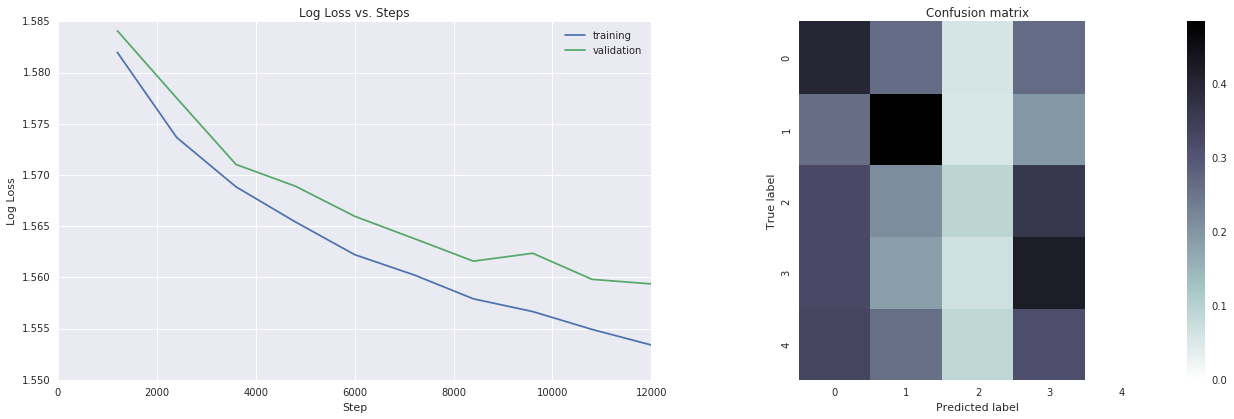

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.59
  step 2401 : 1.58
  step 3601 : 1.58
  step 4801 : 1.57
  step 6001 : 1.57
  step 7201 : 1.57
  step 8401 : 1.57
  step 9601 : 1.57
  step 10801 : 1.56
  step 12000 : 1.56
Final Log Loss (on training data): 1.56
Final Log Loss (on validation data): 1.57
Final accuracy (on validation data): 0.30


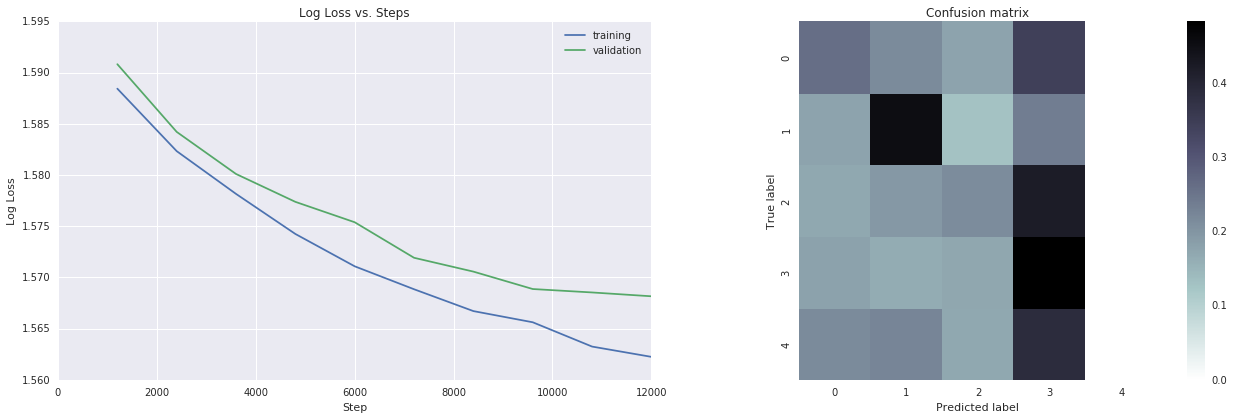

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
params: ProximalAdagradOptimizer batch_size= 1 gradient_clip_norm= 1.0 hidden_units= [50, 50] step_count= 12000
Training model...
Log Loss (on training data):
  step 1201 : 1.58
  step 2401 : 1.57
  step 3601 : 1.57
  step 4801 : 1.56
  step 6001 : 1.55
  step 7201 : 1.55
  step 8401 : 1.55
  step 9601 : 1.55
  step 10801 : 1.54
  step 12000 : 1.54
Final Log Loss (on training data): 1.54
Final Log Loss (on validation data): 1.56
Final accuracy (on validation data): 0.29


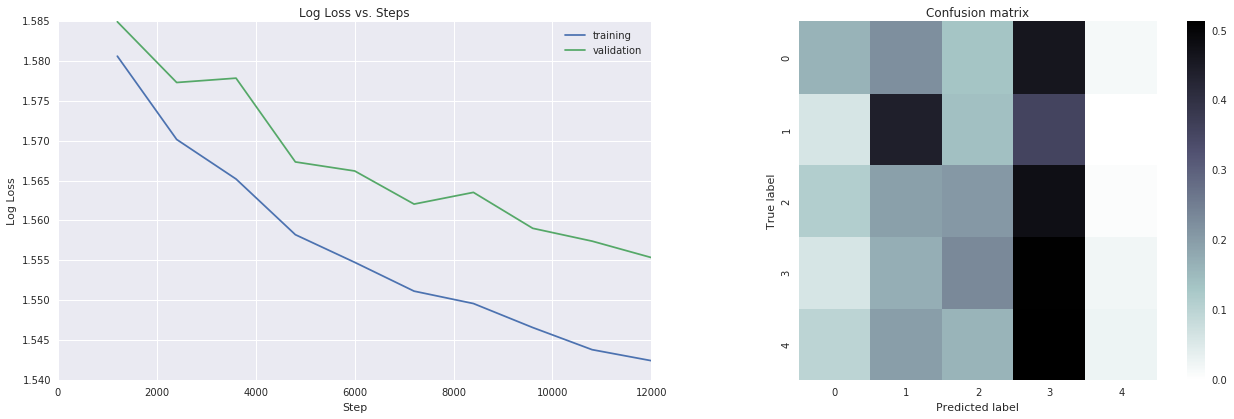

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.59
  step 2401 : 1.58
  step 3601 : 1.58
  step 4801 : 1.57
  step 6001 : 1.57
  step 7201 : 1.56
  step 8401 : 1.56
  step 9601 : 1.56
  step 10801 : 1.55
  step 12000 : 1.55
Final Log Loss (on training data): 1.55
Final Log Loss (on validation data): 1.56
Final accuracy (on validation data): 0.29


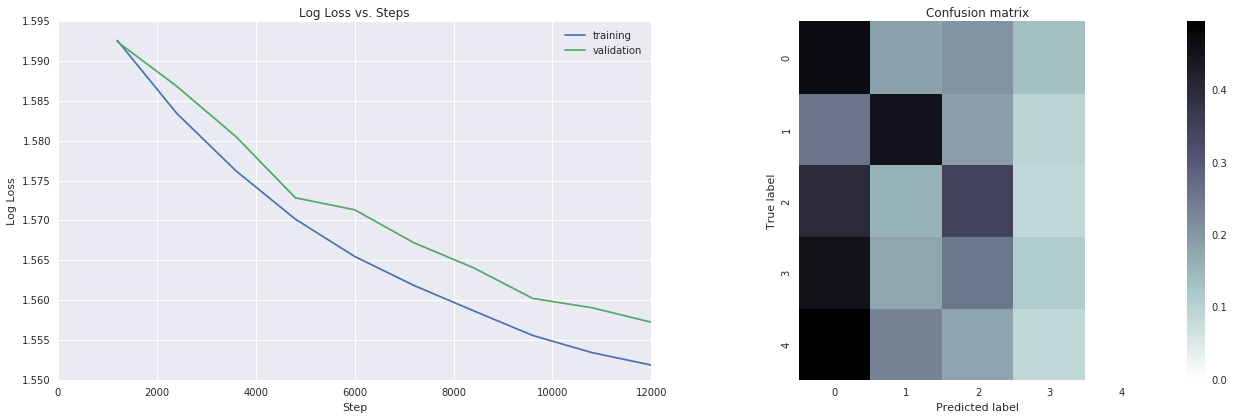

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.59
  step 2401 : 1.58
  step 3601 : 1.57
  step 4801 : 1.57
  step 6001 : 1.57
  step 7201 : 1.56
  step 8401 : 1.56
  step 9601 : 1.56
  step 10801 : 1.56
  step 12000 : 1.56
Final Log Loss (on training data): 1.56
Final Log Loss (on validation data): 1.56
Final accuracy (on validation data): 0.28


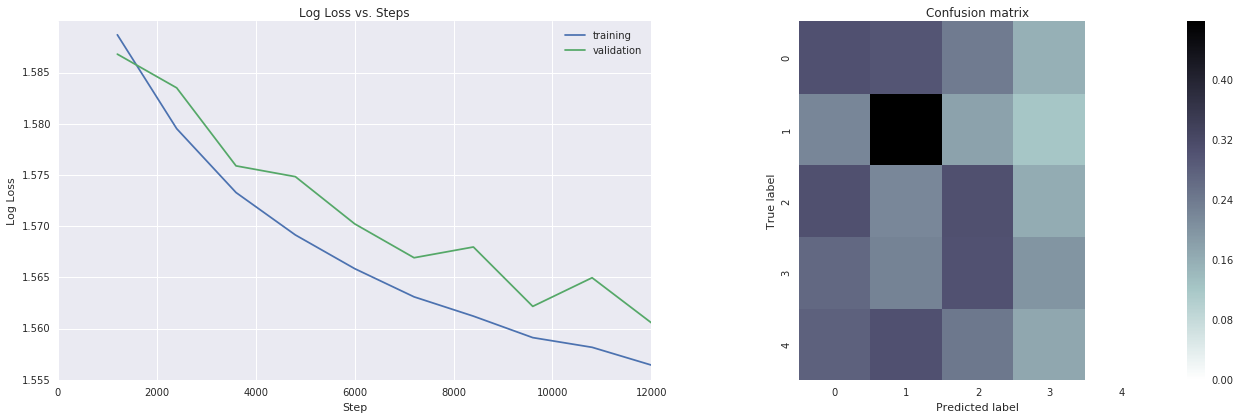

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.59
  step 2401 : 1.58
  step 3601 : 1.58
  step 4801 : 1.57
  step 6001 : 1.57
  step 7201 : 1.57
  step 8401 : 1.57
  step 9601 : 1.57
  step 10801 : 1.57
  step 12000 : 1.56
Final Log Loss (on training data): 1.56
Final Log Loss (on validation data): 1.57
Final accuracy (on validation data): 0.29


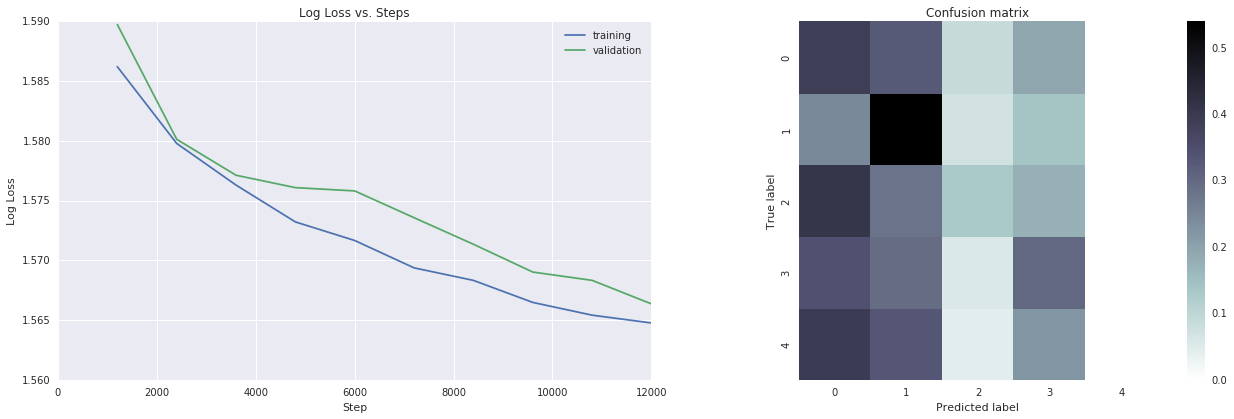

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
params: ProximalAdagradOptimizer batch_size= 1 gradient_clip_norm= 2.5 hidden_units= [50, 50] step_count= 12000
Training model...
Log Loss (on training data):
  step 1201 : 1.58
  step 2401 : 1.57
  step 3601 : 1.56
  step 4801 : 1.55
  step 6001 : 1.55
  step 7201 : 1.54
  step 8401 : 1.54
  step 9601 : 1.54
  step 10801 : 1.53
  step 12000 : 1.53
Final Log Loss (on training data): 1.53
Final Log Loss (on validation data): 1.54
Final accuracy (on validation data): 0.31


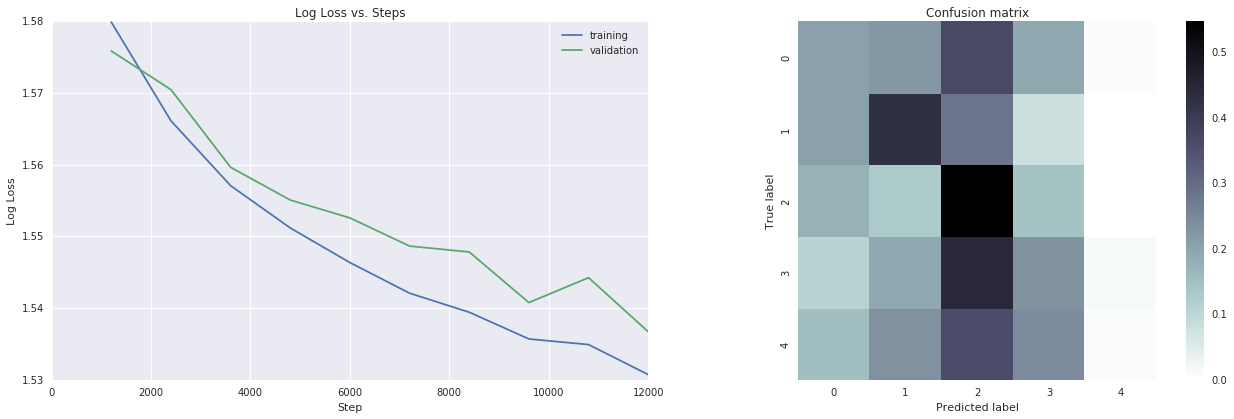

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.57
  step 2401 : 1.56
  step 3601 : 1.55
  step 4801 : 1.55
  step 6001 : 1.55
  step 7201 : 1.54
  step 8401 : 1.54
  step 9601 : 1.54
  step 10801 : 1.54
  step 12000 : 1.53
Final Log Loss (on training data): 1.53
Final Log Loss (on validation data): 1.54
Final accuracy (on validation data): 0.30


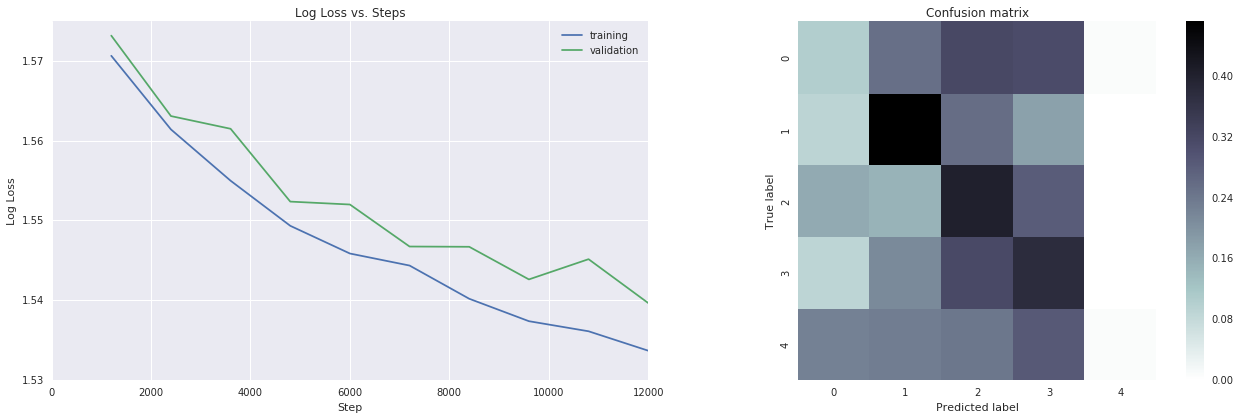

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.59
  step 2401 : 1.57
  step 3601 : 1.57
  step 4801 : 1.56
  step 6001 : 1.56
  step 7201 : 1.56
  step 8401 : 1.55
  step 9601 : 1.55
  step 10801 : 1.55
  step 12000 : 1.55
Final Log Loss (on training data): 1.55
Final Log Loss (on validation data): 1.55
Final accuracy (on validation data): 0.28


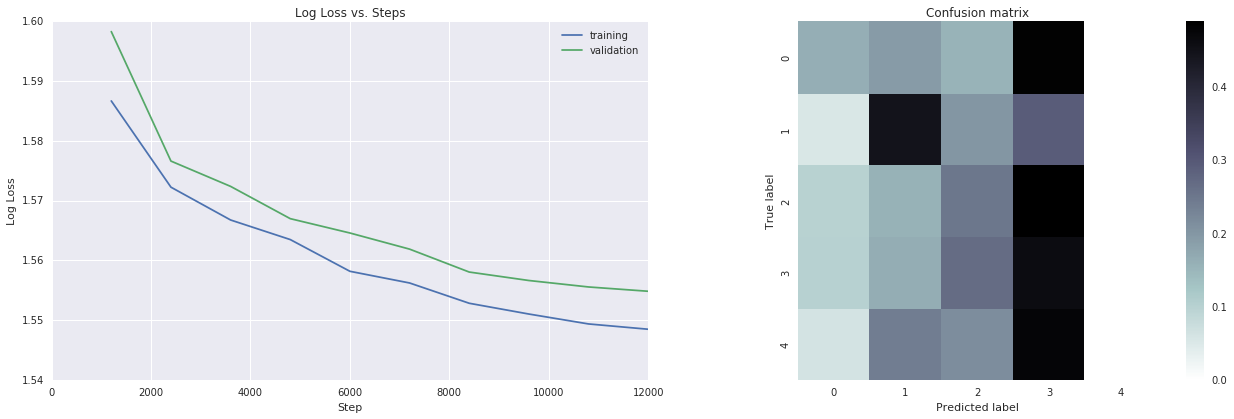

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.58
  step 2401 : 1.57
  step 3601 : 1.57
  step 4801 : 1.56
  step 6001 : 1.56
  step 7201 : 1.56
  step 8401 : 1.56
  step 9601 : 1.56
  step 10801 : 1.56
  step 12000 : 1.55
Final Log Loss (on training data): 1.55
Final Log Loss (on validation data): 1.56
Final accuracy (on validation data): 0.28


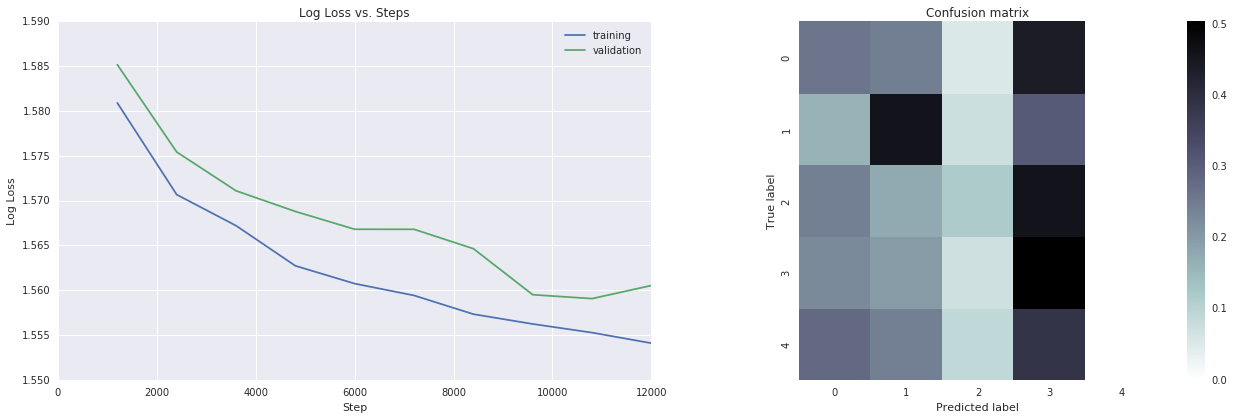

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
params: ProximalAdagradOptimizer batch_size= 1 gradient_clip_norm= 5.0 hidden_units= [50, 50] step_count= 12000
Training model...
Log Loss (on training data):
  step 1201 : 1.57
  step 2401 : 1.56
  step 3601 : 1.56
  step 4801 : 1.56
  step 6001 : 1.55
  step 7201 : 1.55
  step 8401 : 1.54
  step 9601 : 1.54
  step 10801 : 1.54
  step 12000 : 1.54
Final Log Loss (on training data): 1.54
Final Log Loss (on validation data): 1.54
Final accuracy (on validation data): 0.29


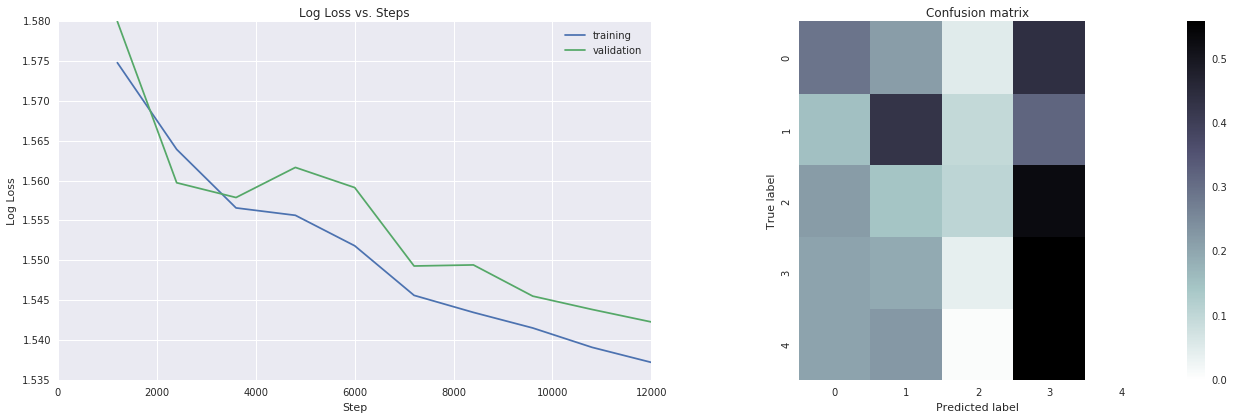

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.58
  step 2401 : 1.57
  step 3601 : 1.56
  step 4801 : 1.56
  step 6001 : 1.55
  step 7201 : 1.55
  step 8401 : 1.55
  step 9601 : 1.55
  step 10801 : 1.54
  step 12000 : 1.54
Final Log Loss (on training data): 1.54
Final Log Loss (on validation data): 1.56
Final accuracy (on validation data): 0.29


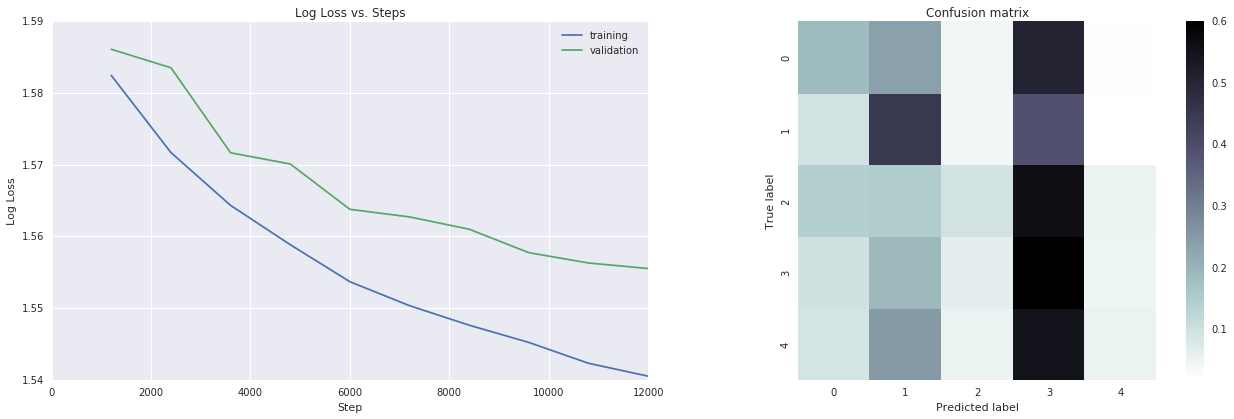

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.58
  step 2401 : 1.57
  step 3601 : 1.56
  step 4801 : 1.56
  step 6001 : 1.55
  step 7201 : 1.55
  step 8401 : 1.55
  step 9601 : 1.55
  step 10801 : 1.55
  step 12000 : 1.54
Final Log Loss (on training data): 1.54
Final Log Loss (on validation data): 1.55
Final accuracy (on validation data): 0.28


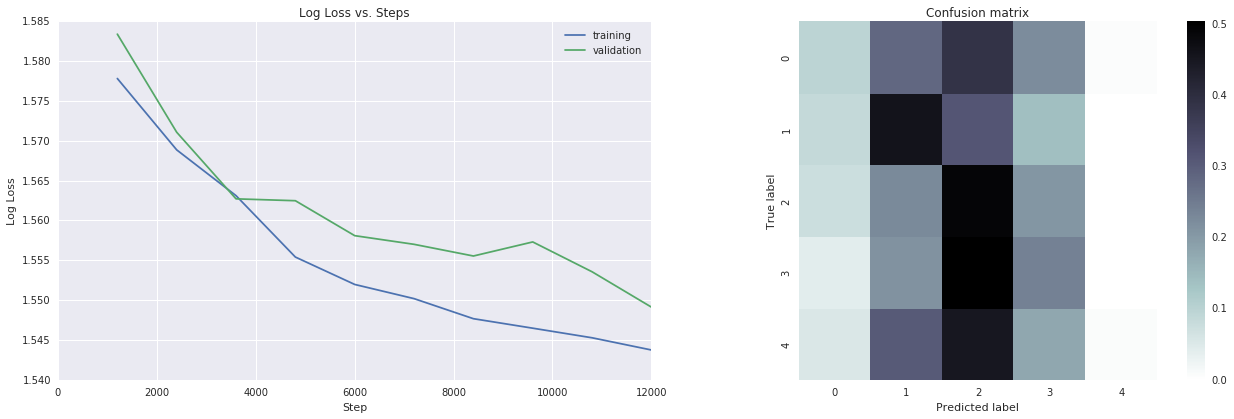

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.59
  step 2401 : 1.58
  step 3601 : 1.58
  step 4801 : 1.57
  step 6001 : 1.57
  step 7201 : 1.57
  step 8401 : 1.57
  step 9601 : 1.57
  step 10801 : 1.56
  step 12000 : 1.56
Final Log Loss (on training data): 1.56
Final Log Loss (on validation data): 1.57
Final accuracy (on validation data): 0.29


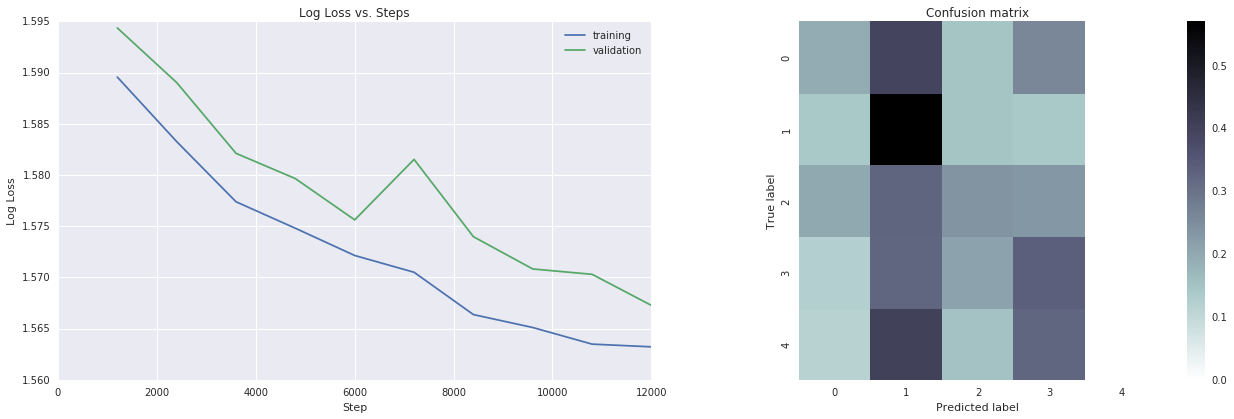

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
params: ProximalAdagradOptimizer batch_size= 1 gradient_clip_norm= 1.0 hidden_units= [50, 50] step_count= 12000
Training model...
Log Loss (on training data):
  step 1201 : 1.58
  step 2401 : 1.57
  step 3601 : 1.55
  step 4801 : 1.54
  step 6001 : 1.54
  step 7201 : 1.53
  step 8401 : 1.53
  step 9601 : 1.53
  step 10801 : 1.53
  step 12000 : 1.53
Final Log Loss (on training data): 1.53
Final Log Loss (on validation data): 1.55
Final accuracy (on validation data): 0.30


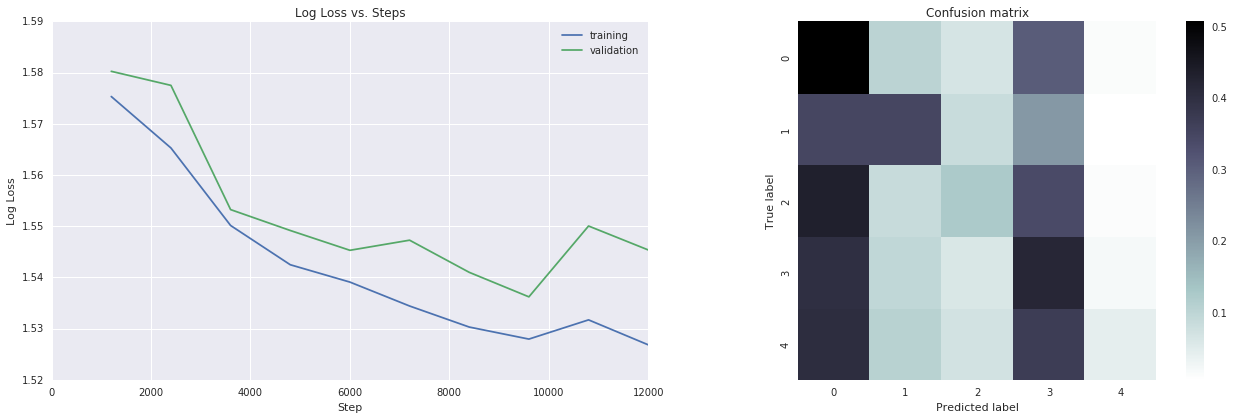

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.57
  step 2401 : 1.56
  step 3601 : 1.55
  step 4801 : 1.55
  step 6001 : 1.54
  step 7201 : 1.54
  step 8401 : 1.54
  step 9601 : 1.54
  step 10801 : 1.54
  step 12000 : 1.54
Final Log Loss (on training data): 1.54
Final Log Loss (on validation data): 1.54
Final accuracy (on validation data): 0.30


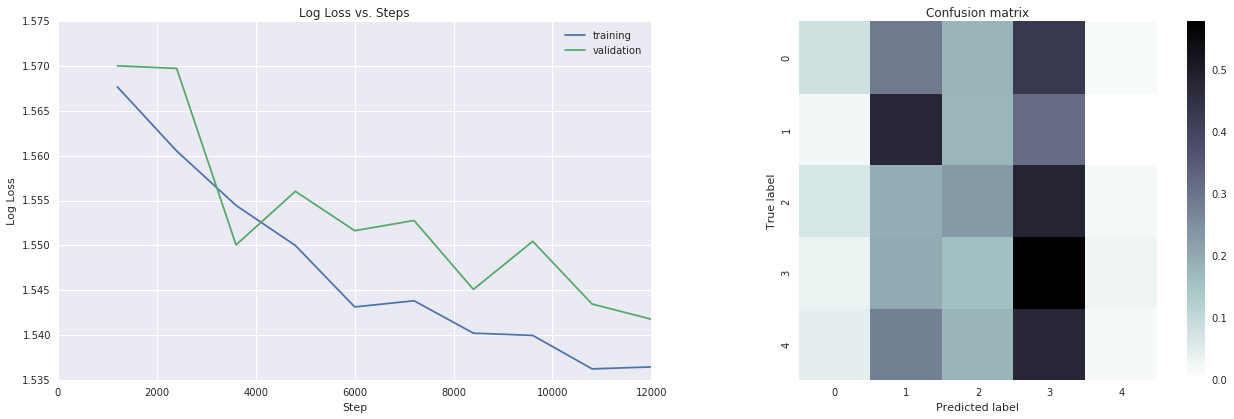

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.58
  step 2401 : 1.56
  step 3601 : 1.56
  step 4801 : 1.56
  step 6001 : 1.55
  step 7201 : 1.55
  step 8401 : 1.55
  step 9601 : 1.55
  step 10801 : 1.55
  step 12000 : 1.55
Final Log Loss (on training data): 1.55
Final Log Loss (on validation data): 1.56
Final accuracy (on validation data): 0.30


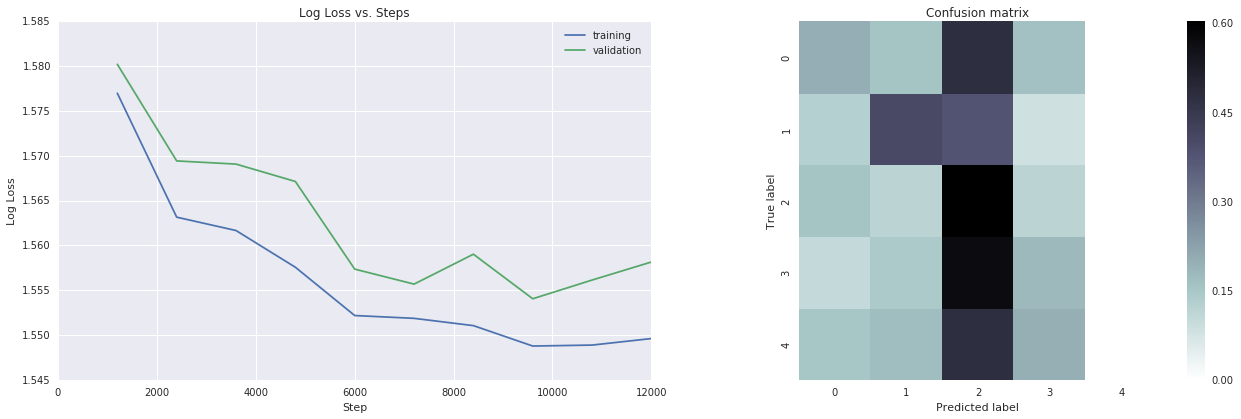

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.58
  step 2401 : 1.57
  step 3601 : 1.57
  step 4801 : 1.56
  step 6001 : 1.56
  step 7201 : 1.56
  step 8401 : 1.56
  step 9601 : 1.56
  step 10801 : 1.56
  step 12000 : 1.56
Final Log Loss (on training data): 1.56
Final Log Loss (on validation data): 1.56
Final accuracy (on validation data): 0.29


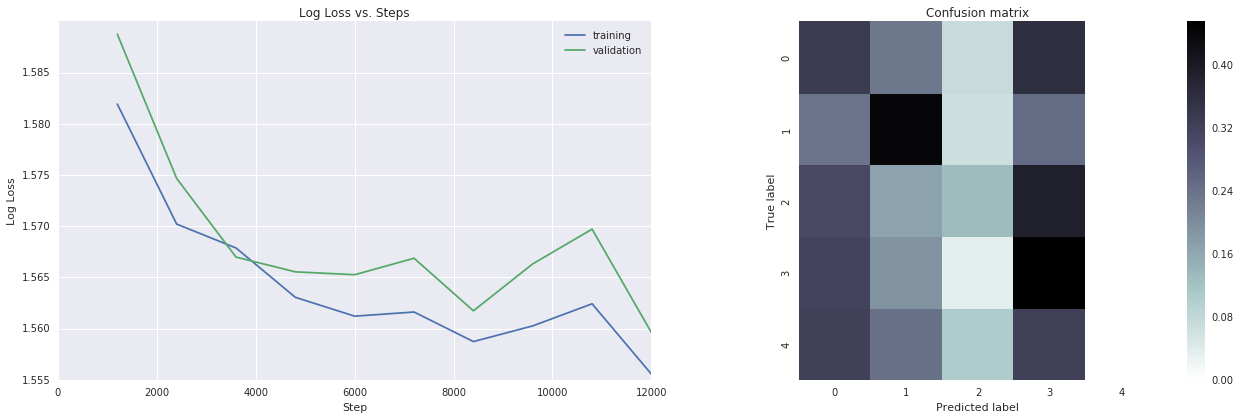

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
params: ProximalAdagradOptimizer batch_size= 1 gradient_clip_norm= 2.5 hidden_units= [50, 50] step_count= 12000
Training model...
Log Loss (on training data):
  step 1201 : 1.57
  step 2401 : 1.57
  step 3601 : 1.54
  step 4801 : 1.53
  step 6001 : 1.53
  step 7201 : 1.53
  step 8401 : 1.52
  step 9601 : 1.52
  step 10801 : 1.51
  step 12000 : 1.51
Final Log Loss (on training data): 1.51
Final Log Loss (on validation data): 1.52
Final accuracy (on validation data): 0.29


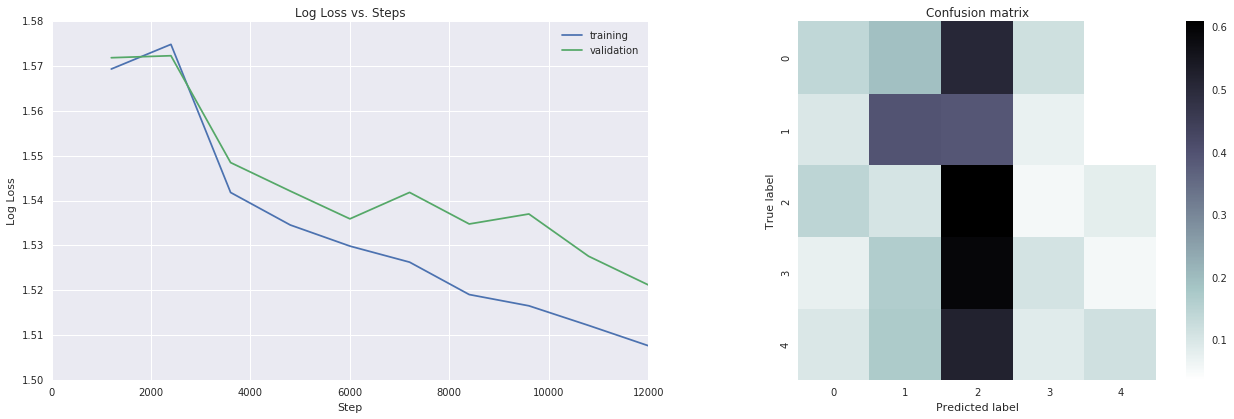

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.57
  step 2401 : 1.55
  step 3601 : 1.54
  step 4801 : 1.53
  step 6001 : 1.53
  step 7201 : 1.53
  step 8401 : 1.53
  step 9601 : 1.52
  step 10801 : 1.52
  step 12000 : 1.52
Final Log Loss (on training data): 1.52
Final Log Loss (on validation data): 1.54
Final accuracy (on validation data): 0.30


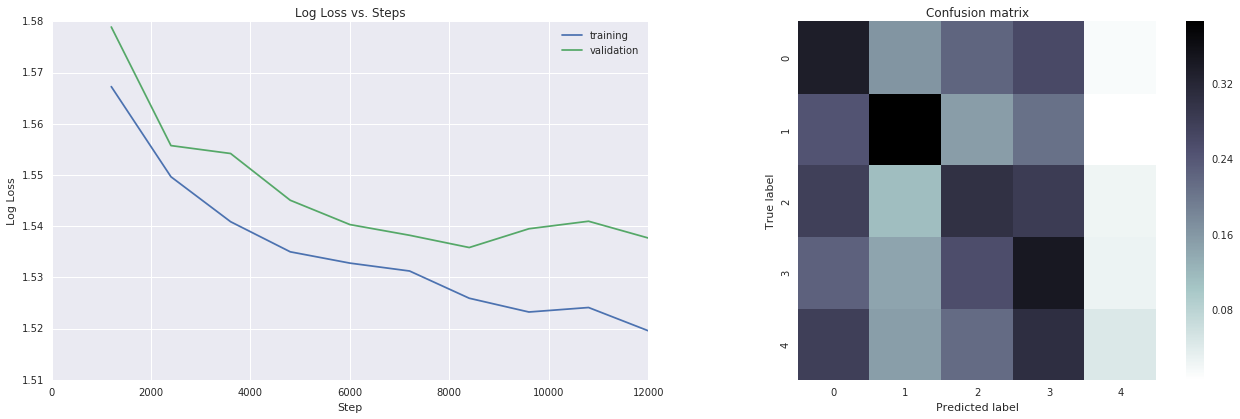

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.57
  step 2401 : 1.55
  step 3601 : 1.55
  step 4801 : 1.55
  step 6001 : 1.54
  step 7201 : 1.54
  step 8401 : 1.54
  step 9601 : 1.55
  step 10801 : 1.54
  step 12000 : 1.54
Final Log Loss (on training data): 1.54
Final Log Loss (on validation data): 1.54
Final accuracy (on validation data): 0.27


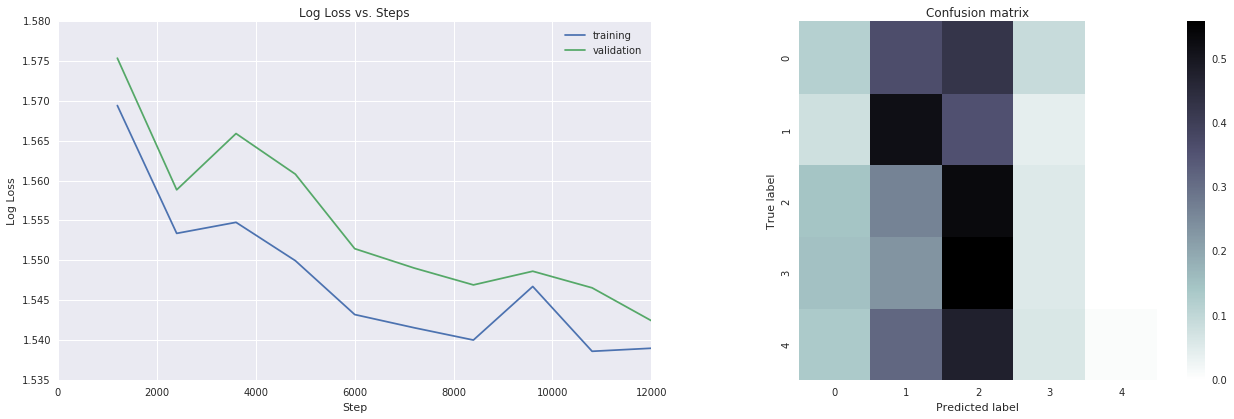

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.58
  step 2401 : 1.56
  step 3601 : 1.56
  step 4801 : 1.56
  step 6001 : 1.56
  step 7201 : 1.55
  step 8401 : 1.55
  step 9601 : 1.55
  step 10801 : 1.55
  step 12000 : 1.55
Final Log Loss (on training data): 1.55
Final Log Loss (on validation data): 1.55
Final accuracy (on validation data): 0.29


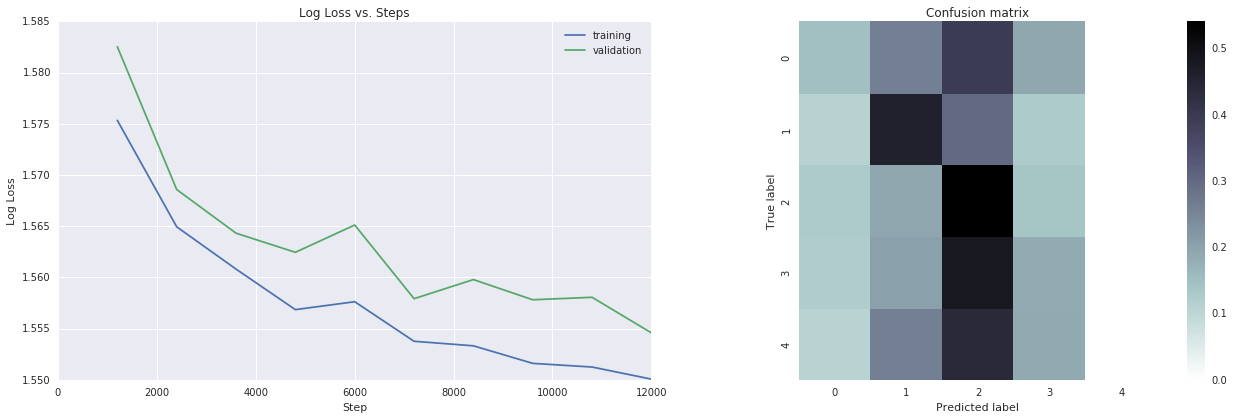

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
params: ProximalAdagradOptimizer batch_size= 1 gradient_clip_norm= 5.0 hidden_units= [50, 50] step_count= 12000
Training model...
Log Loss (on training data):
  step 1201 : 1.56
  step 2401 : 1.55
  step 3601 : 1.54
  step 4801 : 1.53
  step 6001 : 1.52
  step 7201 : 1.52
  step 8401 : 1.51
  step 9601 : 1.51
  step 10801 : 1.50
  step 12000 : 1.50
Final Log Loss (on training data): 1.50
Final Log Loss (on validation data): 1.52
Final accuracy (on validation data): 0.29


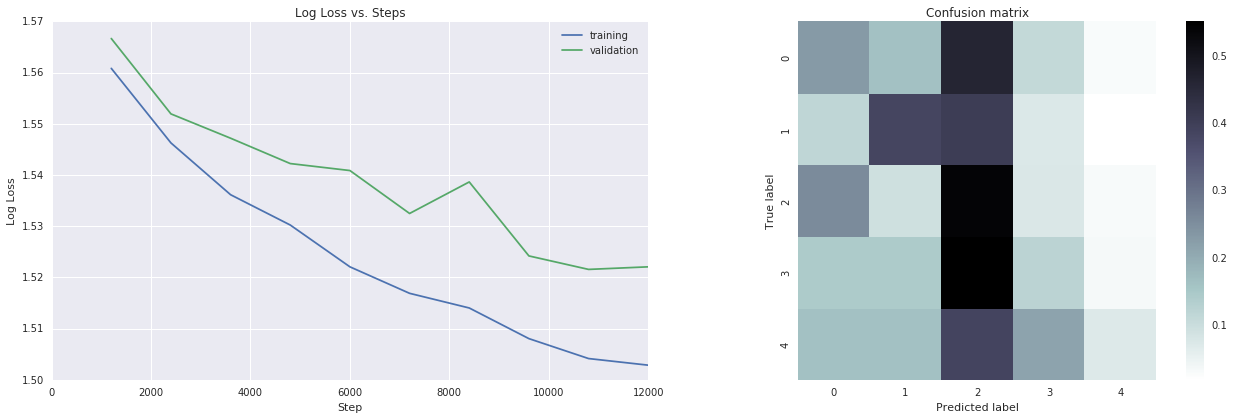

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.57
  step 2401 : 1.56
  step 3601 : 1.55
  step 4801 : 1.54
  step 6001 : 1.54
  step 7201 : 1.54
  step 8401 : 1.53
  step 9601 : 1.53
  step 10801 : 1.53
  step 12000 : 1.53
Final Log Loss (on training data): 1.53
Final Log Loss (on validation data): 1.53
Final accuracy (on validation data): 0.29


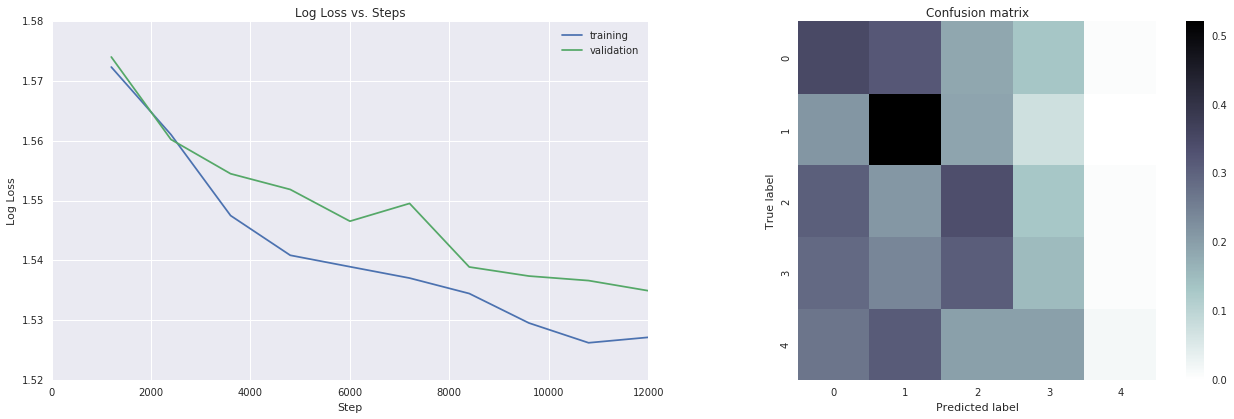

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.57
  step 2401 : 1.56
  step 3601 : 1.55
  step 4801 : 1.55
  step 6001 : 1.55
  step 7201 : 1.55
  step 8401 : 1.55
  step 9601 : 1.55
  step 10801 : 1.54
  step 12000 : 1.54
Final Log Loss (on training data): 1.54
Final Log Loss (on validation data): 1.55
Final accuracy (on validation data): 0.28


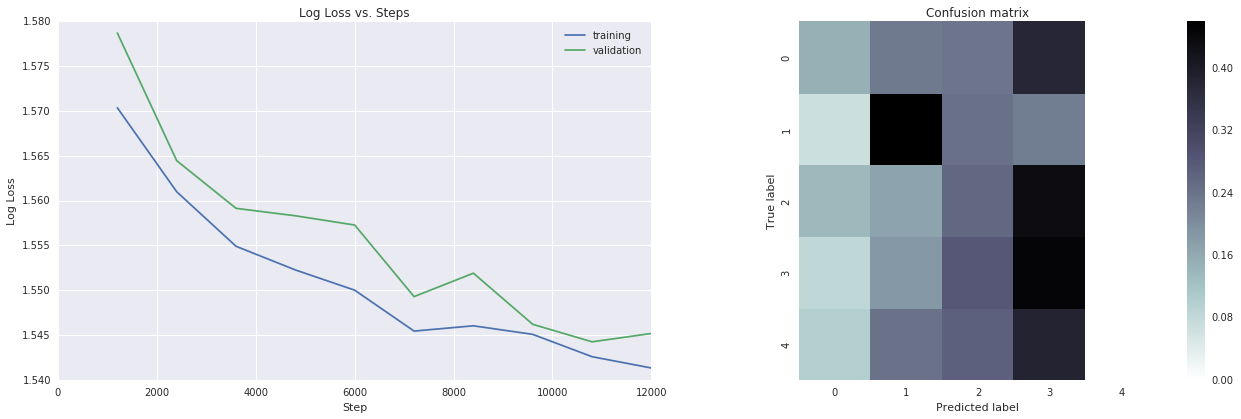

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.57
  step 2401 : 1.56
  step 3601 : 1.56
  step 4801 : 1.55
  step 6001 : 1.55
  step 7201 : 1.55
  step 8401 : 1.55
  step 9601 : 1.55
  step 10801 : 1.55
  step 12000 : 1.55
Final Log Loss (on training data): 1.55
Final Log Loss (on validation data): 1.55
Final accuracy (on validation data): 0.29


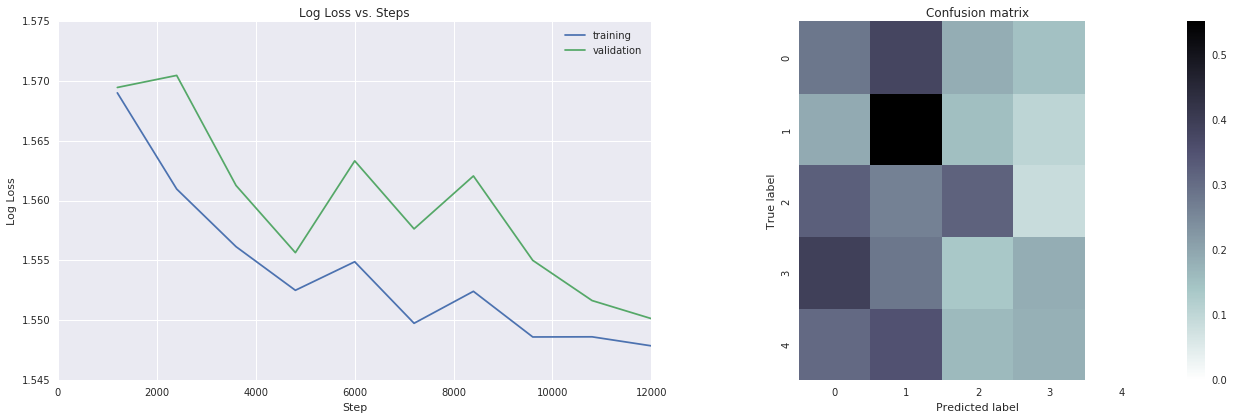

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
params: ProximalAdagradOptimizer batch_size= 1 gradient_clip_norm= 1.0 hidden_units= [50, 50] step_count= 12000
Training model...
Log Loss (on training data):
  step 1201 : 1.56
  step 2401 : 1.54
  step 3601 : 1.54
  step 4801 : 1.53
  step 6001 : 1.55
  step 7201 : 1.52
  step 8401 : 1.52
  step 9601 : 1.51
  step 10801 : 1.51
  step 12000 : 1.51
Final Log Loss (on training data): 1.51
Final Log Loss (on validation data): 1.53
Final accuracy (on validation data): 0.31


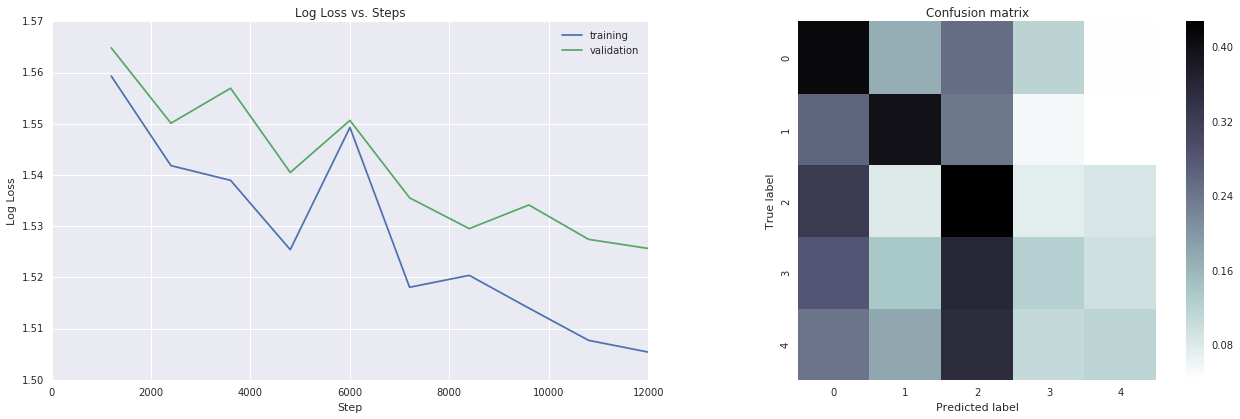

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.57
  step 2401 : 1.56
  step 3601 : 1.55
  step 4801 : 1.54
  step 6001 : 1.54
  step 7201 : 1.53
  step 8401 : 1.53
  step 9601 : 1.54
  step 10801 : 1.53
  step 12000 : 1.53
Final Log Loss (on training data): 1.53
Final Log Loss (on validation data): 1.54
Final accuracy (on validation data): 0.29


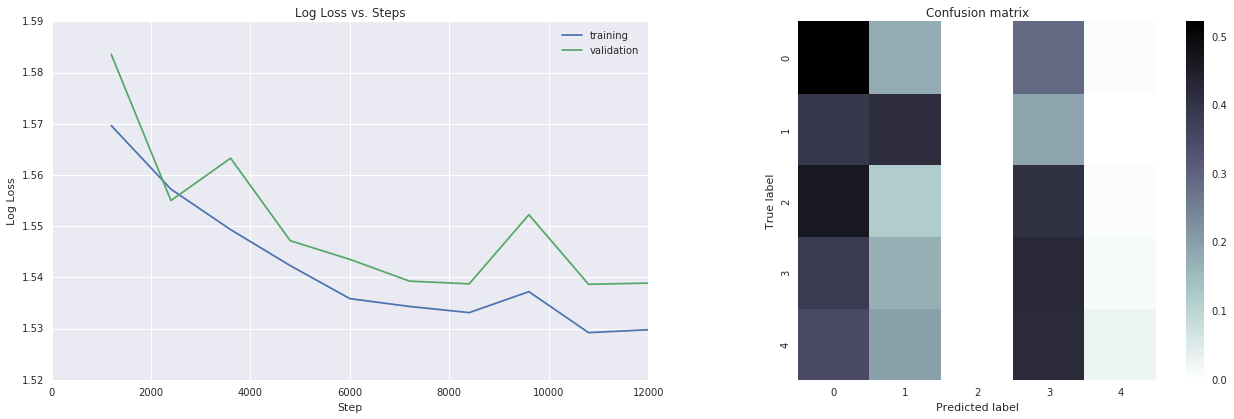

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.57
  step 2401 : 1.55
  step 3601 : 1.55
  step 4801 : 1.55
  step 6001 : 1.55
  step 7201 : 1.55
  step 8401 : 1.56
  step 9601 : 1.55
  step 10801 : 1.54
  step 12000 : 1.55
Final Log Loss (on training data): 1.55
Final Log Loss (on validation data): 1.55
Final accuracy (on validation data): 0.26


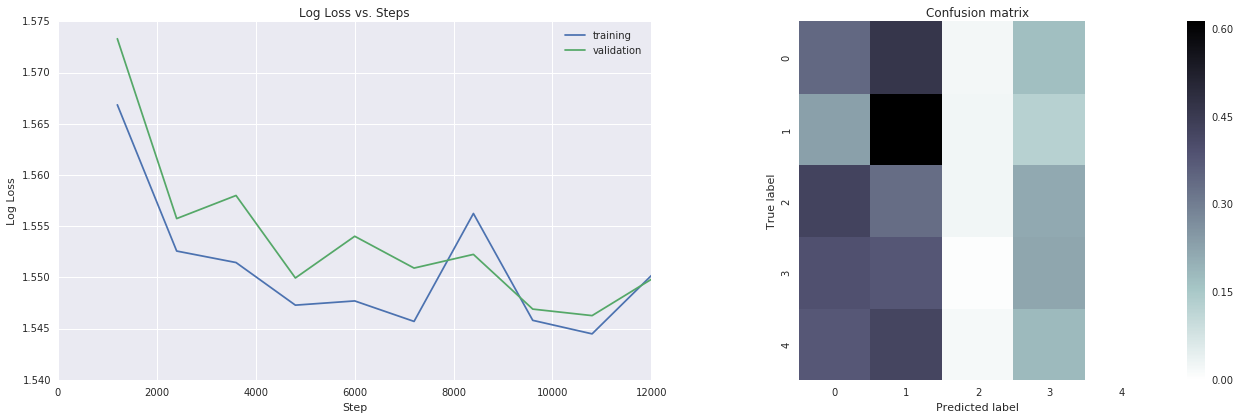

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.57
  step 2401 : 1.56
  step 3601 : 1.56
  step 4801 : 1.56
  step 6001 : 1.56
  step 7201 : 1.56
  step 8401 : 1.56
  step 9601 : 1.56
  step 10801 : 1.55
  step 12000 : 1.56
Final Log Loss (on training data): 1.56
Final Log Loss (on validation data): 1.57
Final accuracy (on validation data): 0.27


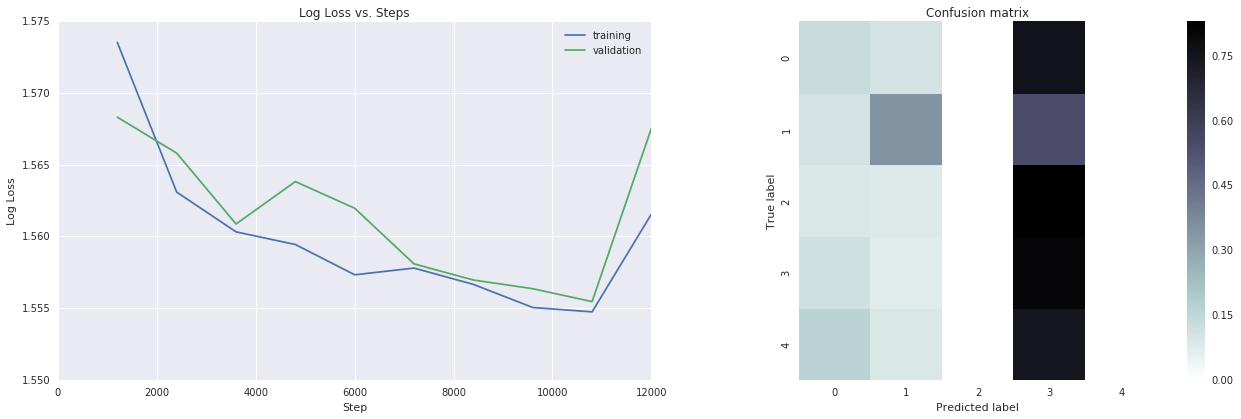

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
params: ProximalAdagradOptimizer batch_size= 1 gradient_clip_norm= 2.5 hidden_units= [50, 50] step_count= 12000
Training model...
Log Loss (on training data):
  step 1201 : 1.56
  step 2401 : 1.54
  step 3601 : 1.53
  step 4801 : 1.52
  step 6001 : 1.52
  step 7201 : 1.51
  step 8401 : 1.51
  step 9601 : 1.52
  step 10801 : 1.50
  step 12000 : 1.50
Final Log Loss (on training data): 1.50
Final Log Loss (on validation data): 1.53
Final accuracy (on validation data): 0.31


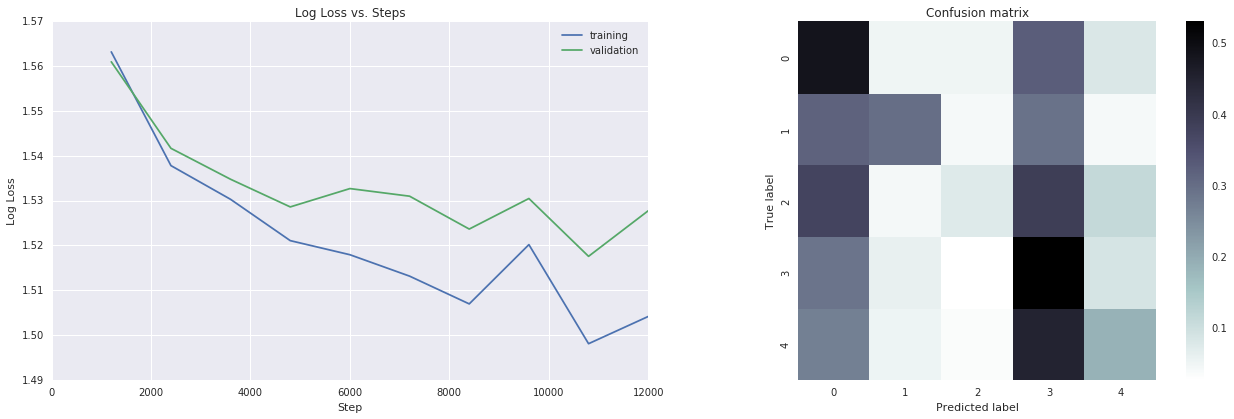

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.57
  step 2401 : 1.55
  step 3601 : 1.54
  step 4801 : 1.54
  step 6001 : 1.53
  step 7201 : 1.53
  step 8401 : 1.53
  step 9601 : 1.52
  step 10801 : 1.52
  step 12000 : 1.52
Final Log Loss (on training data): 1.52
Final Log Loss (on validation data): 1.53
Final accuracy (on validation data): 0.29


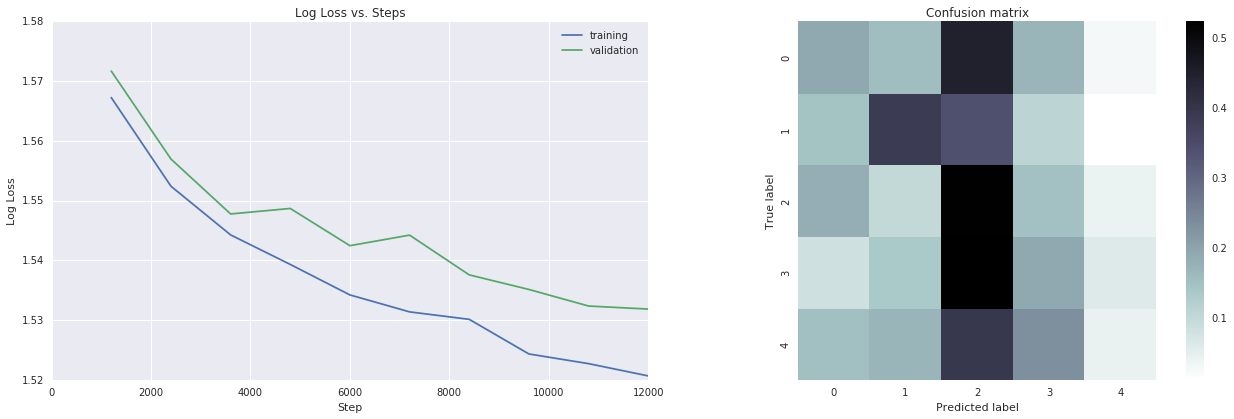

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.56
  step 2401 : 1.55
  step 3601 : 1.55
  step 4801 : 1.54
  step 6001 : 1.55
  step 7201 : 1.54
  step 8401 : 1.54
  step 9601 : 1.53
  step 10801 : 1.53
  step 12000 : 1.54
Final Log Loss (on training data): 1.54
Final Log Loss (on validation data): 1.54
Final accuracy (on validation data): 0.32


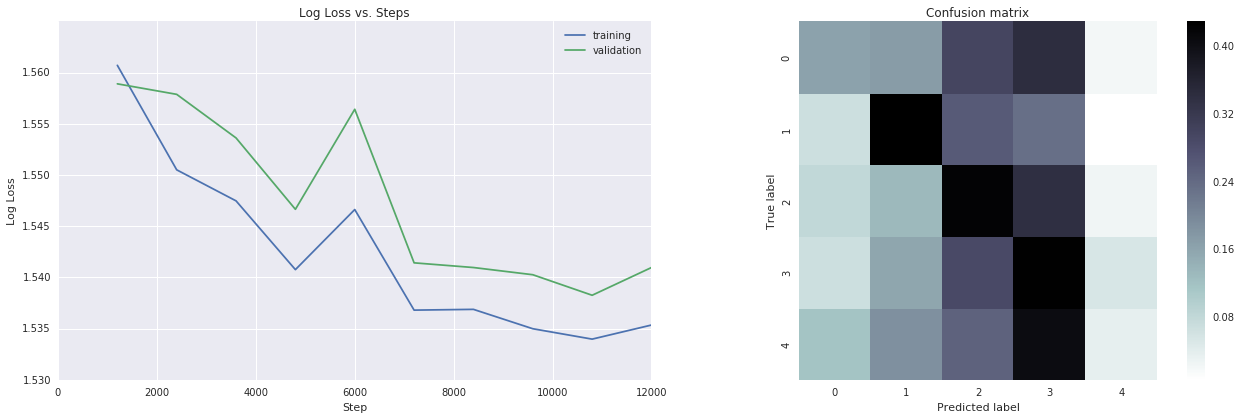

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.58
  step 2401 : 1.56
  step 3601 : 1.56
  step 4801 : 1.56
  step 6001 : 1.55
  step 7201 : 1.55
  step 8401 : 1.55
  step 9601 : 1.55
  step 10801 : 1.55
  step 12000 : 1.55
Final Log Loss (on training data): 1.55
Final Log Loss (on validation data): 1.55
Final accuracy (on validation data): 0.27


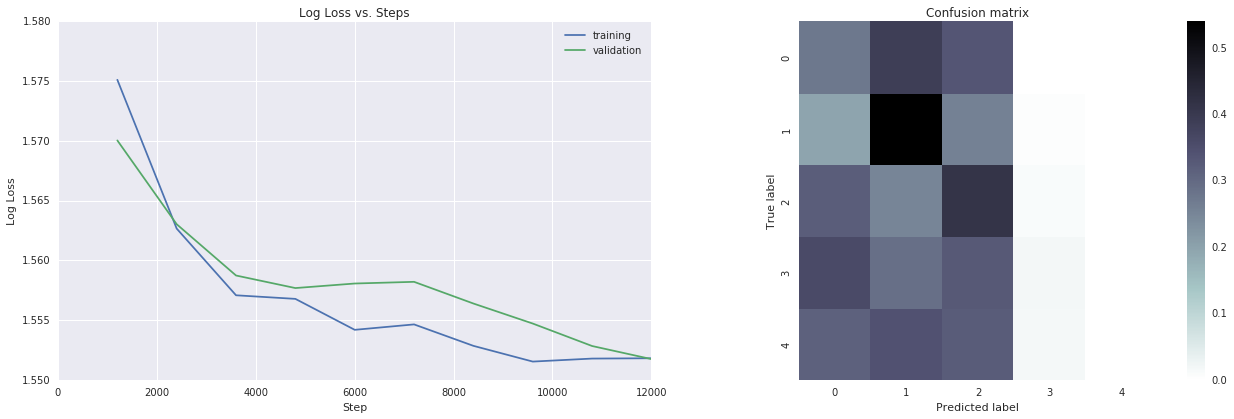

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
params: ProximalAdagradOptimizer batch_size= 1 gradient_clip_norm= 5.0 hidden_units= [50, 50] step_count= 12000
Training model...
Log Loss (on training data):
  step 1201 : 1.56
  step 2401 : 1.54
  step 3601 : 1.54
  step 4801 : 1.52
  step 6001 : 1.52
  step 7201 : 1.52
  step 8401 : 1.51
  step 9601 : 1.50
  step 10801 : 1.51
  step 12000 : 1.49
Final Log Loss (on training data): 1.49
Final Log Loss (on validation data): 1.51
Final accuracy (on validation data): 0.30


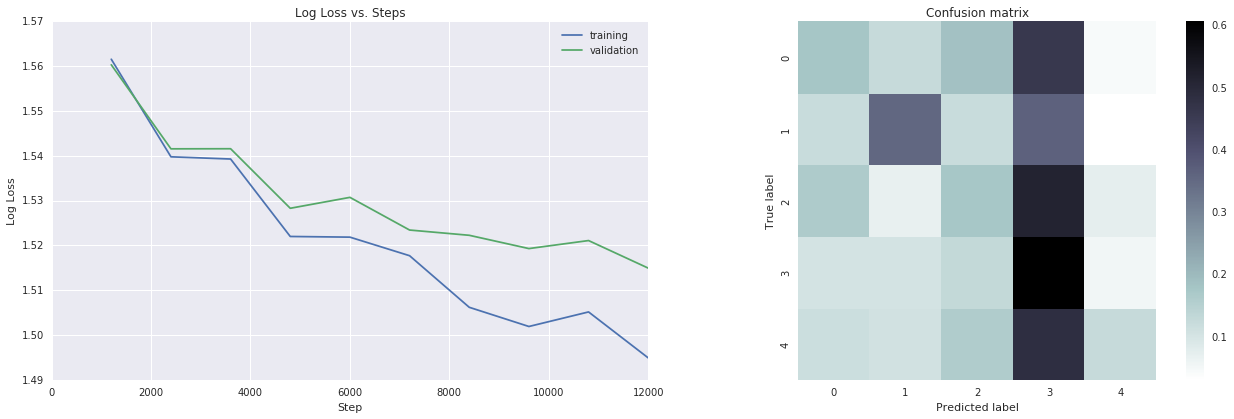

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.57
  step 2401 : 1.55
  step 3601 : 1.54
  step 4801 : 1.53
  step 6001 : 1.53
  step 7201 : 1.52
  step 8401 : 1.52
  step 9601 : 1.52
  step 10801 : 1.52
  step 12000 : 1.52
Final Log Loss (on training data): 1.52
Final Log Loss (on validation data): 1.53
Final accuracy (on validation data): 0.31


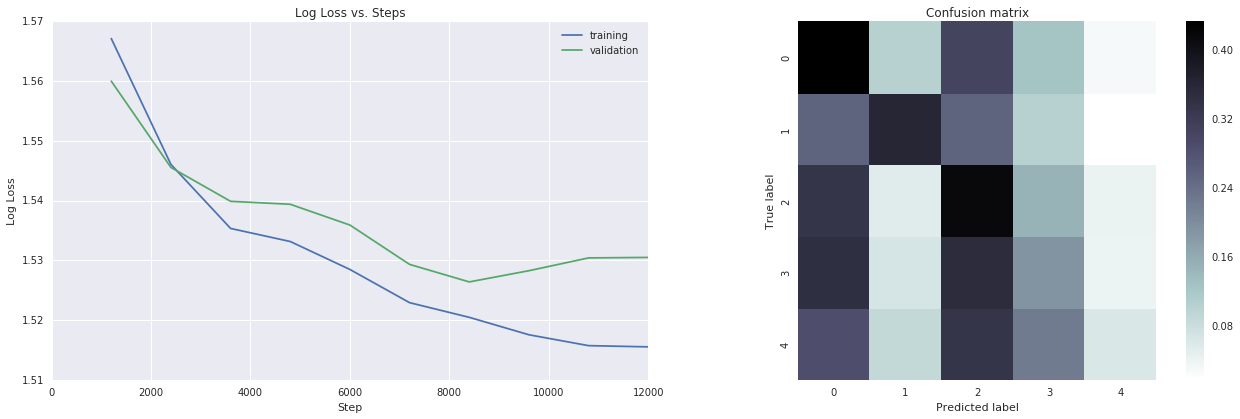

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.57
  step 2401 : 1.56
  step 3601 : 1.55
  step 4801 : 1.55
  step 6001 : 1.55
  step 7201 : 1.54
  step 8401 : 1.54
  step 9601 : 1.55
  step 10801 : 1.54
  step 12000 : 1.54
Final Log Loss (on training data): 1.54
Final Log Loss (on validation data): 1.55
Final accuracy (on validation data): 0.27


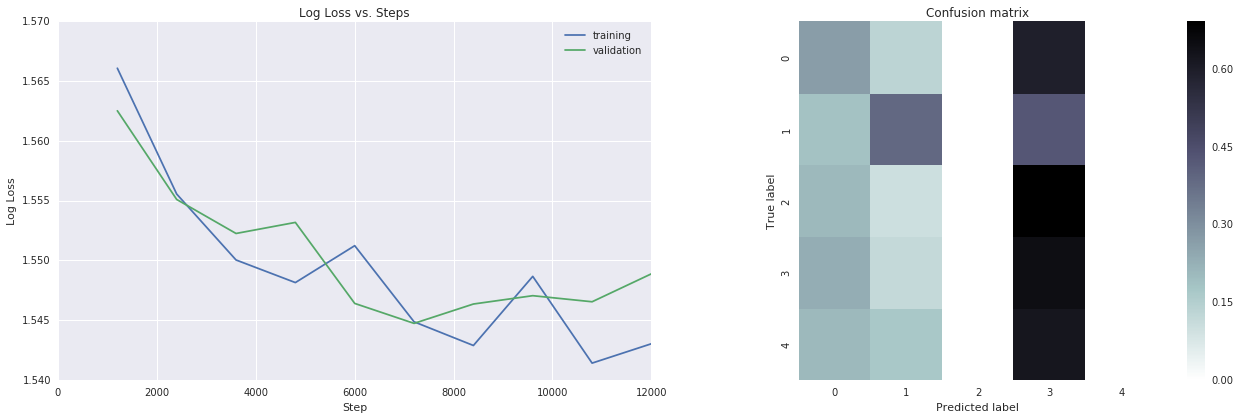

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.58
  step 2401 : 1.57
  step 3601 : 1.56
  step 4801 : 1.56
  step 6001 : 1.56
  step 7201 : 1.56
  step 8401 : 1.55
  step 9601 : 1.55
  step 10801 : 1.56
  step 12000 : 1.55
Final Log Loss (on training data): 1.55
Final Log Loss (on validation data): 1.55
Final accuracy (on validation data): 0.26


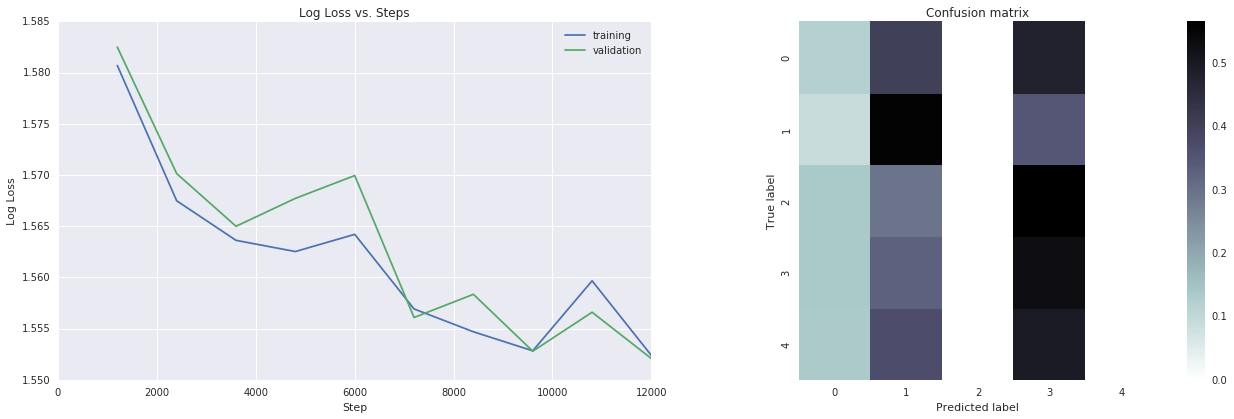

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
params: ProximalAdagradOptimizer batch_size= 1 gradient_clip_norm= 1.0 hidden_units= [30, 50] step_count= 12000
Training model...
Log Loss (on training data):
  step 1201 : 1.60
  step 2401 : 1.59
  step 3601 : 1.59
  step 4801 : 1.58
  step 6001 : 1.58
  step 7201 : 1.58
  step 8401 : 1.58
  step 9601 : 1.57
  step 10801 : 1.57
  step 12000 : 1.57
Final Log Loss (on training data): 1.57
Final Log Loss (on validation data): 1.57
Final accuracy (on validation data): 0.28


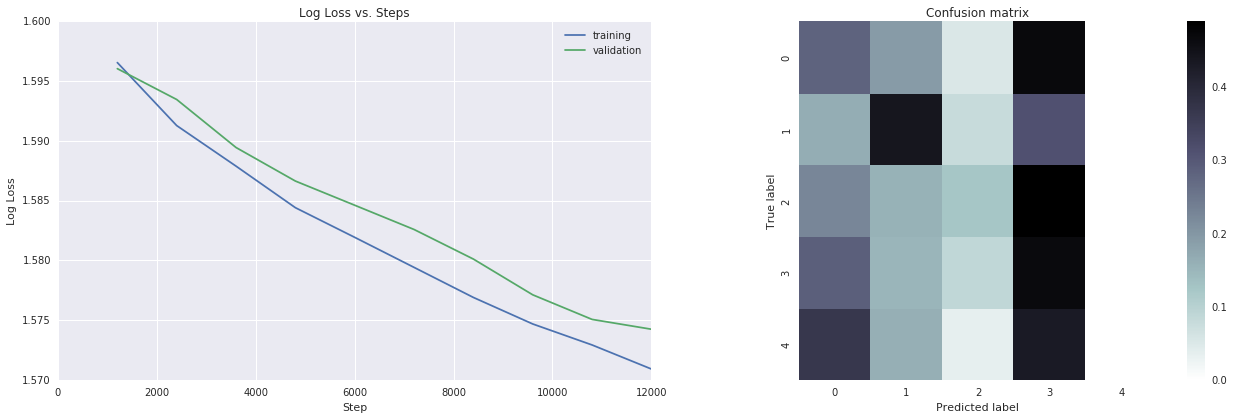

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.60
  step 2401 : 1.60
  step 3601 : 1.59
  step 4801 : 1.59
  step 6001 : 1.59
  step 7201 : 1.59
  step 8401 : 1.58
  step 9601 : 1.58
  step 10801 : 1.58
  step 12000 : 1.58
Final Log Loss (on training data): 1.58
Final Log Loss (on validation data): 1.58
Final accuracy (on validation data): 0.27


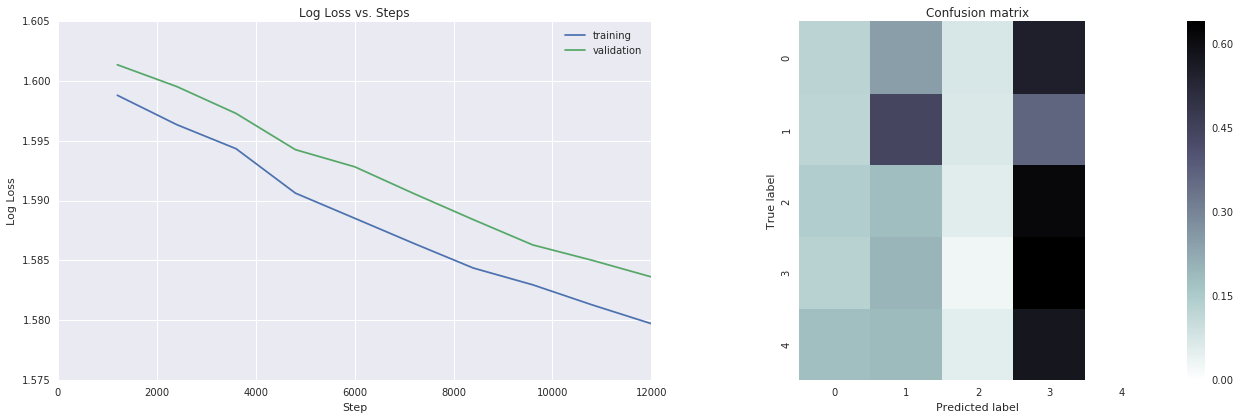

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.59
  step 2401 : 1.59
  step 3601 : 1.59
  step 4801 : 1.58
  step 6001 : 1.58
  step 7201 : 1.58
  step 8401 : 1.58
  step 9601 : 1.58
  step 10801 : 1.57
  step 12000 : 1.57
Final Log Loss (on training data): 1.57
Final Log Loss (on validation data): 1.58
Final accuracy (on validation data): 0.28


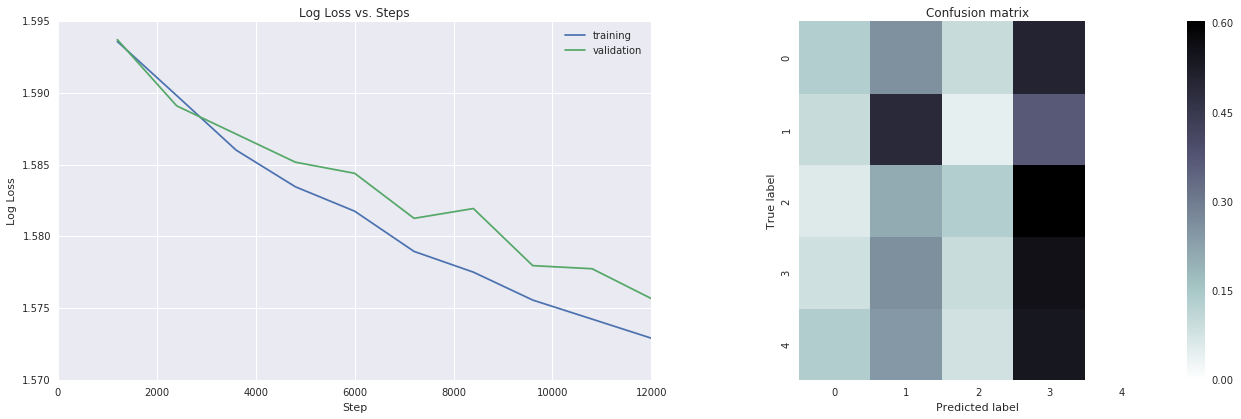

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.59
  step 2401 : 1.59
  step 3601 : 1.58
  step 4801 : 1.58
  step 6001 : 1.58
  step 7201 : 1.58
  step 8401 : 1.58
  step 9601 : 1.57
  step 10801 : 1.57
  step 12000 : 1.57
Final Log Loss (on training data): 1.57
Final Log Loss (on validation data): 1.58
Final accuracy (on validation data): 0.26


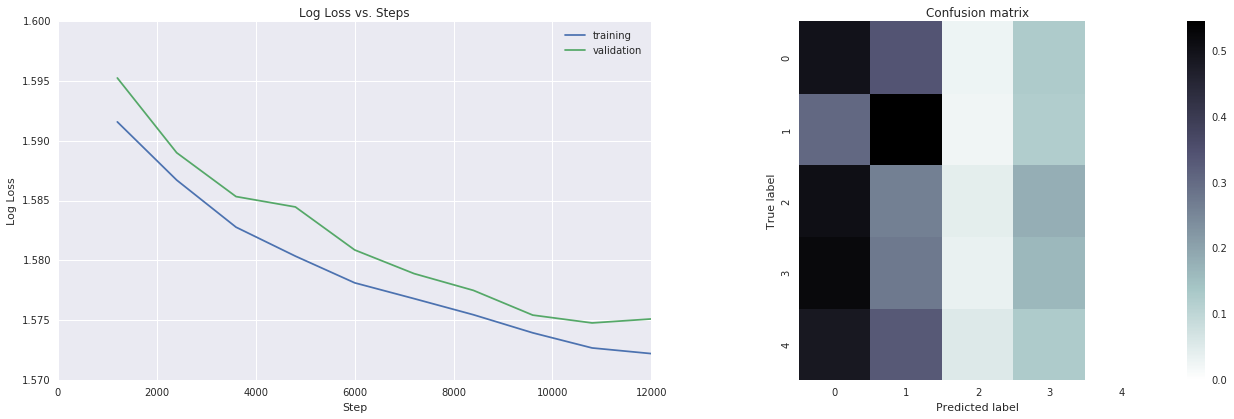

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
params: ProximalAdagradOptimizer batch_size= 1 gradient_clip_norm= 2.5 hidden_units= [30, 50] step_count= 12000
Training model...
Log Loss (on training data):
  step 1201 : 1.59
  step 2401 : 1.59
  step 3601 : 1.58
  step 4801 : 1.58
  step 6001 : 1.57
  step 7201 : 1.57
  step 8401 : 1.57
  step 9601 : 1.57
  step 10801 : 1.56
  step 12000 : 1.56
Final Log Loss (on training data): 1.56
Final Log Loss (on validation data): 1.56
Final accuracy (on validation data): 0.27


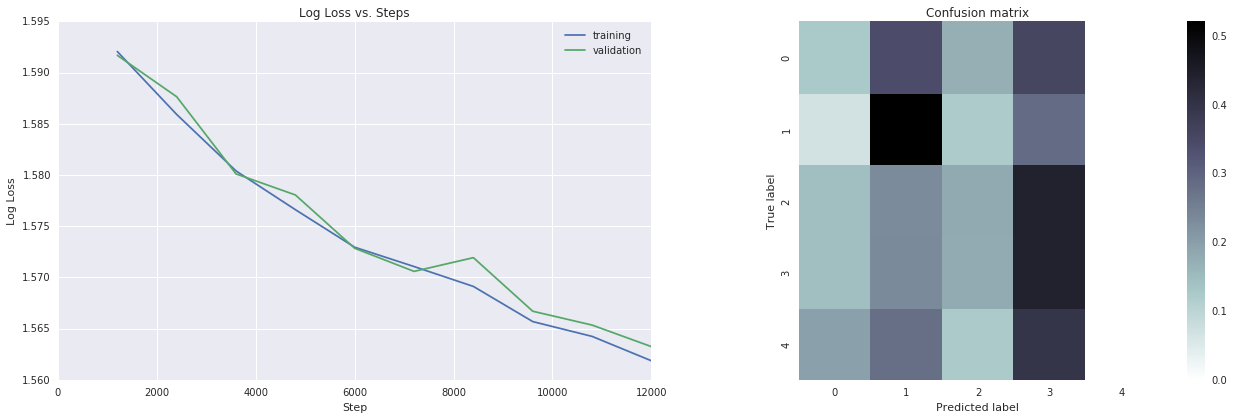

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.60
  step 2401 : 1.59
  step 3601 : 1.59
  step 4801 : 1.59
  step 6001 : 1.59
  step 7201 : 1.58
  step 8401 : 1.58
  step 9601 : 1.58
  step 10801 : 1.58
  step 12000 : 1.57
Final Log Loss (on training data): 1.57
Final Log Loss (on validation data): 1.58
Final accuracy (on validation data): 0.27


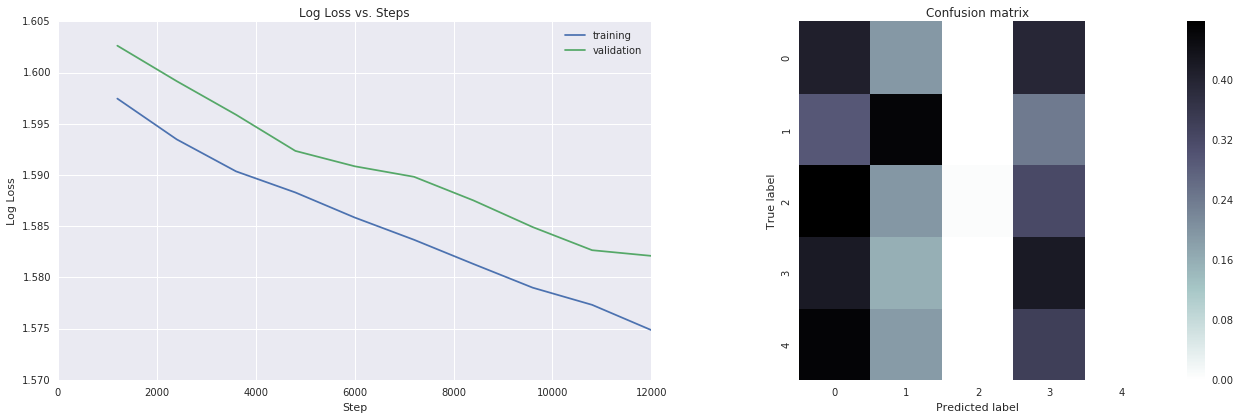

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.59
  step 2401 : 1.58
  step 3601 : 1.58
  step 4801 : 1.58
  step 6001 : 1.57
  step 7201 : 1.57
  step 8401 : 1.57
  step 9601 : 1.57
  step 10801 : 1.57
  step 12000 : 1.56
Final Log Loss (on training data): 1.56
Final Log Loss (on validation data): 1.57
Final accuracy (on validation data): 0.27


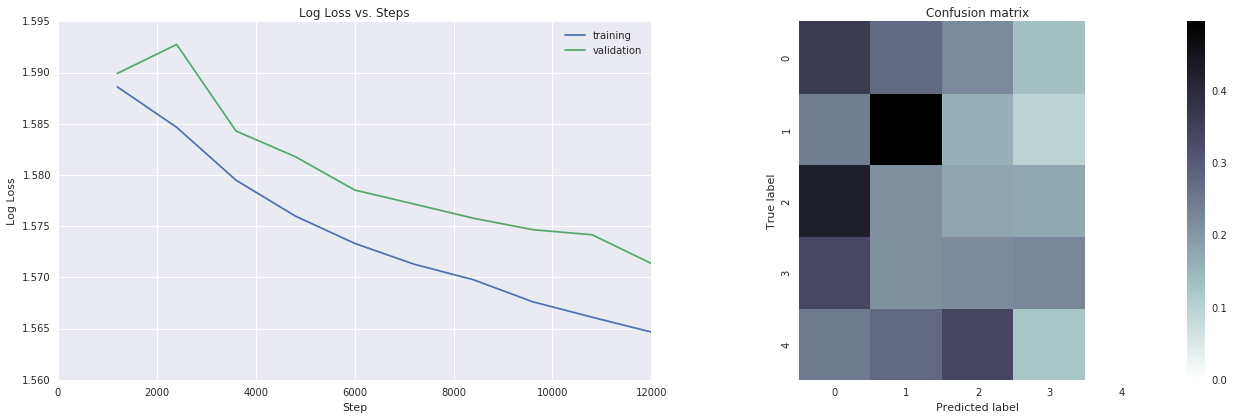

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.59
  step 2401 : 1.58
  step 3601 : 1.58
  step 4801 : 1.58
  step 6001 : 1.57
  step 7201 : 1.57
  step 8401 : 1.57
  step 9601 : 1.57
  step 10801 : 1.57
  step 12000 : 1.57
Final Log Loss (on training data): 1.57
Final Log Loss (on validation data): 1.57
Final accuracy (on validation data): 0.27


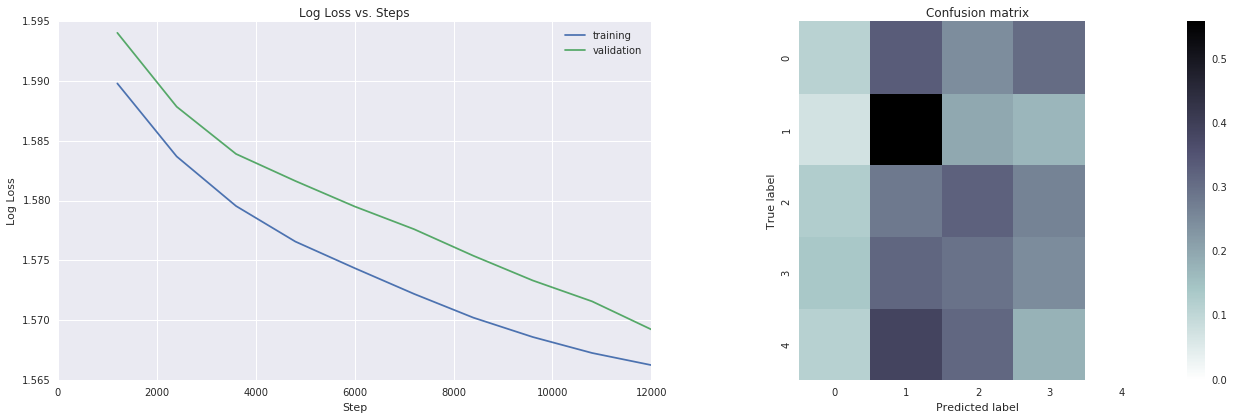

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
params: ProximalAdagradOptimizer batch_size= 1 gradient_clip_norm= 5.0 hidden_units= [30, 50] step_count= 12000
Training model...
Log Loss (on training data):
  step 1201 : 1.60
  step 2401 : 1.59
  step 3601 : 1.59
  step 4801 : 1.58
  step 6001 : 1.58
  step 7201 : 1.58
  step 8401 : 1.58
  step 9601 : 1.57
  step 10801 : 1.57
  step 12000 : 1.57
Final Log Loss (on training data): 1.57
Final Log Loss (on validation data): 1.58
Final accuracy (on validation data): 0.29


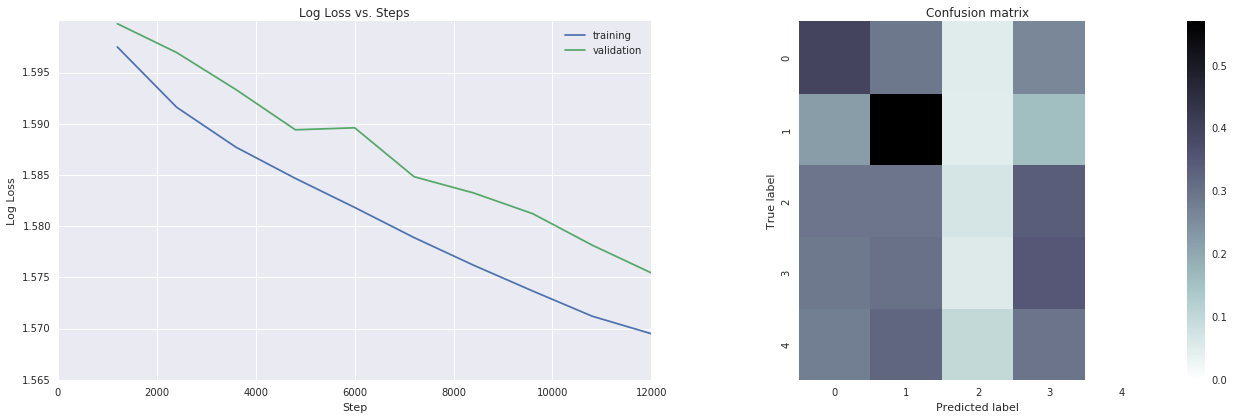

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.59
  step 2401 : 1.58
  step 3601 : 1.58
  step 4801 : 1.57
  step 6001 : 1.57
  step 7201 : 1.57
  step 8401 : 1.56
  step 9601 : 1.56
  step 10801 : 1.56
  step 12000 : 1.56
Final Log Loss (on training data): 1.56
Final Log Loss (on validation data): 1.56
Final accuracy (on validation data): 0.29


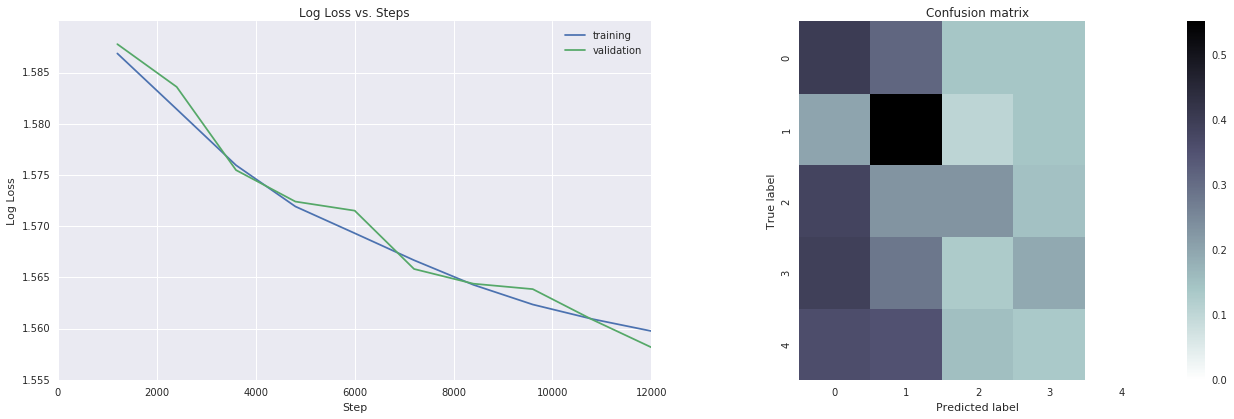

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.60
  step 2401 : 1.60
  step 3601 : 1.59
  step 4801 : 1.59
  step 6001 : 1.59
  step 7201 : 1.59
  step 8401 : 1.59
  step 9601 : 1.58
  step 10801 : 1.58
  step 12000 : 1.58
Final Log Loss (on training data): 1.58
Final Log Loss (on validation data): 1.59
Final accuracy (on validation data): 0.27


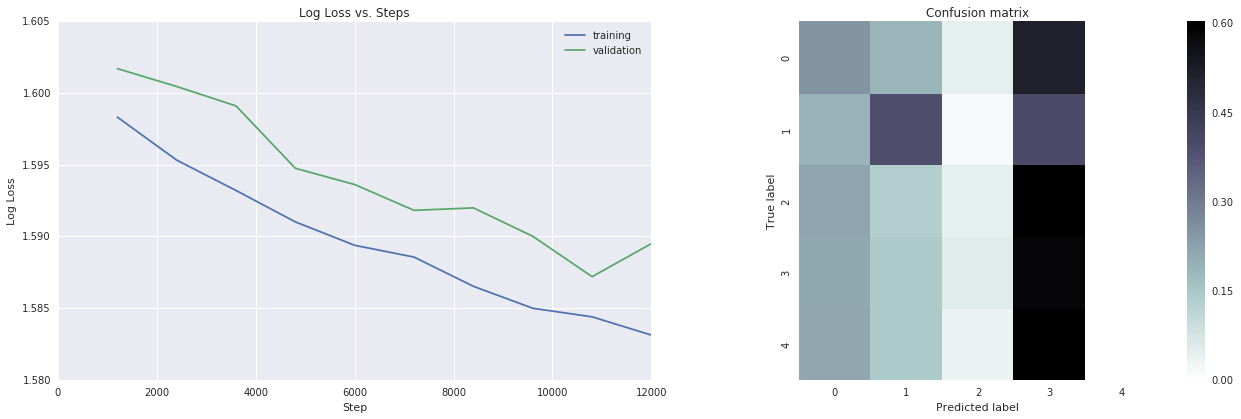

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.58
  step 2401 : 1.57
  step 3601 : 1.57
  step 4801 : 1.57
  step 6001 : 1.57
  step 7201 : 1.57
  step 8401 : 1.56
  step 9601 : 1.56
  step 10801 : 1.56
  step 12000 : 1.56
Final Log Loss (on training data): 1.56
Final Log Loss (on validation data): 1.57
Final accuracy (on validation data): 0.26


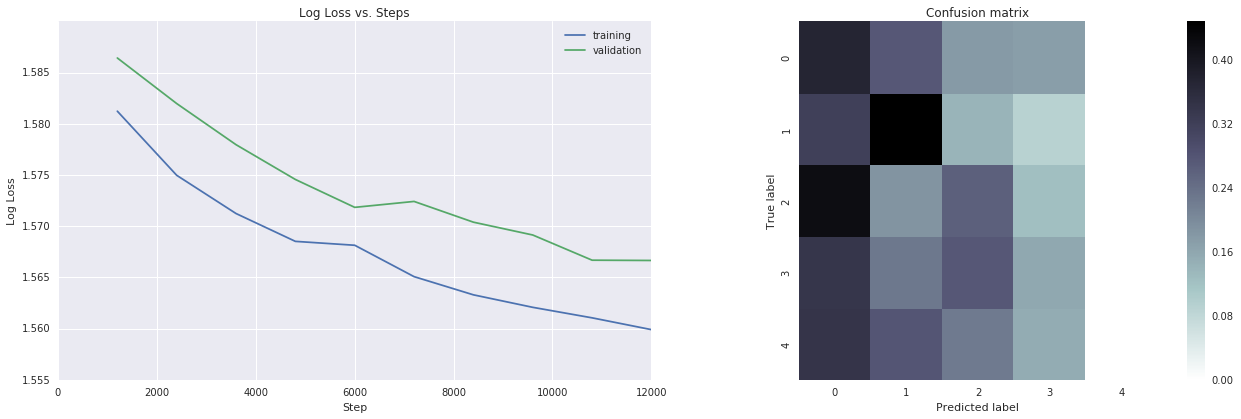

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
params: ProximalAdagradOptimizer batch_size= 1 gradient_clip_norm= 1.0 hidden_units= [30, 50] step_count= 12000
Training model...
Log Loss (on training data):
  step 1201 : 1.59
  step 2401 : 1.57
  step 3601 : 1.57
  step 4801 : 1.56
  step 6001 : 1.56
  step 7201 : 1.55
  step 8401 : 1.55
  step 9601 : 1.55
  step 10801 : 1.55
  step 12000 : 1.55
Final Log Loss (on training data): 1.55
Final Log Loss (on validation data): 1.55
Final accuracy (on validation data): 0.28


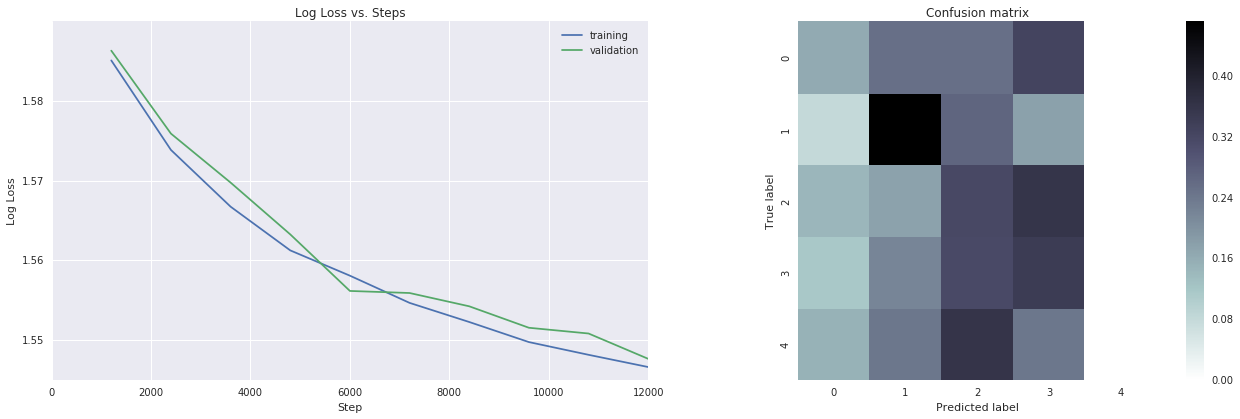

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.59
  step 2401 : 1.58
  step 3601 : 1.57
  step 4801 : 1.57
  step 6001 : 1.57
  step 7201 : 1.57
  step 8401 : 1.56
  step 9601 : 1.56
  step 10801 : 1.56
  step 12000 : 1.56
Final Log Loss (on training data): 1.56
Final Log Loss (on validation data): 1.56
Final accuracy (on validation data): 0.28


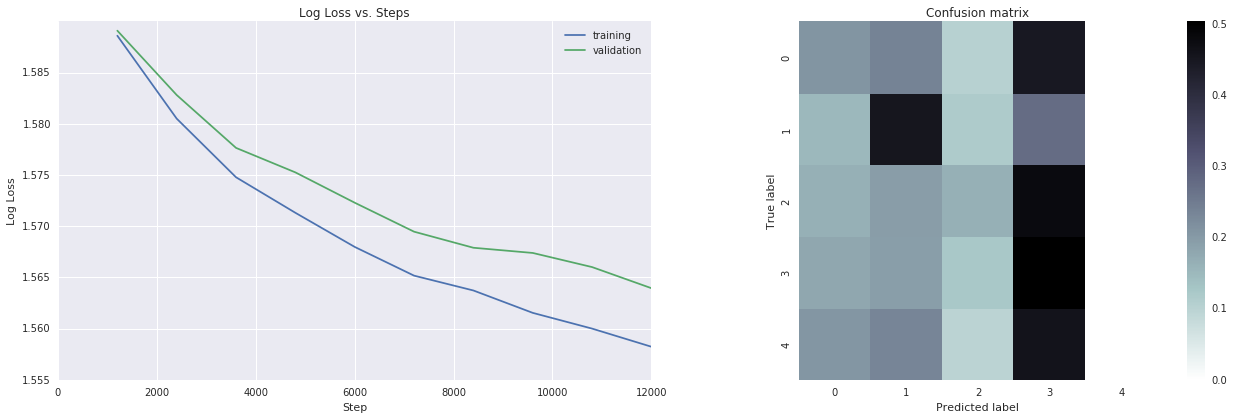

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.59
  step 2401 : 1.58
  step 3601 : 1.57
  step 4801 : 1.57
  step 6001 : 1.57
  step 7201 : 1.57
  step 8401 : 1.56
  step 9601 : 1.56
  step 10801 : 1.56
  step 12000 : 1.56
Final Log Loss (on training data): 1.56
Final Log Loss (on validation data): 1.57
Final accuracy (on validation data): 0.25


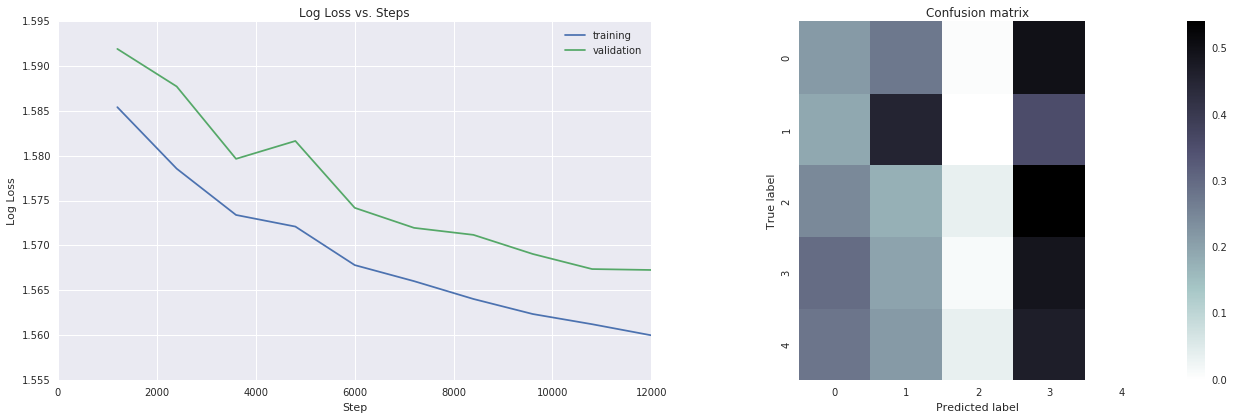

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):
  step 1201 : 1.59
  step 2401 : 1.59
  step 3601 : 1.59
  step 4801 : 1.58
  step 6001 : 1.58
  step 7201 : 1.58
  step 8401 : 1.58
  step 9601 : 1.57
  step 10801 : 1.57
  step 12000 : 1.57
Final Log Loss (on training data): 1.57
Final Log Loss (on validation data): 1.57
Final accuracy (on validation data): 0.30


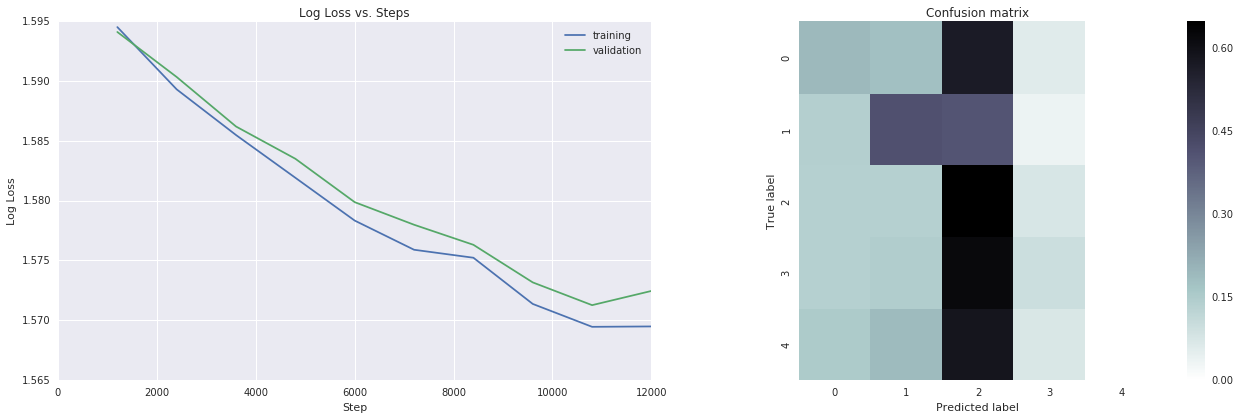

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
params: ProximalAdagradOptimizer batch_size= 1 gradient_clip_norm= 2.5 hidden_units= [30, 50] step_count= 12000
Training model...
Log Loss (on training data):
  step 1201 : 1.57
  step 2401 : 1.56
  step 3601 : 1.56
  step 4801 : 1.55
  step 6001 : 1.55
  step 7201 : 1.54
  step 8401 : 1.54
  step 9601 : 1.54
  step 10801 : 1.54
  step 12000 : 1.53
Final Log Loss (on training data): 1.53
Final Log Loss (on validation data): 1.55
Final accuracy (on validation data): 0.28


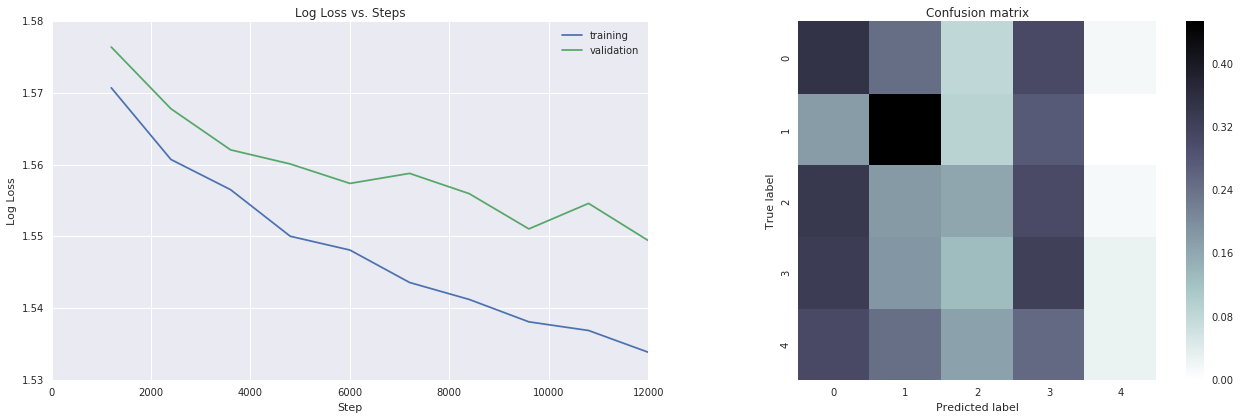

Final test accuracy (on test data): 0.31
Final training accuracy (on test data): 0.30
Training model...
Log Loss (on training data):


UnknownError: ignored

Error in callback <bound method IPythonEventMonitor.PostRunCell of <google3.quality.ranklab.ipy_ext.session_events.IPythonEventMonitor object at 0x5592d0056f10>> (for post_run_cell):


IOError: ignored

In [15]:
BATCH_SIZE = [1, 5, 10, 15, 20]
HIDDEN_UNITS = [[50,50], [30,50], [100,100]]
LEARNING_RATE = [0.001, 0.002, 0.005, 0.0085]
STEPS_COUNT = np.array([12000, 26000]) # 14000, 18000, 20000, 22000,
gradient_clip_norms = [1.0, 2.5, 5.0]
#l1_regularization_strength = [0.0, 0.01, 0.001, 0.0025, 0.005]
l2_regularization_strength = [0.005, 0.01, 0.015 ,0.02]
optimizerList = ['ProximalAdagradOptimizer'] # RMSPropOptimizer, 'AdagradOptimizer', ProximalGradientDescentOptimizer

for batch_size in BATCH_SIZE:
  for step_count in STEPS_COUNT:
    for hidden_units in HIDDEN_UNITS:
      for learning_rate in LEARNING_RATE:
        for gradient_clip_norm in gradient_clip_norms:
          for optimizerName in optimizerList:
            optimizer = None
            if optimizerName == 'AdagradOptimizer':
              print 'params:', optimizerName, 'batch_size=', batch_size, 'gradient_clip_norm=', gradient_clip_norm, 'hidden_units=',hidden_units, 'step_count=',step_count
              optimizer = tf.AdagradOptimizer(learning_rate=learning_rate)
              runLoop(batch_size, gradient_clip_norm, optimizer, hidden_units, step_count)
            elif optimizerName == 'ProximalAdagradOptimizer':
              for lr2 in l2_regularization_strength:
                print 'params:', optimizerName, 'batch_size=', batch_size, 'gradient_clip_norm=', gradient_clip_norm, 'hidden_units=',hidden_units, 'step_count=',step_count
                optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=learning_rate, l2_regularization_strength=lr2)
                runLoop(batch_size, gradient_clip_norm, optimizer, hidden_units, step_count)
            elif optimizerName == 'ProximalGradientDescentOptimizer':
              for lr2 in l2_regularization_strength:
                print 'params:', optimizerName, 'batch_size=', batch_size, 'gradient_clip_norm=', gradient_clip_norm, 'hidden_units=',hidden_units, 'step_count=',step_count
                optimizer = tf.train.ProximalGradientDescentOptimizer(learning_rate=learning_rate, l2_regularization_strength=0.003)
                runLoop(batch_size, gradient_clip_norm, optimizer, hidden_units, step_count)              

            if optimizer == None:
              raise 'Null optimizer!'                

### 16-genres, chroma only
Not able to learn...

Training model...
Log Loss (on training data):
  step 2501 : 2.12
  step 5001 : 2.12
  step 7501 : 2.12
  step 10001 : 2.12
  step 12501 : 2.12
  step 15001 : 2.12
  step 17501 : 2.12
  step 20001 : 2.12
  step 22501 : 2.12
  step 25000 : 2.12
Final Log Loss (on training data): 2.12
Final Log Loss (on validation data): 2.12
Final accuracy (on validation data): 0.24


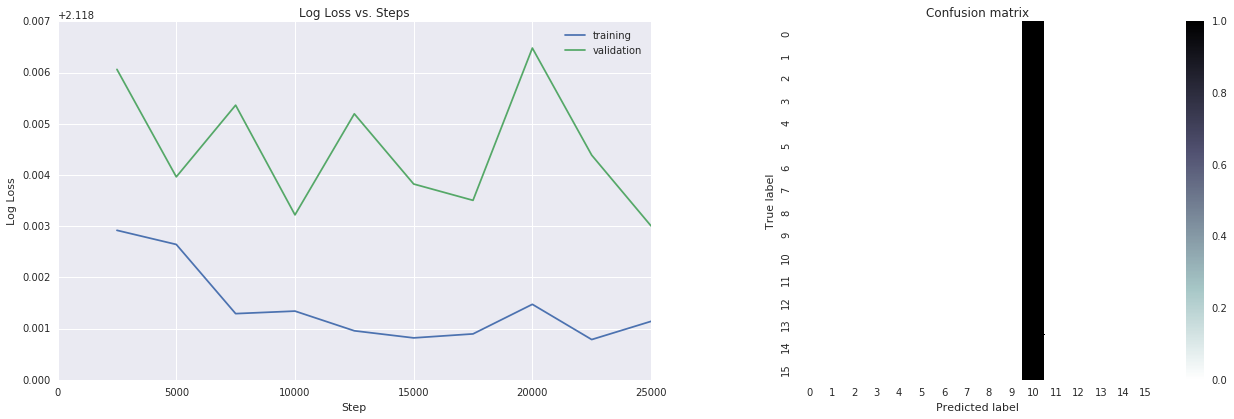

In [39]:
N_CLASSES = 16
BATCH_SIZE = 10
HIDDEN_UNITS = [20, 10]
LEARNING_RATE = 0.01
STEPS = 25000
gradient_clip_norm = 2.0

#optimizer = tf.AdagradOptimizer(learning_rate=LEARNING_RATE)
#optimizer=tf.train.AdamOptimizer(learning_rate=LEARNING_RATE),
optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=LEARNING_RATE, initial_accumulator_value=0.01, l2_regularization_strength=0.002)
#optimizer=tf.train.ProximalGradientDescentOptimizer(learning_rate=LEARNING_RATE, l1_regularization_strength=0.0, l2_regularization_strength=0.001)
#optimizer = tf.train.RMSPropOptimizer(learning_rate=0.003, decay=0.1, momentum=0.9, epsilon=1e-10, centered=False)

# Create the input functions.
predict_training_input_fn = create_predict_input_fn(
    training_features, training_labels)
predict_validation_input_fn = create_predict_input_fn(
    validation_features, validation_labels)
training_input_fn = create_training_input_fn(
    training_features, training_labels, BATCH_SIZE)

feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input_fn(
    training_input_fn)

# Create DNN classifier.
classifier = tf.contrib.learn.DNNClassifier(
  feature_columns=feature_columns,
  n_classes=N_CLASSES,
  hidden_units=HIDDEN_UNITS,
  optimizer=optimizer,
  gradient_clip_norm=gradient_clip_norm,
  config=mlcc_config.create_config(STEPS),
)

def train_model_solution(classifier):
  """Trains the given classifier."""
  # Create the hooks that periodically trigger during model training.
  log_loss_train_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_training_input_fn,
      targets=training_labels,
      input_type="training",
      steps=STEPS)
  log_loss_validation_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_validation_input_fn,
      targets=validation_labels,
      input_type="validation",
      steps=STEPS,
      print_intermediate_results=False)

  print "Training model..."
  classifier.fit(
      input_fn=training_input_fn,
      steps=STEPS,
      monitors=[log_loss_train_hook, log_loss_validation_hook],
  )
  
  eval_metrics = classifier.evaluate(input_fn=predict_validation_input_fn)
  print "Final accuracy (on validation data): %0.2f" % eval_metrics["accuracy"]

  final_predictions = list(classifier.predict_classes(
      input_fn=predict_validation_input_fn))

  mlcc_plots.plot_loss_confusion_matrix(
      [log_loss_train_hook, log_loss_validation_hook],
      validation_labels,
      final_predictions)
  
train_model_solution(classifier)

### 16-Genres, mfcc only

Training model...
Log Loss (on training data):
  step 2501 : 2.12
  step 5001 : 2.12
  step 7501 : 2.12
  step 10001 : 2.12
  step 12501 : 2.12
  step 15001 : 2.12
  step 17501 : 2.12
  step 20001 : 2.12
  step 22501 : 2.12
  step 25000 : 2.12
Final Log Loss (on training data): 2.12
Final Log Loss (on validation data): 2.12
Final accuracy (on validation data): 0.24


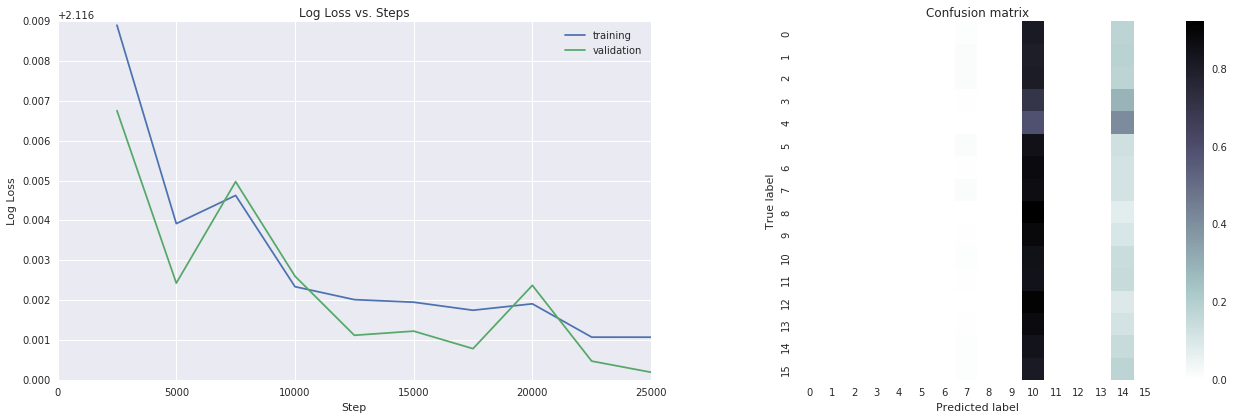

In [8]:
N_CLASSES = 16
BATCH_SIZE = 10
HIDDEN_UNITS = [20, 10]
LEARNING_RATE = 0.01
STEPS = 25000
gradient_clip_norm = 2.0

#optimizer = tf.AdagradOptimizer(learning_rate=LEARNING_RATE)
#optimizer=tf.train.AdamOptimizer(learning_rate=LEARNING_RATE),
optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=LEARNING_RATE, initial_accumulator_value=0.01, l2_regularization_strength=0.002)
#optimizer=tf.train.ProximalGradientDescentOptimizer(learning_rate=LEARNING_RATE, l1_regularization_strength=0.0, l2_regularization_strength=0.001)
#optimizer = tf.train.RMSPropOptimizer(learning_rate=0.003, decay=0.1, momentum=0.9, epsilon=1e-10, centered=False)

# Create the input functions.
predict_training_input_fn = create_predict_input_fn(
    training_features, training_labels)
predict_validation_input_fn = create_predict_input_fn(
    validation_features, validation_labels)
training_input_fn = create_training_input_fn(
    training_features, training_labels, BATCH_SIZE)

feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input_fn(
    training_input_fn)

# Create DNN classifier.
classifier = tf.contrib.learn.DNNClassifier(
  feature_columns=feature_columns,
  n_classes=N_CLASSES,
  hidden_units=HIDDEN_UNITS,
  optimizer=optimizer,
  gradient_clip_norm=gradient_clip_norm,
  config=mlcc_config.create_config(STEPS),
)

def train_model_solution(classifier):
  """Trains the given classifier."""
  # Create the hooks that periodically trigger during model training.
  log_loss_train_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_training_input_fn,
      targets=training_labels,
      input_type="training",
      steps=STEPS)
  log_loss_validation_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_validation_input_fn,
      targets=validation_labels,
      input_type="validation",
      steps=STEPS,
      print_intermediate_results=False)

  print "Training model..."
  classifier.fit(
      input_fn=training_input_fn,
      steps=STEPS,
      monitors=[log_loss_train_hook, log_loss_validation_hook],
  )
  
  eval_metrics = classifier.evaluate(input_fn=predict_validation_input_fn)
  print "Final accuracy (on validation data): %0.2f" % eval_metrics["accuracy"]

  final_predictions = list(classifier.predict_classes(
      input_fn=predict_validation_input_fn))

  mlcc_plots.plot_loss_confusion_matrix(
      [log_loss_train_hook, log_loss_validation_hook],
      validation_labels,
      final_predictions)
  
train_model_solution(classifier)

### 16-Genres, mfcc+chroma

Training model...
Log Loss (on training data):
  step 2501 : 2.12
  step 5001 : 2.12
  step 7501 : 2.12
  step 10001 : 2.12
  step 12501 : 2.12
  step 15001 : 2.12
  step 17501 : 2.12
  step 20001 : 2.12
  step 22501 : 2.12
  step 25000 : 2.12
Final Log Loss (on training data): 2.12
Final Log Loss (on validation data): 2.12
Final accuracy (on validation data): 0.24


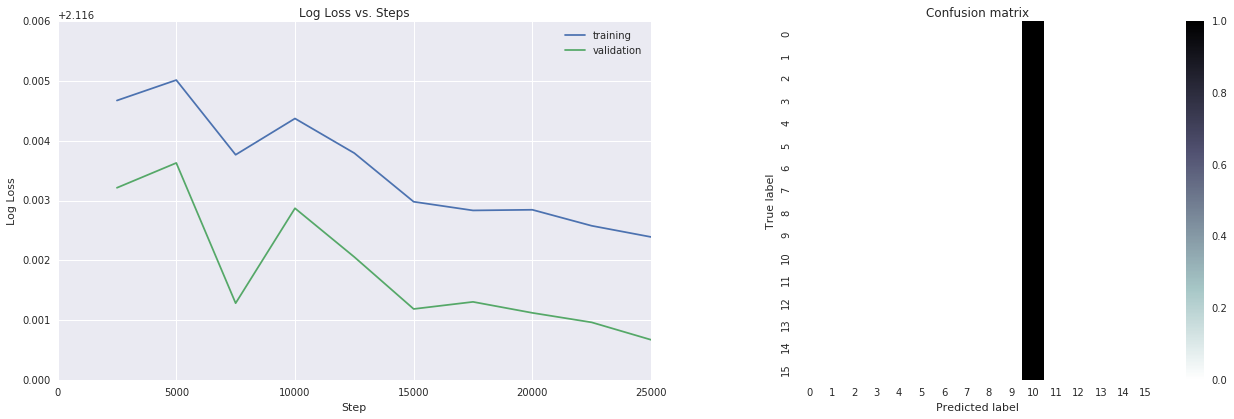

In [5]:
N_CLASSES = 16
BATCH_SIZE = 10
HIDDEN_UNITS = [20, 10]
LEARNING_RATE = 0.01
STEPS = 25000
gradient_clip_norm = 2.0

#optimizer = tf.AdagradOptimizer(learning_rate=LEARNING_RATE)
#optimizer=tf.train.AdamOptimizer(learning_rate=LEARNING_RATE),
optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=LEARNING_RATE, initial_accumulator_value=0.01, l2_regularization_strength=0.002)
#optimizer=tf.train.ProximalGradientDescentOptimizer(learning_rate=LEARNING_RATE, l1_regularization_strength=0.0, l2_regularization_strength=0.001)
#optimizer = tf.train.RMSPropOptimizer(learning_rate=0.003, decay=0.1, momentum=0.9, epsilon=1e-10, centered=False)

# Create the input functions.
predict_training_input_fn = create_predict_input_fn(
    training_features, training_labels)
predict_validation_input_fn = create_predict_input_fn(
    validation_features, validation_labels)
training_input_fn = create_training_input_fn(
    training_features, training_labels, BATCH_SIZE)

feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input_fn(
    training_input_fn)

# Create DNN classifier.
classifier = tf.contrib.learn.DNNClassifier(
  feature_columns=feature_columns,
  n_classes=N_CLASSES,
  hidden_units=HIDDEN_UNITS,
  optimizer=optimizer,
  gradient_clip_norm=gradient_clip_norm,
  config=mlcc_config.create_config(STEPS),
)

def train_model_solution(classifier):
  """Trains the given classifier."""
  # Create the hooks that periodically trigger during model training.
  log_loss_train_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_training_input_fn,
      targets=training_labels,
      input_type="training",
      steps=STEPS)
  log_loss_validation_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_validation_input_fn,
      targets=validation_labels,
      input_type="validation",
      steps=STEPS,
      print_intermediate_results=False)

  print "Training model..."
  classifier.fit(
      input_fn=training_input_fn,
      steps=STEPS,
      monitors=[log_loss_train_hook, log_loss_validation_hook],
  )
  
  eval_metrics = classifier.evaluate(input_fn=predict_validation_input_fn)
  print "Final accuracy (on validation data): %0.2f" % eval_metrics["accuracy"]

  final_predictions = list(classifier.predict_classes(
      input_fn=predict_validation_input_fn))

  mlcc_plots.plot_loss_confusion_matrix(
      [log_loss_train_hook, log_loss_validation_hook],
      validation_labels,
      final_predictions)
  
train_model_solution(classifier)

### 2-Genres, full feature set

Training model...
Log Loss (on training data):
  step  251 : 0.65
  step  501 : 0.63
  step  751 : 0.62
  step 1001 : 0.61
  step 1251 : 0.61
  step 1501 : 0.61
  step 1751 : 0.60
  step 2001 : 0.59
  step 2251 : 0.59
  step 2500 : 0.59
Final Log Loss (on training data): 0.59
Final Log Loss (on validation data): 0.61
Final accuracy (on validation data): 0.68


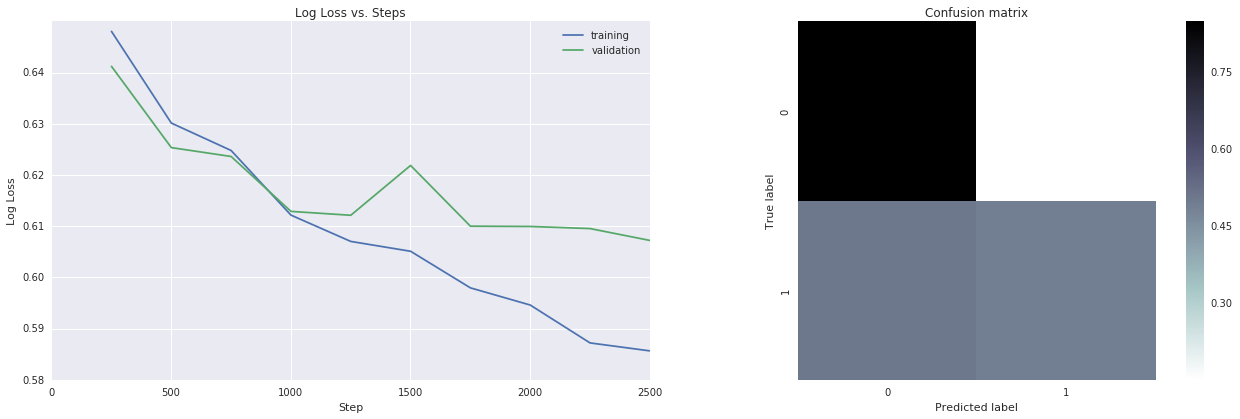

In [23]:
N_CLASSES = 2
BATCH_SIZE = 10
HIDDEN_UNITS = [50, 50]
LEARNING_RATE = 0.01
STEPS = 2500
gradient_clip_norm = 2.0

#optimizer = tf.AdagradOptimizer(learning_rate=LEARNING_RATE)
#optimizer=tf.train.AdamOptimizer(learning_rate=LEARNING_RATE),
optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=LEARNING_RATE, initial_accumulator_value=0.01, l2_regularization_strength=0.001)
#optimizer=tf.train.ProximalGradientDescentOptimizer(learning_rate=LEARNING_RATE, l1_regularization_strength=0.0, l2_regularization_strength=0.001)
#optimizer = tf.train.RMSPropOptimizer(learning_rate=0.003, decay=0.1, momentum=0.9, epsilon=1e-10, centered=False)

# Create the input functions.
predict_training_input_fn = create_predict_input_fn(
    training_features, training_labels)
predict_validation_input_fn = create_predict_input_fn(
    validation_features, validation_labels)
training_input_fn = create_training_input_fn(
    training_features, training_labels, BATCH_SIZE)

feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input_fn(
    training_input_fn)

# Create DNN classifier.
classifier = tf.contrib.learn.DNNClassifier(
  feature_columns=feature_columns,
  n_classes=N_CLASSES,
  hidden_units=HIDDEN_UNITS,
  optimizer=optimizer,
  gradient_clip_norm=gradient_clip_norm,
  config=mlcc_config.create_config(STEPS),
)

def train_model_solution(classifier):
  """Trains the given classifier."""
  # Create the hooks that periodically trigger during model training.
  log_loss_train_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_training_input_fn,
      targets=training_labels,
      input_type="training",
      steps=STEPS)
  log_loss_validation_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_validation_input_fn,
      targets=validation_labels,
      input_type="validation",
      steps=STEPS,
      print_intermediate_results=False)

  print "Training model..."
  classifier.fit(
      input_fn=training_input_fn,
      steps=STEPS,
      monitors=[log_loss_train_hook, log_loss_validation_hook],
  )
  
  eval_metrics = classifier.evaluate(input_fn=predict_validation_input_fn)
  print "Final accuracy (on validation data): %0.2f" % eval_metrics["accuracy"]

  final_predictions = list(classifier.predict_classes(
      input_fn=predict_validation_input_fn))

  mlcc_plots.plot_loss_confusion_matrix(
      [log_loss_train_hook, log_loss_validation_hook],
      validation_labels,
      final_predictions)
  
train_model_solution(classifier)

### 5-Genres, chroma only

Training model...
Log Loss (on training data):
  step 2501 : 1.60
  step 5001 : 1.60
  step 7501 : 1.60
  step 10001 : 1.59
  step 12501 : 1.59
  step 15001 : 1.58
  step 17501 : 1.58
  step 20001 : 1.58
  step 22501 : 1.58
  step 25000 : 1.57
Final Log Loss (on training data): 1.57
Final Log Loss (on validation data): 1.58
Final accuracy (on validation data): 0.24


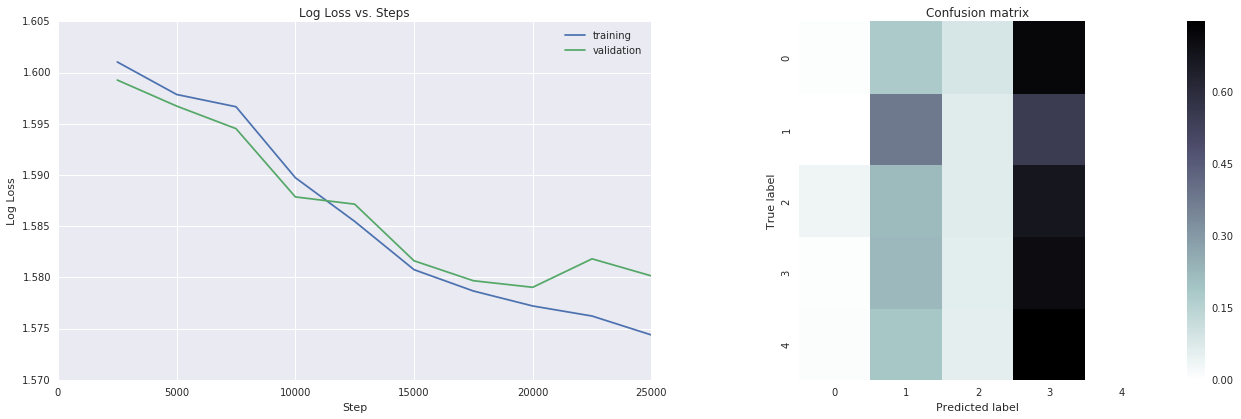

In [31]:
N_CLASSES = 5
BATCH_SIZE = 10
HIDDEN_UNITS = [50, 20]
LEARNING_RATE = 0.01
STEPS = 25000
gradient_clip_norm = 2.0

#optimizer = tf.AdagradOptimizer(learning_rate=LEARNING_RATE)
#optimizer=tf.train.AdamOptimizer(learning_rate=LEARNING_RATE),
optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=LEARNING_RATE, initial_accumulator_value=0.01, l2_regularization_strength=0.002)
#optimizer=tf.train.ProximalGradientDescentOptimizer(learning_rate=LEARNING_RATE, l1_regularization_strength=0.0, l2_regularization_strength=0.001)
#optimizer = tf.train.RMSPropOptimizer(learning_rate=0.003, decay=0.1, momentum=0.9, epsilon=1e-10, centered=False)

# Create the input functions.
predict_training_input_fn = create_predict_input_fn(
    training_features, training_labels)
predict_validation_input_fn = create_predict_input_fn(
    validation_features, validation_labels)
training_input_fn = create_training_input_fn(
    training_features, training_labels, BATCH_SIZE)

feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input_fn(
    training_input_fn)

# Create DNN classifier.
classifier = tf.contrib.learn.DNNClassifier(
  feature_columns=feature_columns,
  n_classes=N_CLASSES,
  hidden_units=HIDDEN_UNITS,
  optimizer=optimizer,
  gradient_clip_norm=gradient_clip_norm,
  config=mlcc_config.create_config(STEPS),
)

def train_model_solution(classifier):
  """Trains the given classifier."""
  # Create the hooks that periodically trigger during model training.
  log_loss_train_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_training_input_fn,
      targets=training_labels,
      input_type="training",
      steps=STEPS)
  log_loss_validation_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_validation_input_fn,
      targets=validation_labels,
      input_type="validation",
      steps=STEPS,
      print_intermediate_results=False)

  print "Training model..."
  classifier.fit(
      input_fn=training_input_fn,
      steps=STEPS,
      monitors=[log_loss_train_hook, log_loss_validation_hook],
  )
  
  eval_metrics = classifier.evaluate(input_fn=predict_validation_input_fn)
  print "Final accuracy (on validation data): %0.2f" % eval_metrics["accuracy"]

  final_predictions = list(classifier.predict_classes(
      input_fn=predict_validation_input_fn))

  mlcc_plots.plot_loss_confusion_matrix(
      [log_loss_train_hook, log_loss_validation_hook],
      validation_labels,
      final_predictions)
  
train_model_solution(classifier)

### 5 genres, mfcc only

Training model...
Log Loss (on training data):
  step 2501 : 1.56
  step 5001 : 1.54
  step 7501 : 1.53
  step 10001 : 1.53
  step 12501 : 1.52
  step 15001 : 1.52
  step 17501 : 1.52
  step 20001 : 1.52
  step 22501 : 1.51
  step 25000 : 1.51
Final Log Loss (on training data): 1.51
Final Log Loss (on validation data): 1.53
Final accuracy (on validation data): 0.28


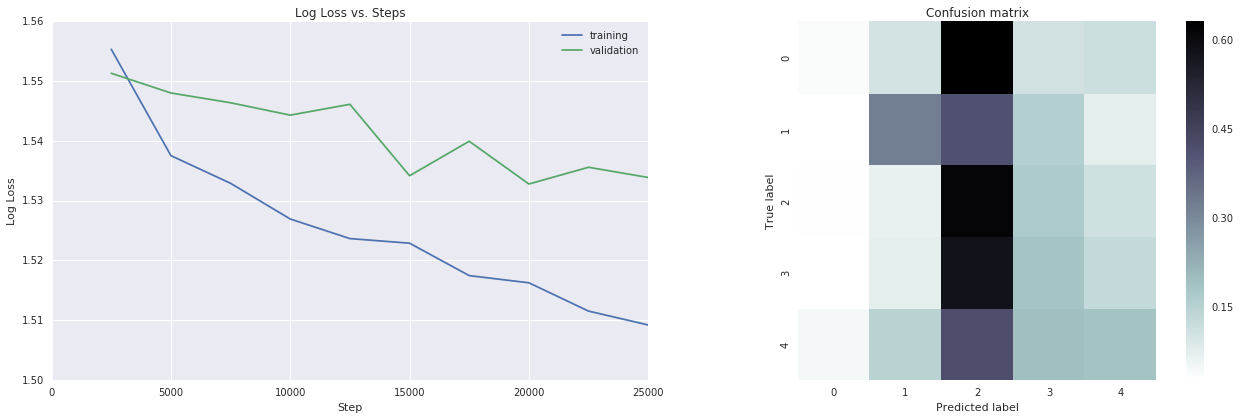

In [34]:
N_CLASSES = 5
BATCH_SIZE = 10
HIDDEN_UNITS = [50, 20]
LEARNING_RATE = 0.01
STEPS = 25000
gradient_clip_norm = 2.0

#optimizer = tf.AdagradOptimizer(learning_rate=LEARNING_RATE)
#optimizer=tf.train.AdamOptimizer(learning_rate=LEARNING_RATE),
optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=LEARNING_RATE, initial_accumulator_value=0.01, l2_regularization_strength=0.002)
#optimizer=tf.train.ProximalGradientDescentOptimizer(learning_rate=LEARNING_RATE, l1_regularization_strength=0.0, l2_regularization_strength=0.001)
#optimizer = tf.train.RMSPropOptimizer(learning_rate=0.003, decay=0.1, momentum=0.9, epsilon=1e-10, centered=False)

# Create the input functions.
predict_training_input_fn = create_predict_input_fn(
    training_features, training_labels)
predict_validation_input_fn = create_predict_input_fn(
    validation_features, validation_labels)
training_input_fn = create_training_input_fn(
    training_features, training_labels, BATCH_SIZE)

feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input_fn(
    training_input_fn)

# Create DNN classifier.
classifier = tf.contrib.learn.DNNClassifier(
  feature_columns=feature_columns,
  n_classes=N_CLASSES,
  hidden_units=HIDDEN_UNITS,
  optimizer=optimizer,
  gradient_clip_norm=gradient_clip_norm,
  config=mlcc_config.create_config(STEPS),
)

def train_model_solution(classifier):
  """Trains the given classifier."""
  # Create the hooks that periodically trigger during model training.
  log_loss_train_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_training_input_fn,
      targets=training_labels,
      input_type="training",
      steps=STEPS)
  log_loss_validation_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_validation_input_fn,
      targets=validation_labels,
      input_type="validation",
      steps=STEPS,
      print_intermediate_results=False)

  print "Training model..."
  classifier.fit(
      input_fn=training_input_fn,
      steps=STEPS,
      monitors=[log_loss_train_hook, log_loss_validation_hook],
  )
  
  eval_metrics = classifier.evaluate(input_fn=predict_validation_input_fn)
  print "Final accuracy (on validation data): %0.2f" % eval_metrics["accuracy"]

  final_predictions = list(classifier.predict_classes(
      input_fn=predict_validation_input_fn))

  mlcc_plots.plot_loss_confusion_matrix(
      [log_loss_train_hook, log_loss_validation_hook],
      validation_labels,
      final_predictions)
  
train_model_solution(classifier)

### 5-Genres, chroma+mfcc

Training model...
Log Loss (on training data):
  step 2501 : 1.55
  step 5001 : 1.54
  step 7501 : 1.53
  step 10001 : 1.53
  step 12501 : 1.53
  step 15001 : 1.52
  step 17501 : 1.52
  step 20001 : 1.52
  step 22501 : 1.52
  step 25000 : 1.51
Final Log Loss (on training data): 1.51
Final Log Loss (on validation data): 1.53
Final accuracy (on validation data): 0.30


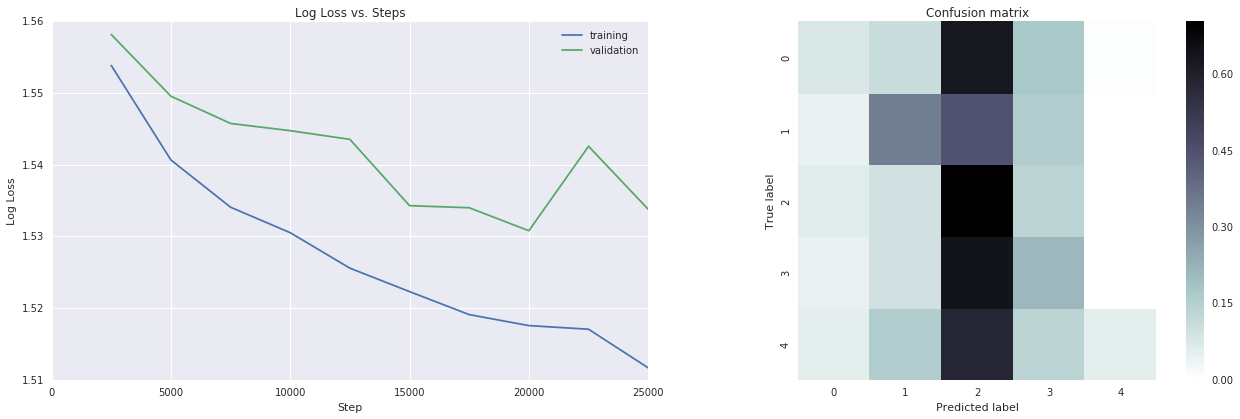

In [35]:
N_CLASSES = 5
BATCH_SIZE = 10
HIDDEN_UNITS = [50, 20]
LEARNING_RATE = 0.01
STEPS = 25000
gradient_clip_norm = 2.0

#optimizer = tf.AdagradOptimizer(learning_rate=LEARNING_RATE)
#optimizer=tf.train.AdamOptimizer(learning_rate=LEARNING_RATE),
optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=LEARNING_RATE, initial_accumulator_value=0.01, l2_regularization_strength=0.002)
#optimizer=tf.train.ProximalGradientDescentOptimizer(learning_rate=LEARNING_RATE, l1_regularization_strength=0.0, l2_regularization_strength=0.001)
#optimizer = tf.train.RMSPropOptimizer(learning_rate=0.003, decay=0.1, momentum=0.9, epsilon=1e-10, centered=False)

# Create the input functions.
predict_training_input_fn = create_predict_input_fn(
    training_features, training_labels)
predict_validation_input_fn = create_predict_input_fn(
    validation_features, validation_labels)
training_input_fn = create_training_input_fn(
    training_features, training_labels, BATCH_SIZE)

feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input_fn(
    training_input_fn)

# Create DNN classifier.
classifier = tf.contrib.learn.DNNClassifier(
  feature_columns=feature_columns,
  n_classes=N_CLASSES,
  hidden_units=HIDDEN_UNITS,
  optimizer=optimizer,
  gradient_clip_norm=gradient_clip_norm,
  config=mlcc_config.create_config(STEPS),
)

def train_model_solution(classifier):
  """Trains the given classifier."""
  # Create the hooks that periodically trigger during model training.
  log_loss_train_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_training_input_fn,
      targets=training_labels,
      input_type="training",
      steps=STEPS)
  log_loss_validation_hook = mlcc_hooks.LogLossHook(
      estimator=classifier,
      input_fn=predict_validation_input_fn,
      targets=validation_labels,
      input_type="validation",
      steps=STEPS,
      print_intermediate_results=False)

  print "Training model..."
  classifier.fit(
      input_fn=training_input_fn,
      steps=STEPS,
      monitors=[log_loss_train_hook, log_loss_validation_hook],
  )
  
  eval_metrics = classifier.evaluate(input_fn=predict_validation_input_fn)
  print "Final accuracy (on validation data): %0.2f" % eval_metrics["accuracy"]

  final_predictions = list(classifier.predict_classes(
      input_fn=predict_validation_input_fn))

  mlcc_plots.plot_loss_confusion_matrix(
      [log_loss_train_hook, log_loss_validation_hook],
      validation_labels,
      final_predictions)
  
train_model_solution(classifier)

###Visualize the weights of the first hidden layer.

In [23]:
#@test {"output": "ignore"}

classifier.get_variable_names()

['dnn/hiddenlayer_0/biases',
 'dnn/hiddenlayer_0/biases/denlayer_0/biases/part_0/ProximalAdagrad',
 'dnn/hiddenlayer_0/weights',
 'dnn/hiddenlayer_0/weights/enlayer_0/weights/part_0/ProximalAdagrad',
 'dnn/hiddenlayer_1/biases',
 'dnn/hiddenlayer_1/biases/denlayer_1/biases/part_0/ProximalAdagrad',
 'dnn/hiddenlayer_1/weights',
 'dnn/hiddenlayer_1/weights/enlayer_1/weights/part_0/ProximalAdagrad',
 'dnn/logits/biases',
 'dnn/logits/biases/dnn/logits/biases/part_0/ProximalAdagrad',
 'dnn/logits/weights',
 'dnn/logits/weights/nn/logits/weights/part_0/ProximalAdagrad',
 'dnn/multi_class_head/dnn/learning_rate',
 'global_step']

weights0 shape: (519, 50)


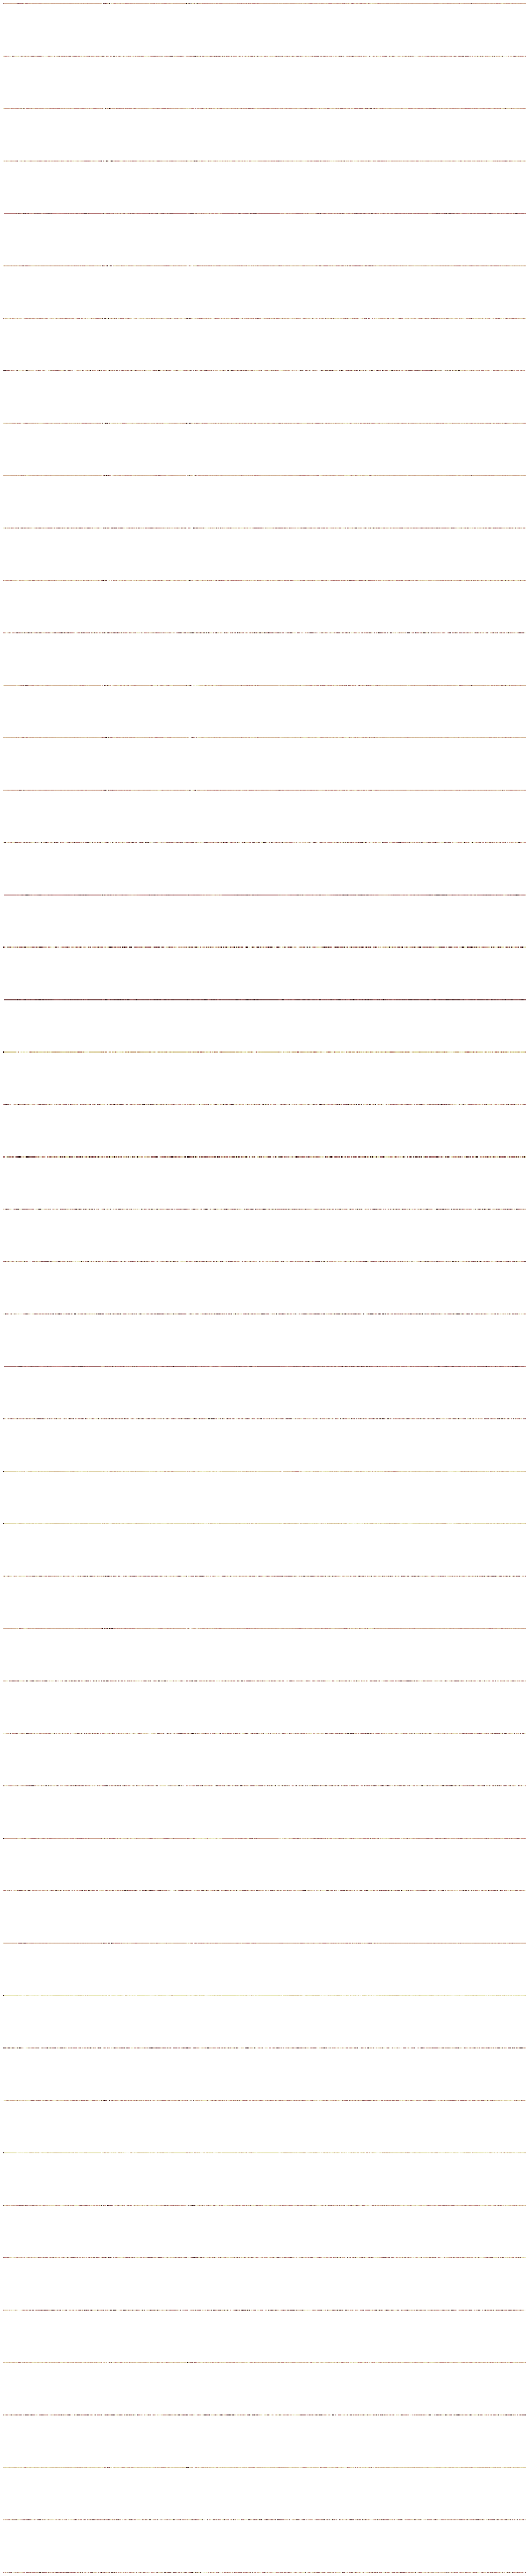

In [25]:
# Note that this cell requires that a TensorFlowDNNClassifier called
# "classifier" has already been trained.
weights0 = classifier.get_variable_value("dnn/hiddenlayer_0/weights")
assert weights0.size

print "weights0 shape:",
print weights0.shape

num_nodes = weights0.shape[1]
fig, axes = plt.subplots(num_nodes, 1, figsize=(20, 2 * num_nodes))
for coef, ax in zip(weights0.T, axes.ravel()):
    ax.matshow(coef.reshape(1, 519), cmap=plt.cm.pink)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()